In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from datetime import datetime
from datetime import date
from sklearn.cluster import KMeans
import warnings
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy.stats import chi2_contingency

%matplotlib inline

In [2]:
# Set options to display all rows
pd.set_option('display.max_rows', None)

# Set options to display all columns
pd.set_option('display.max_columns', None)

# Ignore warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the datasets
raw_train_X = pd.read_csv("airbnb_train_x.csv")
raw_train_y =pd.read_csv("airbnb_train_y.csv")
test_x = pd.read_csv("airbnb_test_x.csv")

In [4]:
train = pd.concat([raw_train_X, raw_train_y], axis=1)
train['high_booking_rate'] = train['high_booking_rate'].map({'NO': 0, 'YES': 1})

In [5]:
train.shape

(92067, 63)

In [6]:
# # Calculate fillrate for each column
# fillrates = train.notnull().mean().reset_index()
# fillrates.columns = ['column_name', 'fillrate']


# fillrates


In [7]:
#for now lets drop the text columns, we will bring them back in the end

text_columns = [
    'access',
    'description',
    'features',
    'host_about',
    'host_name',
    'house_rules',
    'interaction',
    'name',
    'neighborhood_overview',
    'notes',
    'space',
    'street',
    'summary',
    'transit'
]


In [8]:
train_2 = train.drop(columns = text_columns, axis =1)
test_x = test_x.drop(columns = text_columns, axis =1)

In [9]:
# dropping the second target column
train_2 = train_2.drop(columns = ['perfect_rating_score'], axis =1)

In [10]:
train_2.shape

(92067, 48)

In [11]:
test_x.shape

(10000, 47)

## Making some curated features

In [12]:
# price_per_guest
train_2['price_per_guest'] = train_2['price'] / (train_2['accommodates'] + 1)
train_2['price_per_guest'] = train_2['price_per_guest'].fillna(train_2['price_per_guest'].median()) #imputation

train_2['availability_rate_30'] = train_2['availability_30'] / 30
train_2['availability_rate_365'] = train_2['availability_365'] / 365

train_2['has_security_deposit'] = (train_2['security_deposit'] > 0).astype(int)

train_2['booking_pressure'] = (train_2['availability_365'] == 0).astype(int)

train_2['price_x_avail'] = train_2['price'] * train_2['availability_365']
train_2['price_x_guests'] = train_2['price'] * train_2['guests_included']
train_2['rooms_per_guest'] = (train_2['bedrooms'] + 1) / (train_2['guests_included'] + 1)

train_2['bathrooms_per_guest'] = (train_2['bathrooms'] + 1) / (train_2['guests_included'] + 1)
train_2['price_per_bedroom'] = train_2['price'] / (train_2['bedrooms'] + 1)
train_2['lat_long_product'] = train_2['latitude'] * train_2['longitude']

train_2['min_night_bin'] = pd.cut(train_2['minimum_nights'], bins=[0, 2, 7, 30, 100, 365], labels=False, include_lowest=True)

# for test set
test_x['price_per_guest'] = test_x['price'] / (test_x['accommodates'] + 1)
test_x['price_per_guest'] = test_x['price_per_guest'].fillna(test_x['price_per_guest'].median()) #imputation

test_x['availability_rate_30'] = test_x['availability_30'] / 30
test_x['availability_rate_365'] = test_x['availability_365'] / 365

test_x['has_security_deposit'] = (test_x['security_deposit'] > 0).astype(int)

test_x['booking_pressure'] = (test_x['availability_365'] == 0).astype(int)

test_x['price_x_avail'] = test_x['price'] * test_x['availability_365']
test_x['price_x_guests'] = test_x['price'] * test_x['guests_included']
test_x['rooms_per_guest'] = (test_x['bedrooms'] + 1) / (test_x['guests_included'] + 1)

test_x['bathrooms_per_guest'] = (test_x['bathrooms'] + 1) / (test_x['guests_included'] + 1)
test_x['price_per_bedroom'] = test_x['price'] / (test_x['bedrooms'] + 1)
test_x['lat_long_product'] = test_x['latitude'] * test_x['longitude']

test_x['min_night_bin'] = pd.cut(test_x['minimum_nights'], bins=[0, 2, 7, 30, 100, 365], labels=False, include_lowest=True)


In [13]:
train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92067 entries, 0 to 92066
Data columns (total 60 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   experiences_offered        92067 non-null  object 
 1   host_since                 91898 non-null  object 
 2   host_location              91656 non-null  object 
 3   host_response_time         78617 non-null  object 
 4   host_response_rate         78617 non-null  float64
 5   host_acceptance_rate       14002 non-null  object 
 6   host_neighbourhood         78069 non-null  object 
 7   host_listings_count        92067 non-null  int64  
 8   host_total_listings_count  91898 non-null  float64
 9   host_verifications         91898 non-null  object 
 10  neighborhood               92067 non-null  object 
 11  neighborhood_group         30691 non-null  object 
 12  city                       92032 non-null  object 
 13  state                      92067 non-null  obj

# Single Variate and Bi-Variate Feature Analysis and Transformations

Here I am planning to go one by one and explore all of the 49 features. The aim will be to map the relationship with the target and also check possible correlations with other features. Based on this analysis we will be able to take a further call on the the impact of these features to the end model

In [14]:
def analyze_numeric(df, feature, target='high_booking_rate', n_bins=10):
    """
    Enhanced numeric-feature EDA:
      1) Descriptive stats (+ skew/kurtosis, missing, unique counts)
      2) KDEs overall & by target class
      3) Histogram overlay by class
      4) Scatter vs target (with jitter)
      5) Top-3 correlated other numerics + scatter
      6) Missing-value bar plot
      7) Boxplot & IQR outlier check
      8) Boxplot by class
      9) Point-biserial corr & t-test
     10) Binned-feature Gini & Entropy vs target
    """
    # ensure numeric
    series = pd.to_numeric(df[feature], errors='coerce')
    clean = df[[feature, target]].copy()
    clean[feature] = series

    # 1) Describe
    desc = series.describe()
    print(f"\n--- {feature} DESCRIBE ---")
    print(desc.to_frame().T)
    print(f"Skewness: {series.skew():.3f}, Kurtosis: {series.kurtosis():.3f}")
    miss = series.isna().sum()
    print(f"Missing: {miss} ({miss/len(df)*100:.1f}%); Unique: {series.nunique()}")

    # 2) KDEs
    plt.figure()
    series.dropna().plot.kde(label='all', lw=2)
    for cls in clean[target].dropna().unique():
        clean.loc[clean[target]==cls, feature].dropna().plot.kde(label=f"{target}={cls}")
    plt.legend(); plt.title(f"KDE of {feature} overall & by {target}")
    plt.show()

    # 3) Histogram overlay by class
    plt.figure()
    for cls in clean[target].unique():
        clean.loc[clean[target]==cls, feature].dropna().hist(
            bins=30, alpha=0.4, label=f"{target}={cls}"
        )
    plt.legend(); plt.title(f"Histogram of {feature} by {target}")
    plt.xlabel(feature); plt.ylabel("Count")
    plt.show()

    # 4) Scatter vs target
    y_jitter = clean[target] + np.random.uniform(-0.02,0.02, size=len(clean))
    plt.figure()
    plt.scatter(series, y_jitter, alpha=0.3, s=10)
    plt.xlabel(feature); plt.ylabel(target)
    plt.title(f"Scatter: {feature} vs {target}")
    plt.show()

    # 5) Top-3 correlated numeric features
    nums = df.select_dtypes(include=[np.number]).columns.drop(
        [feature, target], errors='ignore'
    )
    corr = df[[feature]+list(nums)].corr()[feature].drop(feature)
    top3 = corr.abs().sort_values(ascending=False).head(3)
    print(f"\nTop 3 correlated features with {feature}:\n{top3.to_frame('corr')}")
    for other in top3.index:
        plt.figure()
        plt.scatter(df[feature], df[other], alpha=0.3, s=10)
        plt.xlabel(feature); plt.ylabel(other)
        plt.title(f"{feature} vs {other} (r={corr[other]:.2f})")
        plt.show()

    # 6) Missing-value bar plot
    miss_pct = series.isna().mean()*100
    plt.figure()
    plt.bar(['present', 'missing'], [100-miss_pct, miss_pct])
    plt.title(f"Missing % for {feature}")
    for i, v in enumerate([100-miss_pct, miss_pct]):
        plt.text(i, v+1, f"{v:.1f}%", ha='center')
    plt.ylim(0, 100)
    plt.show()

    # 7) Outlier check: IQR + boxplot
    Q1, Q3 = series.quantile([0.25,0.75])
    IQR = Q3 - Q1
    low, high = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    n_out = ((series < low) | (series > high)).sum()
    print(f"\nOutliers (<{low:.2f} or >{high:.2f}): {n_out} rows, {n_out/len(df)*100:.2f}%")
    plt.figure()
    plt.boxplot(series.dropna(), vert=False)
    plt.title(f"Boxplot of {feature}")
    plt.show()

    # 8) Boxplot by class
    plt.figure()
    clean.boxplot(column=feature, by=target)
    plt.suptitle(''); plt.title(f"{feature} by {target}")
    plt.show()

    # 9) Point-biserial corr & t-test
    zb = clean.dropna()
    r, p_r = stats.pointbiserialr(zb[feature], zb[target])
    t, p_t = stats.ttest_ind(
        zb.loc[zb[target]==1, feature],
        zb.loc[zb[target]==0, feature],
        nan_policy='omit'
    )
    print(f"\nPoint-biserial corr: r={r:.3f}, p={p_r:.3g}")
    print(f"T-test: t={t:.3f}, p={p_t:.3g}")

    # 10) Binned-feature Gini & Entropy vs target
    bins = pd.qcut(series, q=n_bins, duplicates='drop')
    binned = pd.DataFrame({feature: series, target: clean[target], 'bin': bins})
    stats_df = binned.groupby('bin')[target].agg(
        mean_rate='mean',
        count='size'
    )
    # Gini impurity: 1 - (p^2 + (1-p)^2)
    stats_df['gini'] = stats_df['mean_rate'].apply(
        lambda p: 1 - (p**2 + (1-p)**2)
    )
    # Entropy
    stats_df['entropy'] = stats_df['mean_rate'].apply(
        lambda p: stats.entropy([p, 1-p], base=2)
    )

    # Plot Gini & Entropy
    plt.figure()
    stats_df['gini'].plot.bar()
    plt.title(f"Gini impurity of {feature} bins")
    plt.ylabel("Gini")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    plt.figure()
    stats_df['entropy'].plot.bar()
    plt.title(f"Entropy of {feature} bins")
    plt.ylabel("Entropy (bits)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [15]:
# function for categorical var EDA

def analyze_categorical(df, feature, target='high_booking_rate', top_k=20):
    """
    Enhanced categorical-feature EDA:
      1) Basic counts, missing %, unique categories
      2) Target class % per category
      3) Stacked bar chart by target
      4) Horizontal % bar chart (bivariate_analysis-style)
      5) Chi-square test for dependency
    """
    print(f"\n--- {feature} ---")

    # 1. Basic Info
    val_counts = df[feature].value_counts(dropna=False)
    print(f"Unique: {df[feature].nunique(dropna=False)}")
    print(f"Missing: {df[feature].isna().sum()} ({df[feature].isna().mean():.1%})")
    print("\nTop categories:\n", val_counts.head(top_k))

    # Prepare top_k categories + others grouped
    top_values = val_counts.index[:top_k]
    df_copy = df.copy()
    df_copy[feature] = df_copy[feature].where(df_copy[feature].isin(top_values), other='__other__')

    # 2. Target Proportion per Category
    agg = df_copy.groupby(feature)[target].agg(['mean', 'count']).sort_values('mean', ascending=False)
    plt.figure(figsize=(10, 5))
    sns.barplot(data=agg.reset_index(), x='mean', y=feature, palette='coolwarm')
    plt.title(f"Target=1 Rate by {feature}")
    plt.xlabel(f"Proportion of {target}=1")
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

    # 3. Stacked Bar Chart
    cross = pd.crosstab(df_copy[feature], df_copy[target], normalize='index') * 100
    cross = cross[[0,1]] if 1 in cross.columns else cross  # consistent order
    cross.plot(kind='bar', stacked=True, color=['skyblue', 'teal'], figsize=(10, 5))
    plt.ylabel("Percentage")
    plt.title(f"{feature} Distribution by {target}")
    plt.legend(title=target)
    plt.tight_layout()
    plt.show()

    # 4. Bivariate % bar chart (your custom style)
    yes_df = df_copy[df_copy[target] == 1]
    no_df = df_copy[df_copy[target] == 0]

    pos = yes_df[feature].value_counts(normalize=True) * 100
    neg = no_df[feature].value_counts(normalize=True) * 100
    keys = list(set(pos.index).union(neg.index))
    pos = pos.reindex(keys, fill_value=0)
    neg = neg.reindex(keys, fill_value=0)

    plt.figure(figsize=(10, len(keys) * 0.4))
    ax = plt.gca()
    ax.barh(pos.index, pos.values, color="teal", label=f"{target}=1", height=0.7)
    ax.barh(neg.index, neg.values, color="blue", label=f"{target}=0", height=0.3)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_title(f"{feature} Distribution by {target}")
    ax.set_xlabel("Percentage")
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # 5. Chi-square test
    contingency = pd.crosstab(df_copy[feature], df_copy[target])
    chi2, p, dof, _ = chi2_contingency(contingency)
    print(f"Chi-square test: χ²={chi2:.2f}, dof={dof}, p={p:.4f}")


In [16]:
# missing value EDA


def analyze_missing_value_bin_trend(df, feature, target='high_booking_rate', bins=10):
    df_copy = df[[feature, target]].copy()

    # Report missing info
    total = len(df_copy)
    missing = df_copy[feature].isna().sum()
    print(f"Feature: '{feature}'")
    print(f"  → Missing: {missing} / {total} rows ({missing/total:.2%})")

    # Bin non-missing values
    df_copy['bin'] = pd.qcut(df_copy[feature].dropna(), q=bins, duplicates='drop')
    df_copy['bin'] = df_copy['bin'].astype(str)
    df_copy.loc[df_copy[feature].isna(), 'bin'] = 'Missing'

    # Group and compute target rates
    grouped = df_copy.groupby('bin')[target].mean().reset_index()
    counts = df_copy['bin'].value_counts().reindex(grouped['bin'])

    # Plot
    plt.figure(figsize=(12,6))
    colors = ['red' if b == 'Missing' else 'blue' for b in grouped['bin']]
    plt.bar(grouped['bin'], grouped[target], color=colors)
    plt.title(f"{feature.upper()} vs Target={target} Rate (Missing treated separately)")
    plt.ylabel(f"Proportion of {target}=1")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



def analyze_categorical_missing_bin_trend(df, feature, target='high_booking_rate', top_k=20):
    """
    Analyze how missing values and top categories relate to binary target variable.
    Treats missing as a separate category and plots the target=1 rate across top_k categories.
    """
    df_copy = df[[feature, target]].copy()

    # Report missing info
    total = len(df_copy)
    missing = df_copy[feature].isna().sum()
    print(f"Feature: '{feature}'")
    print(f"  → Missing: {missing} / {total} rows ({missing/total:.2%})")
    print(f"  → Unique (non-missing): {df_copy[feature].nunique(dropna=True)}")

    # Handle missing explicitly
    df_copy[feature] = df_copy[feature].astype(str)
    df_copy.loc[df[feature].isna(), feature] = 'Missing'

    # Group rare categories under "__other__"
    value_counts = df_copy[feature].value_counts()
    top_categories = value_counts.nlargest(top_k).index
    df_copy['bin'] = df_copy[feature].where(df_copy[feature].isin(top_categories), '__other__')

    # Compute target=1 rate
    grouped = df_copy.groupby('bin')[target].mean().reset_index()
    counts = df_copy['bin'].value_counts().reindex(grouped['bin'])

    # Plot
    plt.figure(figsize=(12,6))
    colors = ['red' if b == 'Missing' else 'blue' for b in grouped['bin']]
    plt.bar(grouped['bin'], grouped[target], color=colors)
    plt.title(f"{feature.upper()} vs Target={target} Rate (Missing treated separately)")
    plt.ylabel(f"Proportion of {target}=1")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


counts :  high_booking_rate
0    73405
1    18662
Name: count, dtype: int64


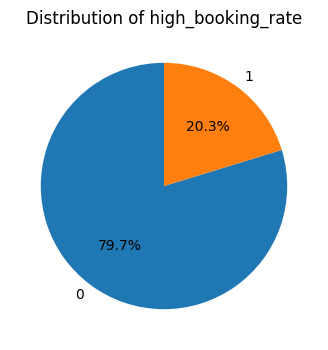

In [17]:
# 1. TARGET - high_booking_rate
# Count each class
counts = train_2['high_booking_rate'].value_counts().sort_index()

print("counts : ", counts)
# Plot
plt.figure(figsize=(4,4))
counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.ylabel('')                           # remove the default y‑label
plt.title('Distribution of high_booking_rate')
plt.show()

Nothing much to talk about the target right now. There are no missing value. Its highly imabalanced so we might have to deal with it later. I tried a weighted loss function last time but it over fitted the model. So it might be a good idea to try SMOTE.


--- host_acceptance_rate DESCRIBE ---
                        count      mean       std  min   25%  50%  75%  max
host_acceptance_rate  14002.0  0.903192  0.180738  0.0  0.88  1.0  1.0  1.0
Skewness: -2.601, Kurtosis: 7.546
Missing: 78065 (84.8%); Unique: 87


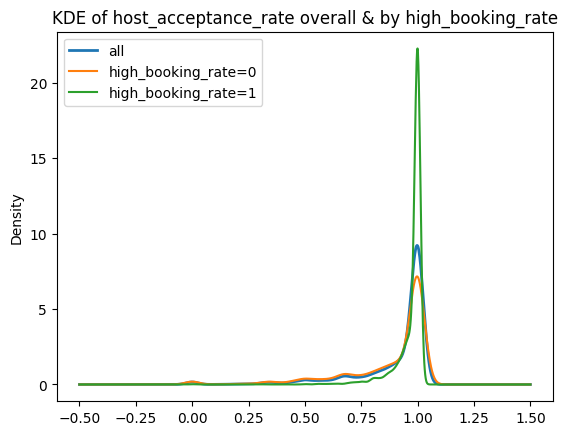

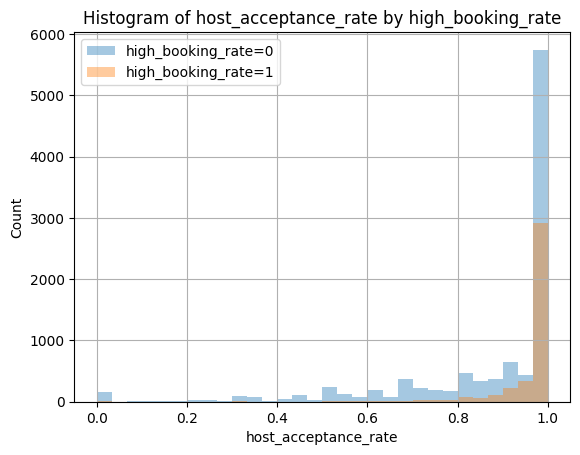

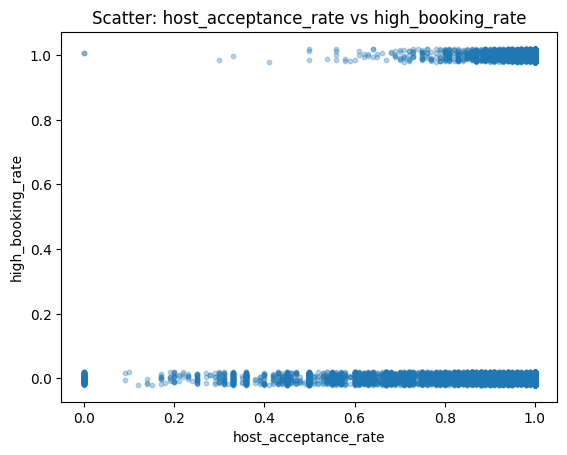


Top 3 correlated features with host_acceptance_rate:
                               corr
host_total_listings_count  0.237011
host_listings_count        0.222540
lat_long_product           0.205214


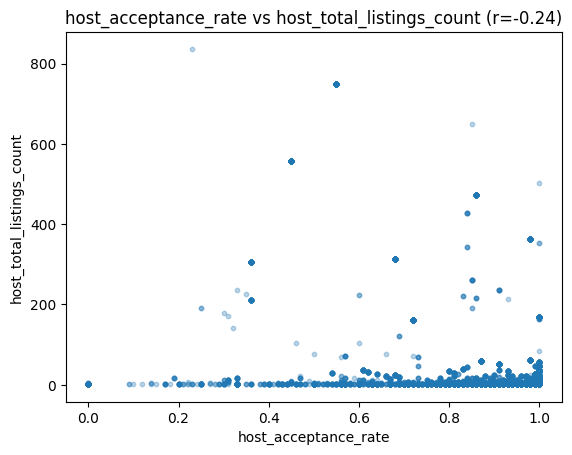

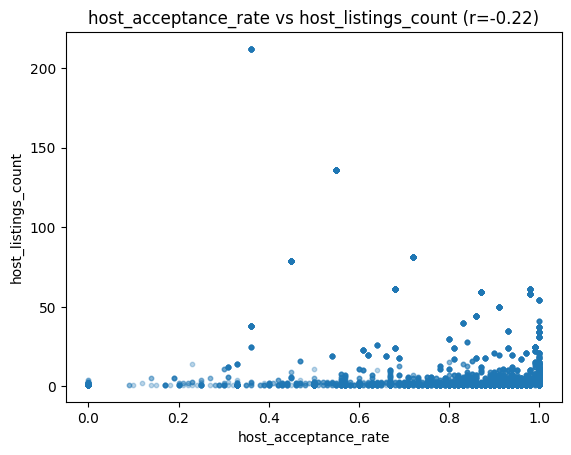

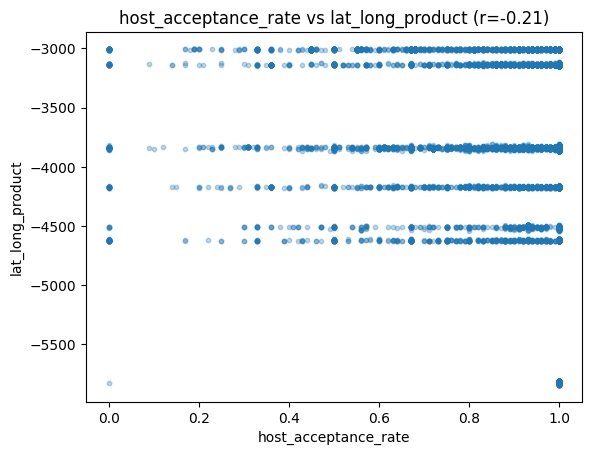

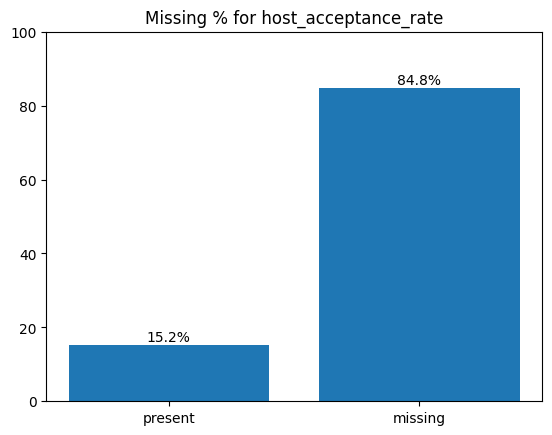


Outliers (<0.70 or >1.18): 1667 rows, 1.81%


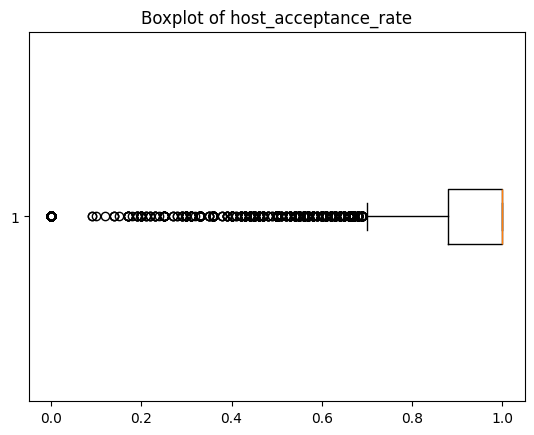

<Figure size 640x480 with 0 Axes>

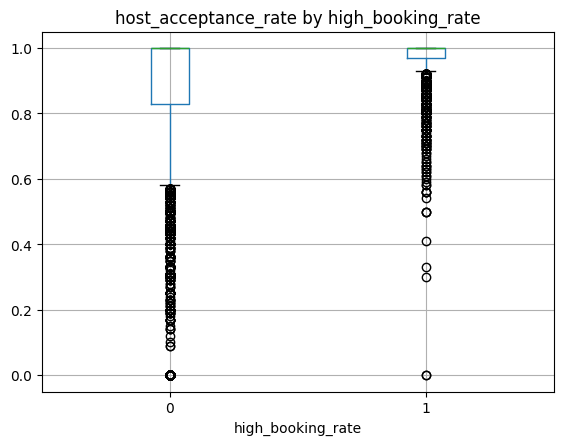


Point-biserial corr: r=0.232, p=7.68e-171
T-test: t=28.253, p=7.68e-171


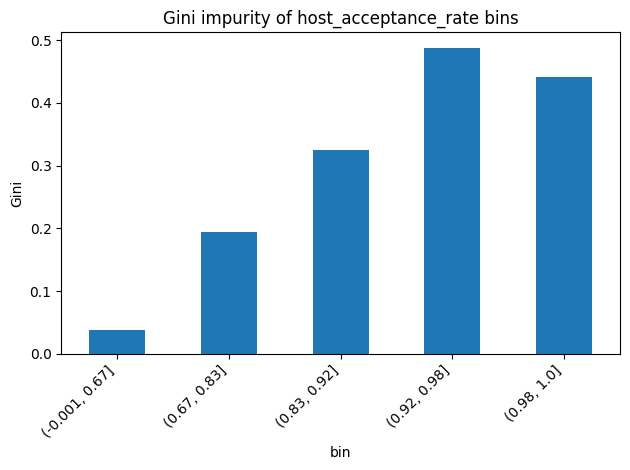

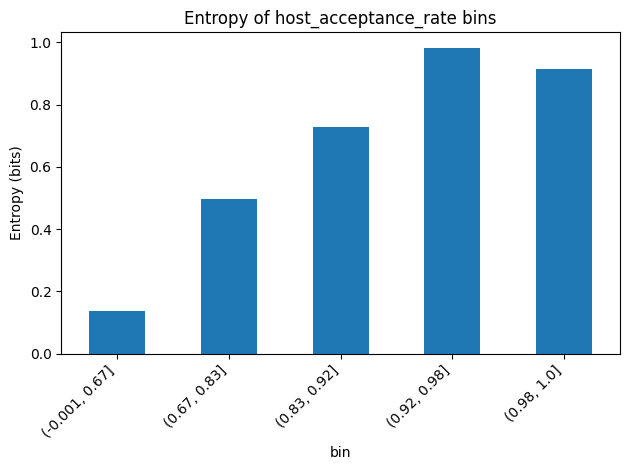

In [18]:
# 2. host_acceptance_rate - percent of stay requests the host accepts
# strip “%”, convert to float, and (optionally) scale to [0–1]
train_2['host_acceptance_rate'] = (
    train_2['host_acceptance_rate']
      .str.rstrip('%')
      .astype(float)
      .div(100)
)

test_x['host_acceptance_rate'] = (
    test_x['host_acceptance_rate']
      .str.rstrip('%')
      .astype(float)
      .div(100)
)

analyze_numeric(train_2, 'host_acceptance_rate', target='high_booking_rate')


Feature: 'host_acceptance_rate'
  → Missing: 78065 / 92067 rows (84.79%)


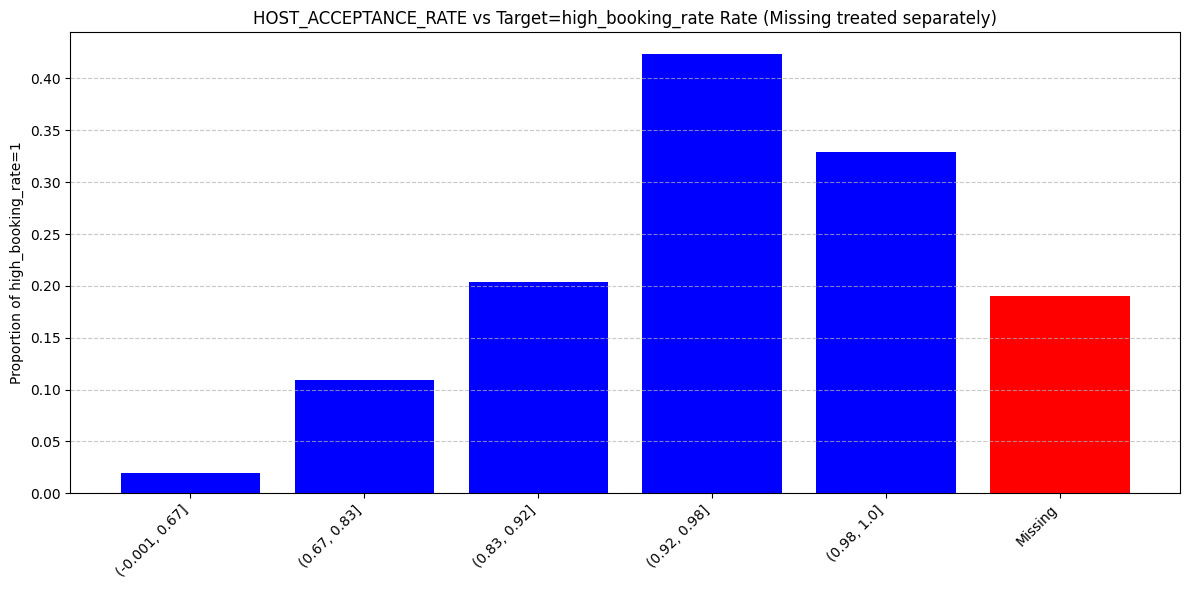

In [19]:
# Run analysis for "host_acceptance_rate"
analyze_missing_value_bin_trend(train_2, 'host_acceptance_rate')


Missing values clearly have signal and are not noise. we see that most missing value bin has a much lower propertion of high booking rate = 1. this could mean that missing values possibly refer to to people who havent hosted before or havent accept any req yet. We will keep this feature and instead bin them into 3 different groups as you will see below

In [20]:
# TRANSFORMATION - host_acceptance_rate
def bin_host_acceptance_rate(val):
    if pd.isna(val):
        return 0  # Missing
    elif val < 0.92:
        return 1  # Low acceptance rate
    else:
        return 2  # High acceptance rate

# Apply to your DataFrame
train_2['host_acceptance_rate_binned'] = train_2['host_acceptance_rate'].apply(bin_host_acceptance_rate).astype(int)
train_2 = train_2.drop(columns=['host_acceptance_rate'])

test_x['host_acceptance_rate_binned'] = test_x['host_acceptance_rate'].apply(bin_host_acceptance_rate).astype(int)
test_x = test_x.drop(columns=['host_acceptance_rate'])


--- jurisdiction_names ---
Unique: 26
Missing: 46986 (51.0%)

Top categories:
 jurisdiction_names
NaN                                                                                          46986
City of Los Angeles, CA                                                                      14356
SAN FRANCISCO                                                                                 5993
DISTRICT OF COLUMBIA, WASHINGTON                                                              4932
Louisiana State, New Orleans, LA                                                              4008
Illinois State, Cook County, IL, CHICAGO                                                      3951
SAN DIEGO, SAN DIEGO TOURISM MARKETING DISTRICT A, SAN DIEGO TOURISM MARKETING DISTRICT B     3919
OREGON, MULTNOMAH, PORTLAND                                                                   2861
WASHINGTON                                                                                    2854
OAKLAND   

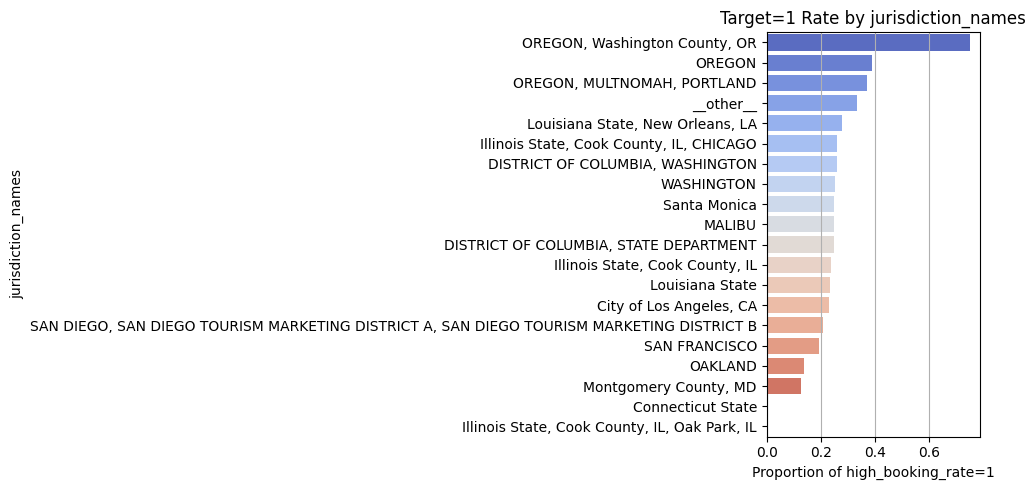

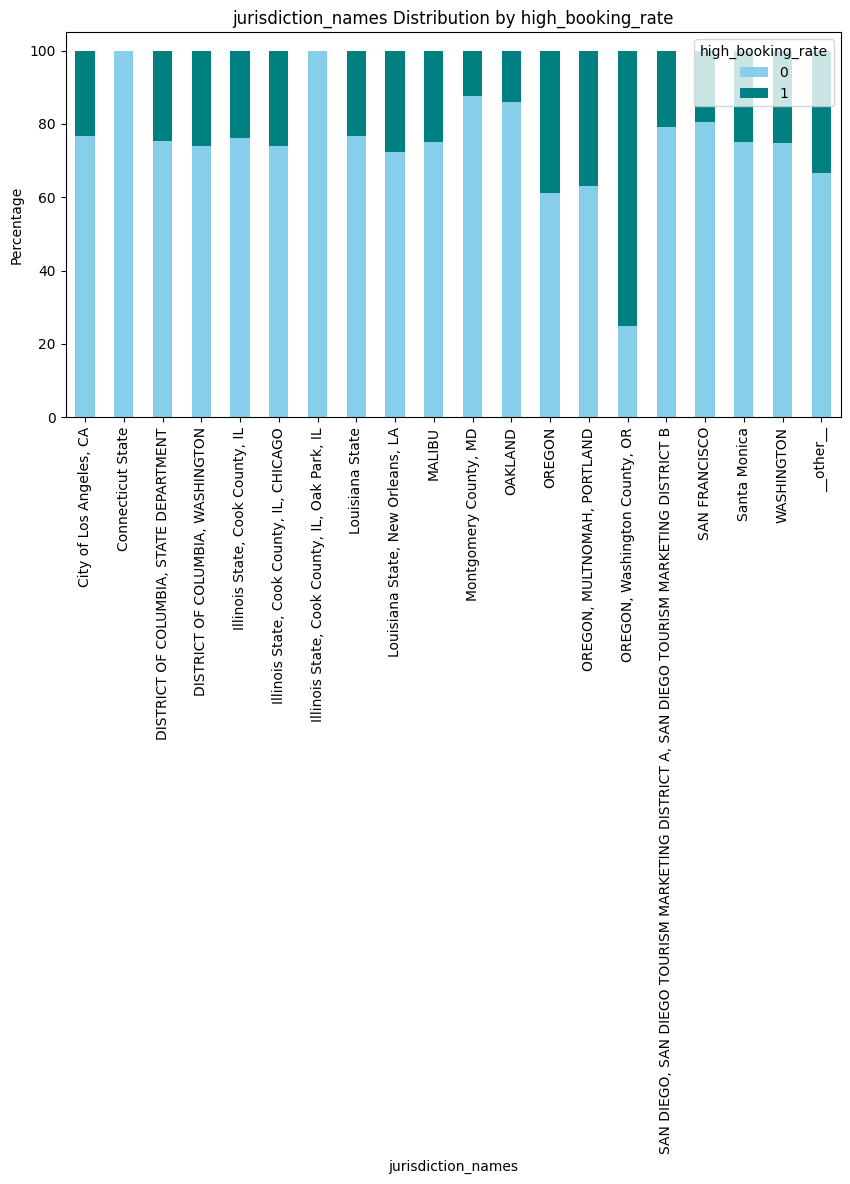

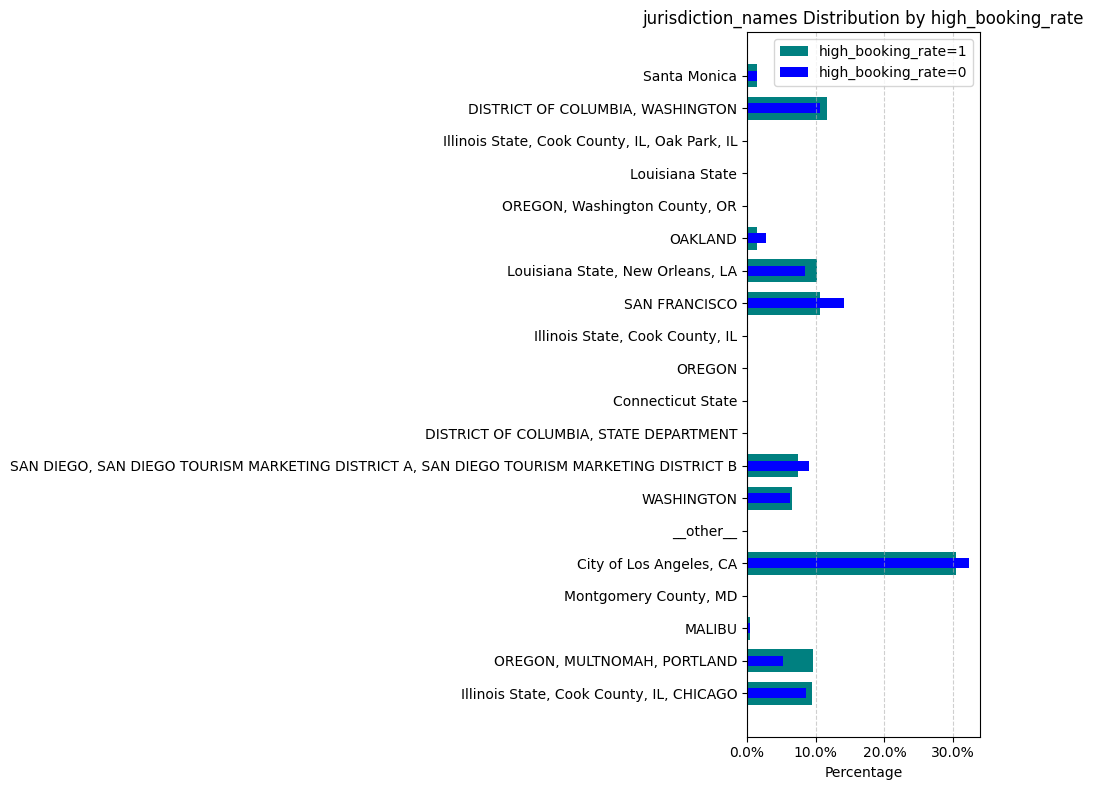

Chi-square test: χ²=479.95, dof=19, p=0.0000


In [21]:
# 3. jurisdiction_names - the legal jurisdiction that the listing falls under

analyze_categorical(train_2, 'jurisdiction_names')

# Dropping jurisdiction_names
train_2 = train_2.drop(columns=['jurisdiction_names'])
test_x = test_x.drop(columns=['jurisdiction_names'])

Even though according to EDA, this feature does have some relation with target, I am going to drop it. Reason being, this has very high cardinality - 26 unique values, one hot encoding them would increase feature dimensionality a lot. A stronger reason is probably gut feeling about city and location related columns as I feel the hidden dataset might have a very differnt distribution of location and my model might not be able to generalize better. So I am gona drop most location related columns. Except maybe lat long because I want to try Harinis method with those 2 columns


--- license ---
Unique: 2878
Missing: 83919 (91.1%)

Top categories:
 license
NaN                                             83919
City registration pending                        4621
City Registration Pending                          33
145636                                             30
Pending                                            20
city registration pending                          17
154316                                             15
PENDING                                            14
pending                                            13
108415                                             11
151934                                              8
2245608                                             7
682995                                              7
17STR-06576                                         6
STR-0001791                                         6
105021713                                           6
17STR-05710                                         6
141

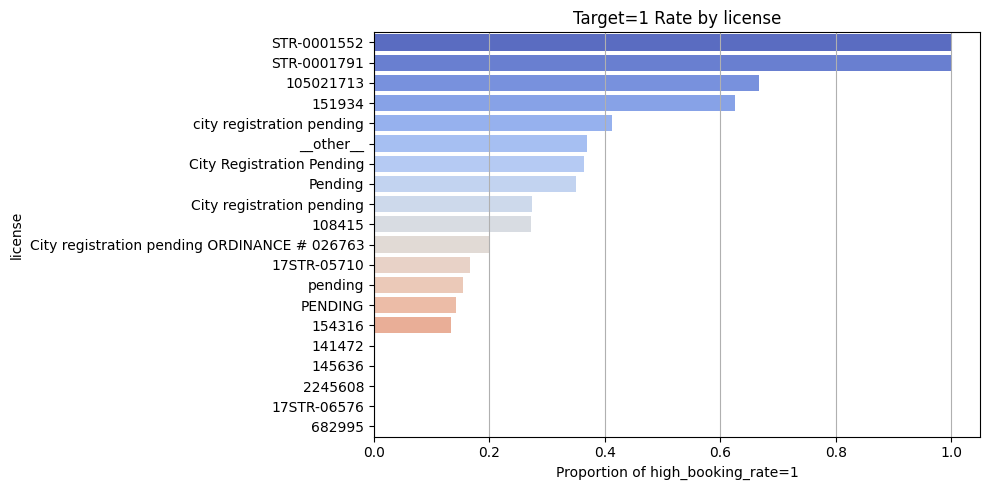

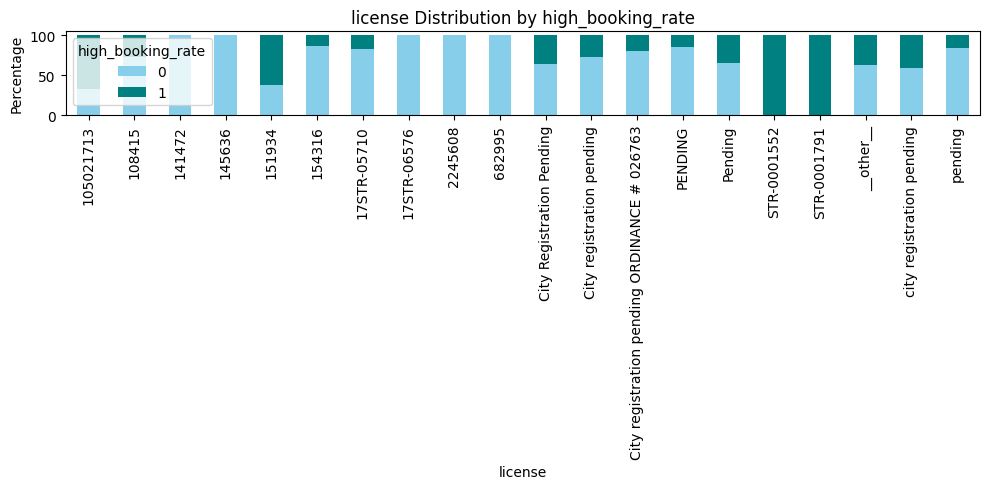

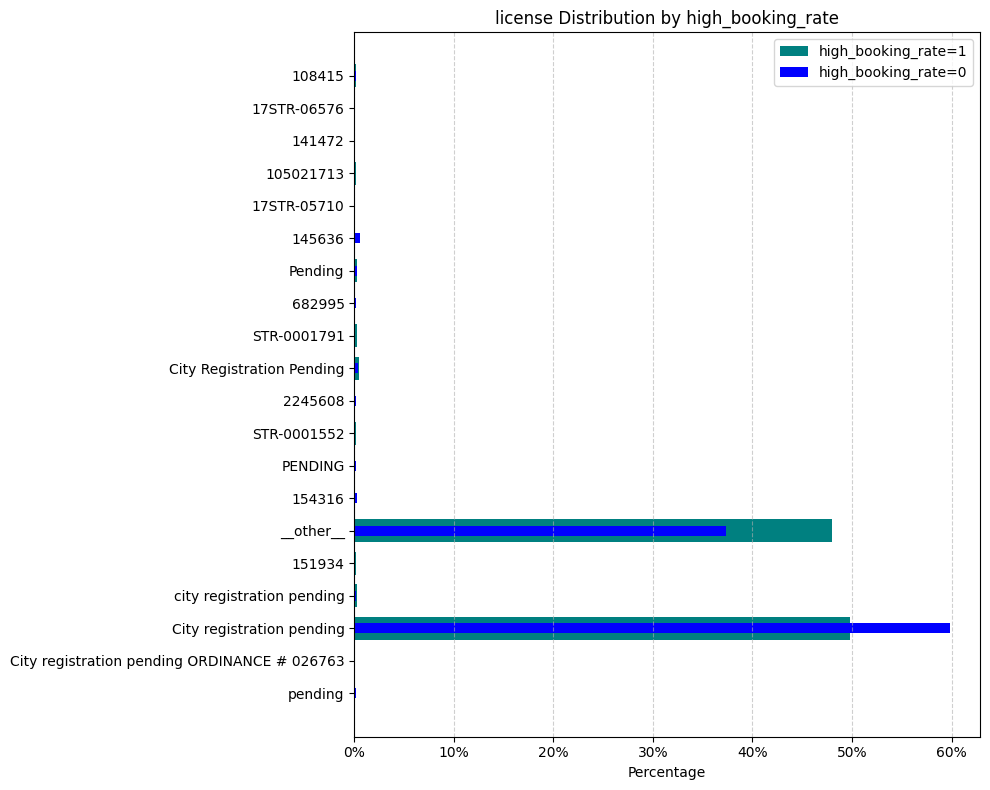

Chi-square test: χ²=144.43, dof=19, p=0.0000
Feature: 'license'
  → Missing: 83919 / 92067 rows (91.15%)
  → Unique (non-missing): 2877


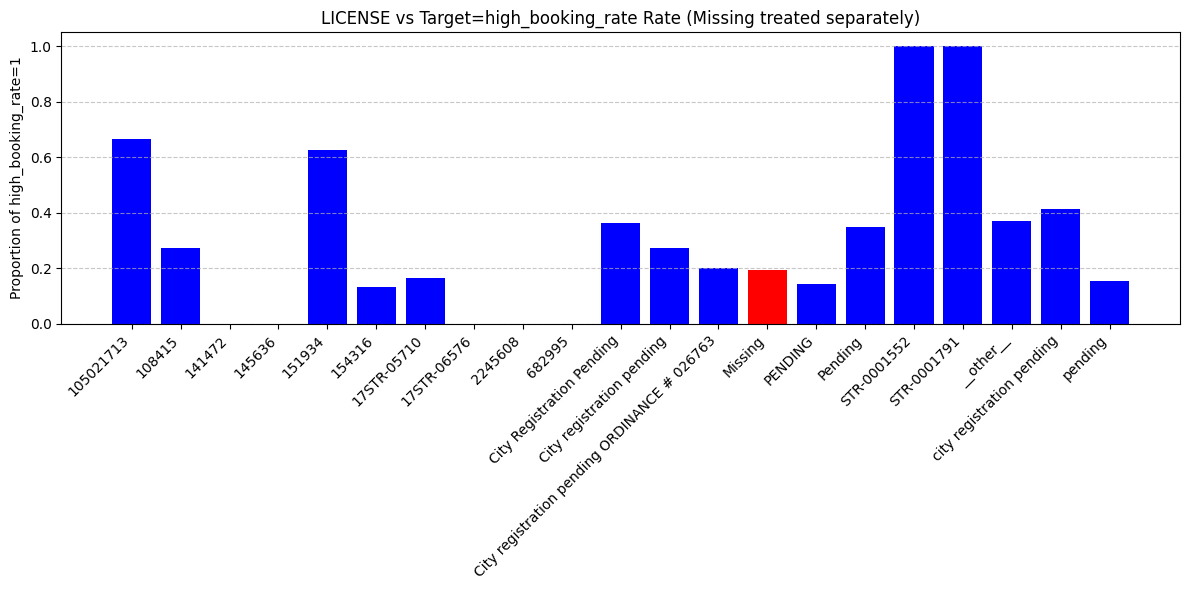

In [22]:
# 4. license - whether the host has a hotelier license (t) or not (f)

analyze_categorical(train_2, 'license')
analyze_categorical_missing_bin_trend(train_2, 'license')

Just going to drop license. 8% fill rate is too much trouble to deal with.  

In [23]:
# Dropping license
train_2 = train_2.drop(columns=['license'])
test_x = test_x.drop(columns=['license'])


--- monthly_price DESCRIBE ---
                 count        mean          std  min     25%     50%     75%  \
monthly_price  22430.0  3128.90535  2965.364621  0.0  1575.0  2400.0  3600.0   

                   max  
monthly_price  60000.0  
Skewness: 6.091, Kurtosis: 69.103
Missing: 69637 (75.6%); Unique: 1800


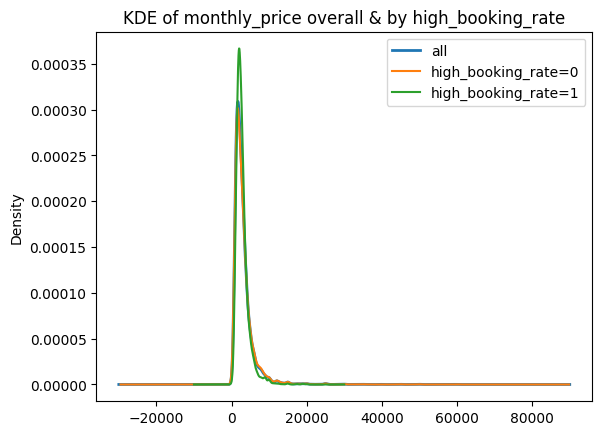

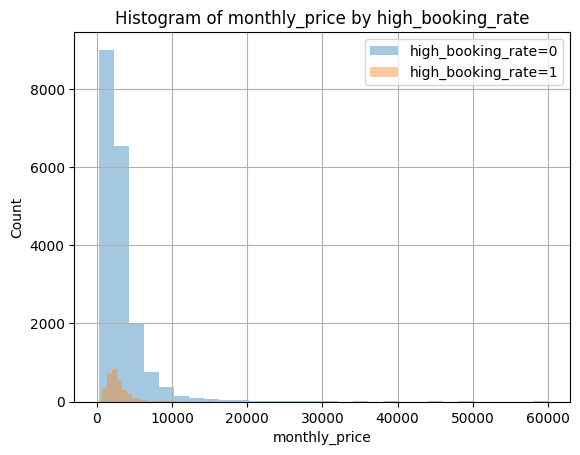

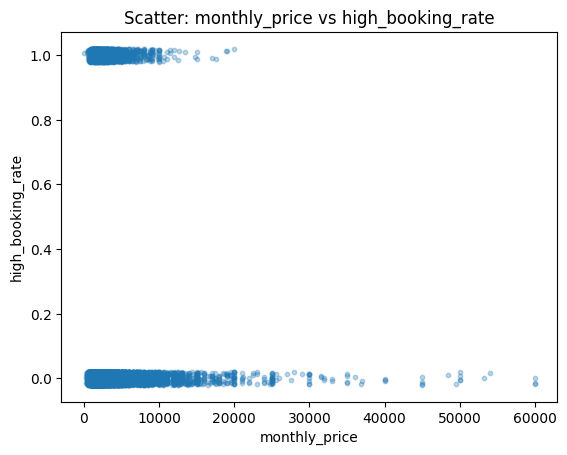


Top 3 correlated features with monthly_price:
                  corr
weekly_price  0.827358
price         0.820163
cleaning_fee  0.659679


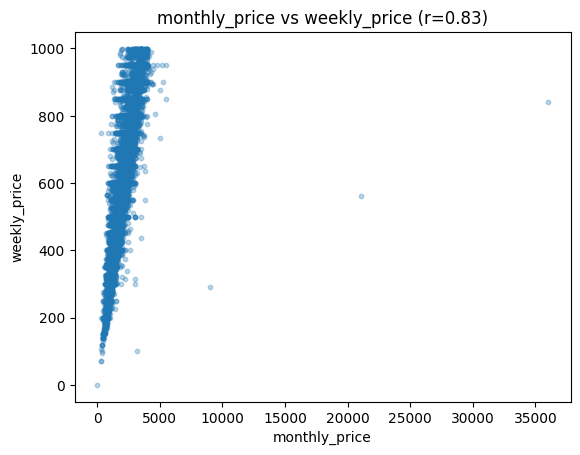

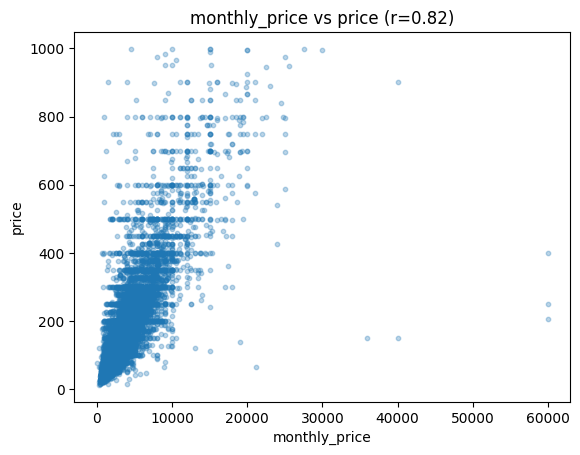

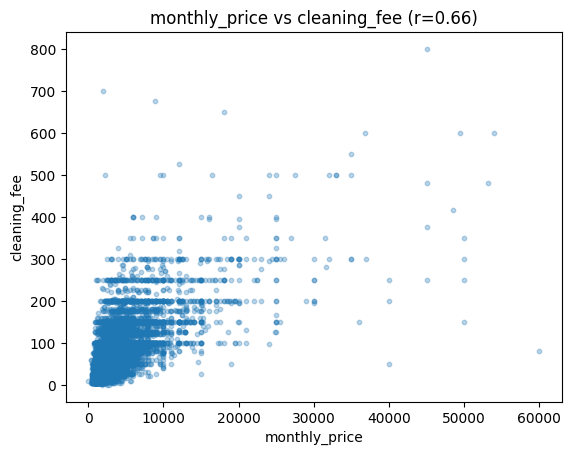

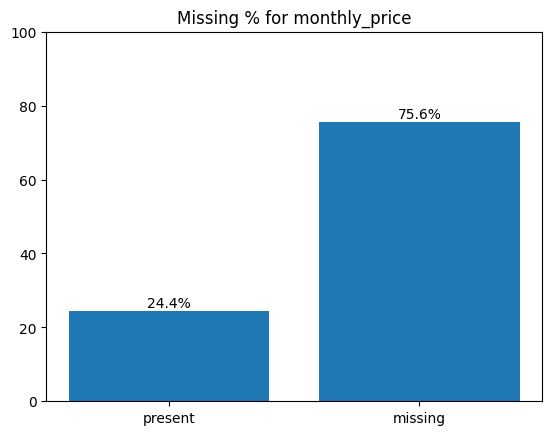


Outliers (<-1462.50 or >6637.50): 1531 rows, 1.66%


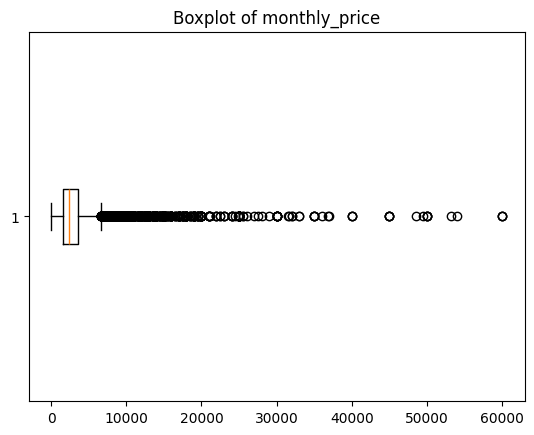

<Figure size 640x480 with 0 Axes>

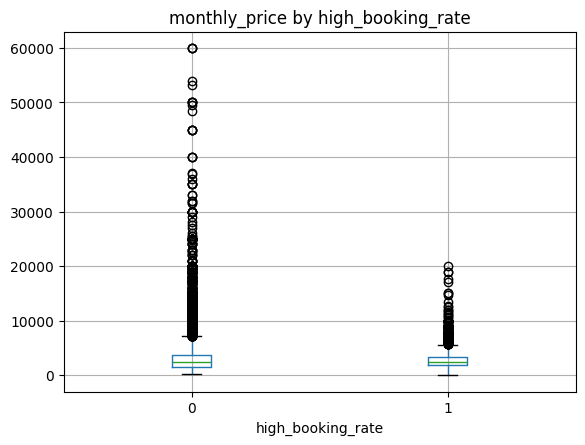


Point-biserial corr: r=-0.044, p=4.67e-11
T-test: t=-6.584, p=4.67e-11


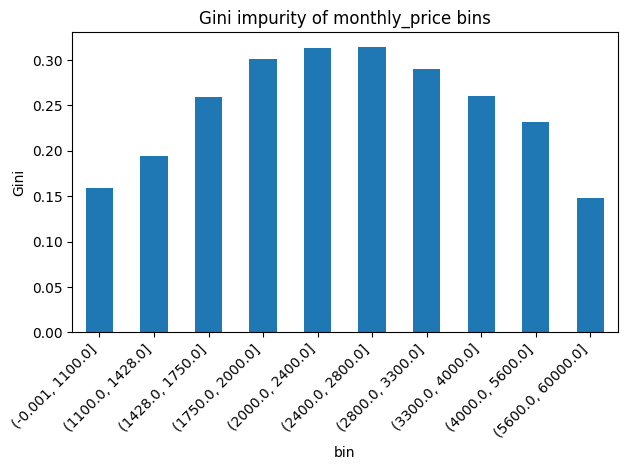

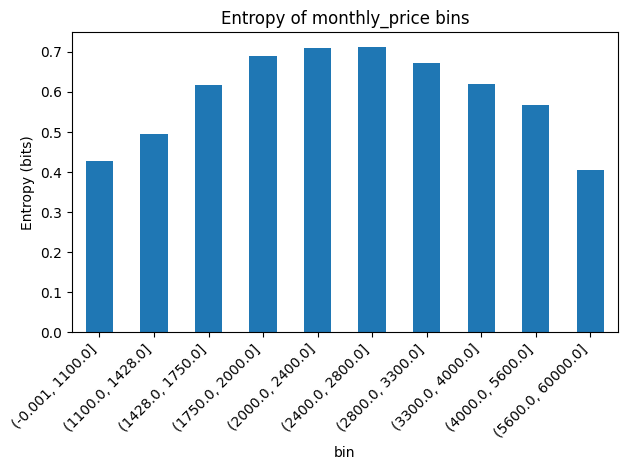

Feature: 'monthly_price'
  → Missing: 69637 / 92067 rows (75.64%)


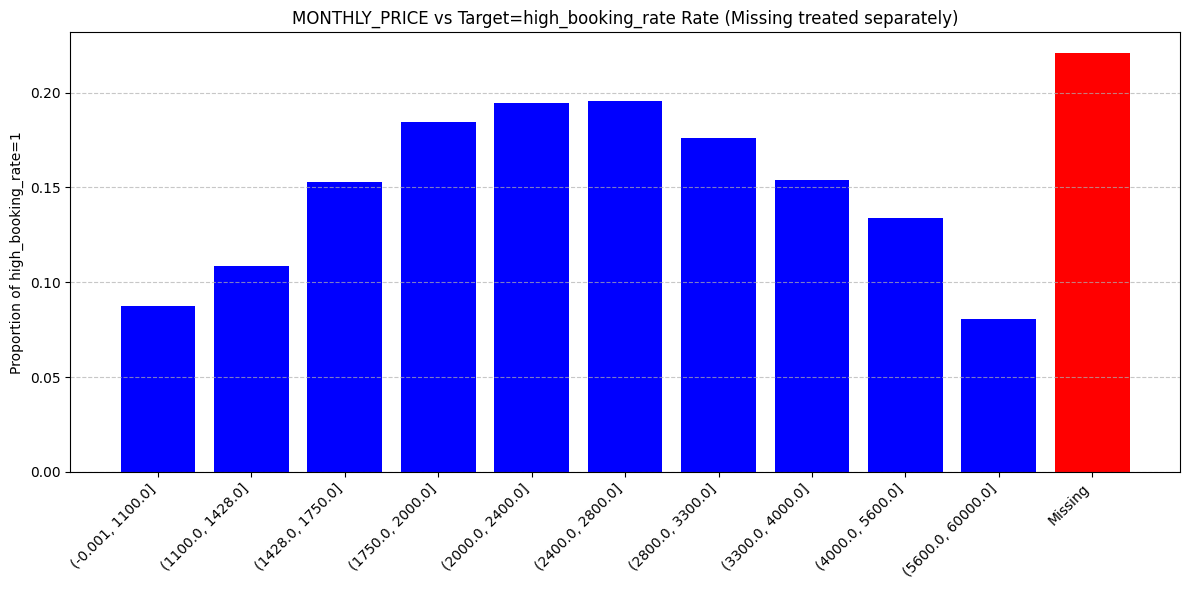

In [24]:
# 5. monthly_price - price to rent the listing for a month

analyze_numeric(train_2, 'monthly_price')
analyze_missing_value_bin_trend(train_2, 'monthly_price')


# Dropping monthly_price
train_2 = train_2.drop(columns=['monthly_price'])
test_x = test_x.drop(columns=['monthly_price'])

Not too much predictive power. Skew: 6.09 → Extreme right skew (long tail)

Kurtosis: 69.1 → Very peaked and heavy tails → dangerous for modeling unless normalized or binned

Missing: 75.6% → Very high → the absence of a monthly price might mean "not intended for monthly rent"

more over - very high correlation with 3 other variables which have high fill rate. I dont want to keep this and cause collinearity issues in case I try Neural networks. Xgboost would discard this by default. So i am dropping :)


--- neighborhood_group ---
Unique: 23
Missing: 61376 (66.7%)

Top categories:
 neighborhood_group
NaN                    61376
Manhattan              13234
Brooklyn               11420
Queens                  2595
Other neighborhoods      595
Bronx                    419
Capitol Hill             415
Downtown                 408
Central Area             283
Queen Anne               229
Ballard                  170
Staten Island            169
West Seattle             140
Rainier Valley           118
Beacon Hill               94
University District       87
Delridge                  61
Cascade                   59
Northgate                 57
Lake City                 50
Name: count, dtype: int64


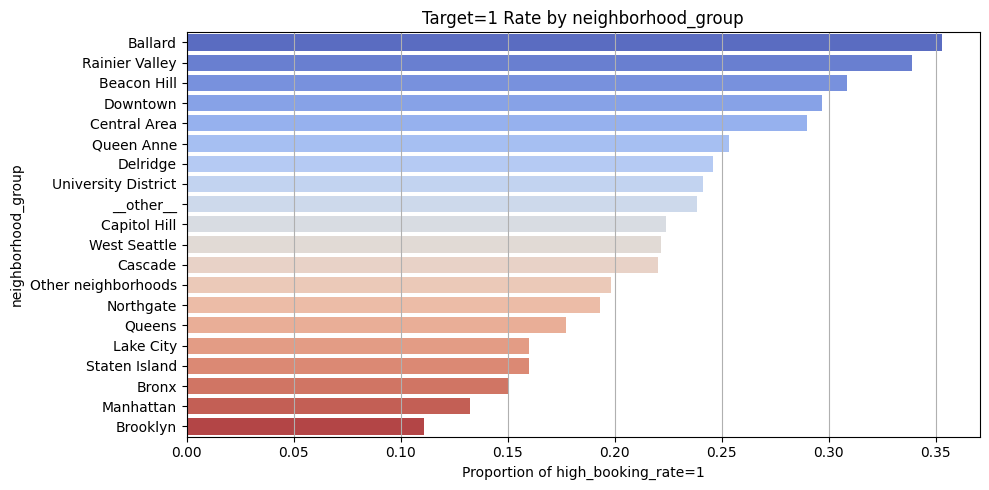

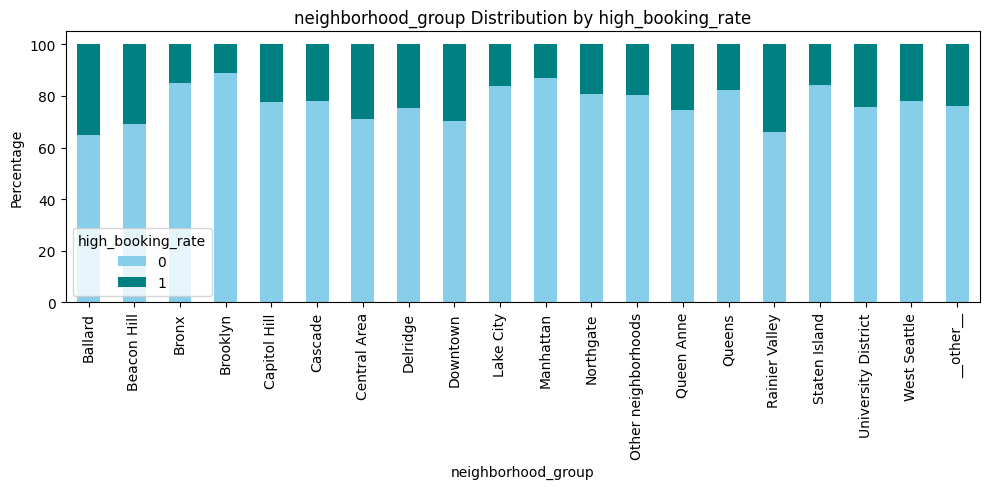

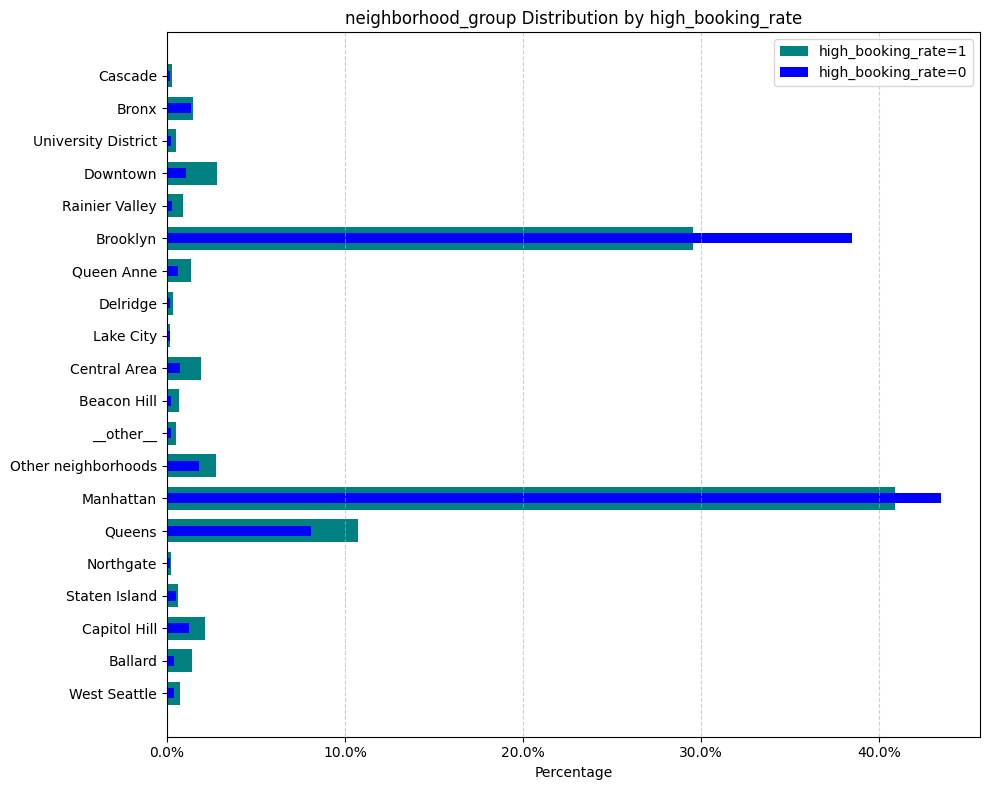

Chi-square test: χ²=476.43, dof=19, p=0.0000
Feature: 'neighborhood_group'
  → Missing: 61376 / 92067 rows (66.66%)
  → Unique (non-missing): 22


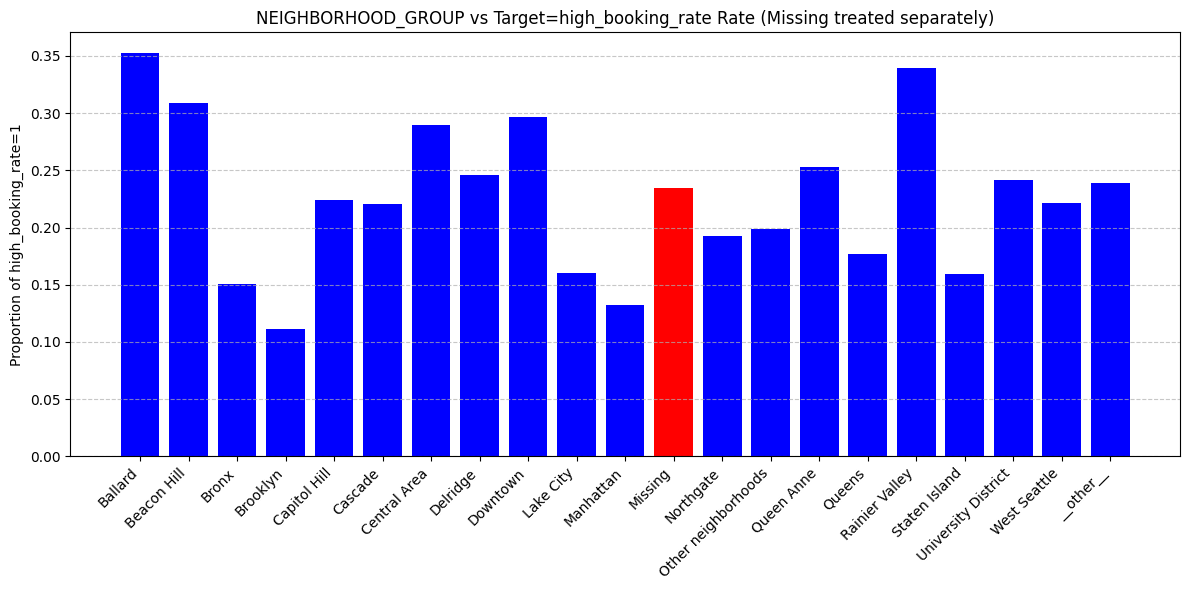

In [25]:
# 6. neighborhood_group - corase-grained neighborhood name of the listing
analyze_categorical(train_2, 'neighborhood_group')
analyze_categorical_missing_bin_trend(train_2, 'neighborhood_group')

# Dropping neighborhood_group - no location related features now
train_2 = train_2.drop(columns=['neighborhood_group'])
test_x = test_x.drop(columns=['neighborhood_group'])


--- security_deposit DESCRIBE ---
                    count        mean         std  min    25%    50%    75%  \
security_deposit  42910.0  272.012398  165.804941  0.0  150.0  249.0  400.0   

                    max  
security_deposit  999.0  
Skewness: 1.008, Kurtosis: 0.630
Missing: 49157 (53.4%); Unique: 243


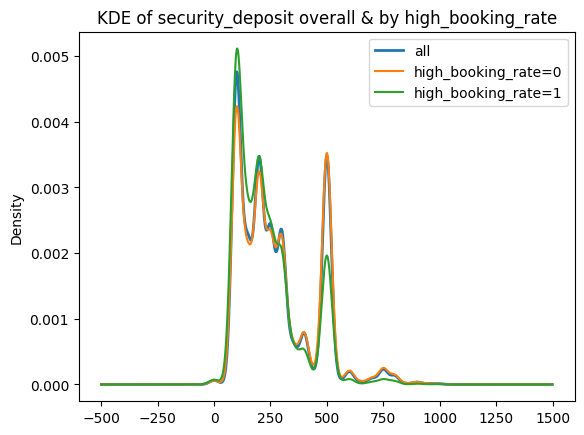

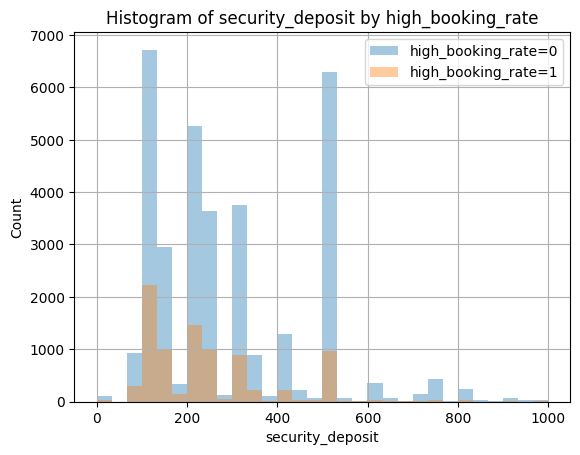

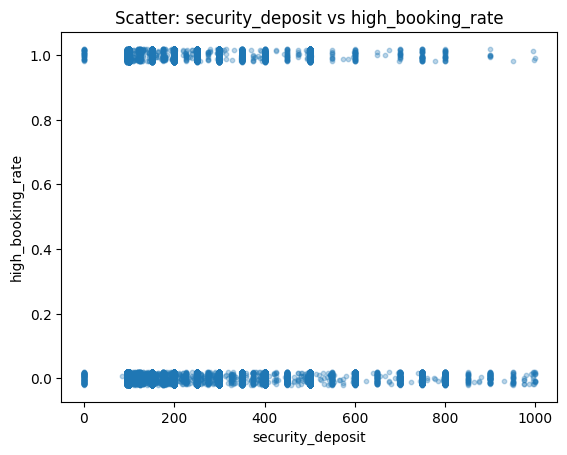


Top 3 correlated features with security_deposit:
                  corr
cleaning_fee  0.470656
price         0.403323
bedrooms      0.295312


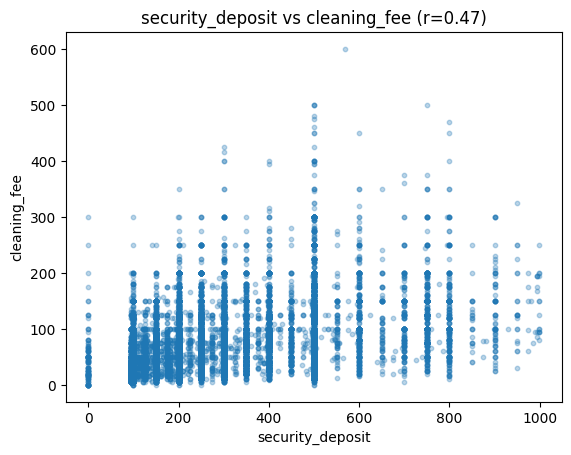

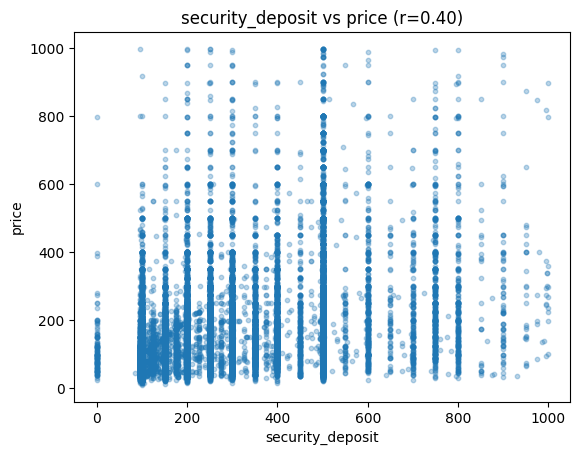

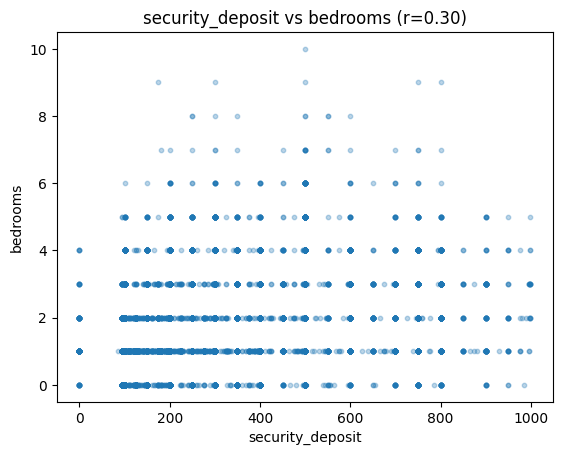

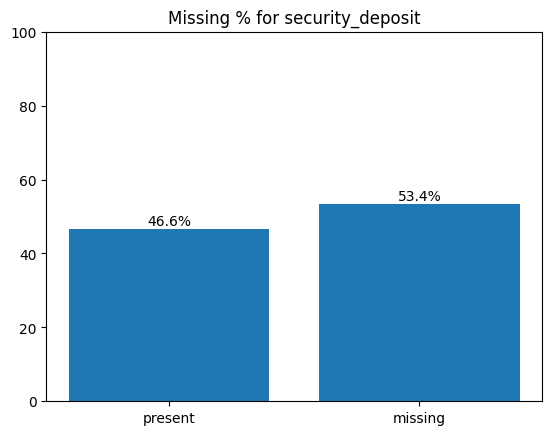


Outliers (<-225.00 or >775.00): 430 rows, 0.47%


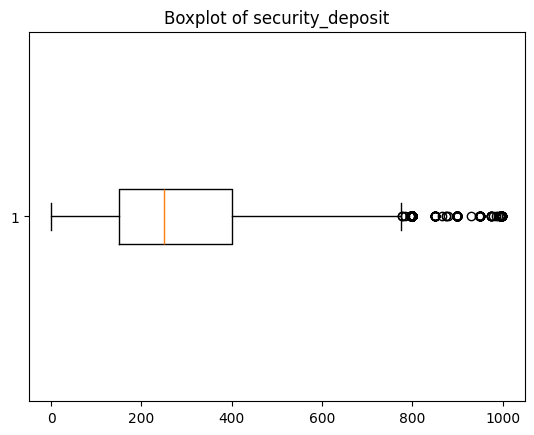

<Figure size 640x480 with 0 Axes>

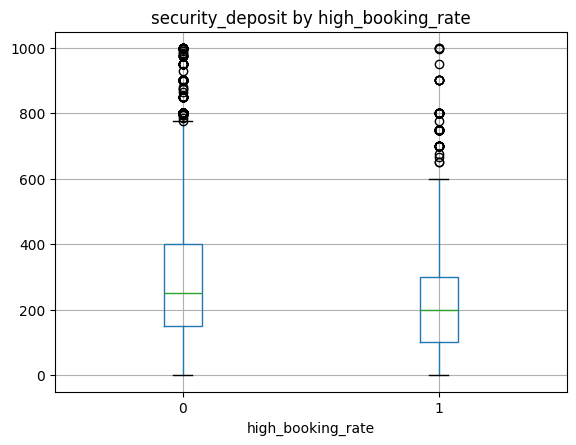


Point-biserial corr: r=-0.117, p=4.75e-130
T-test: t=-24.347, p=4.75e-130


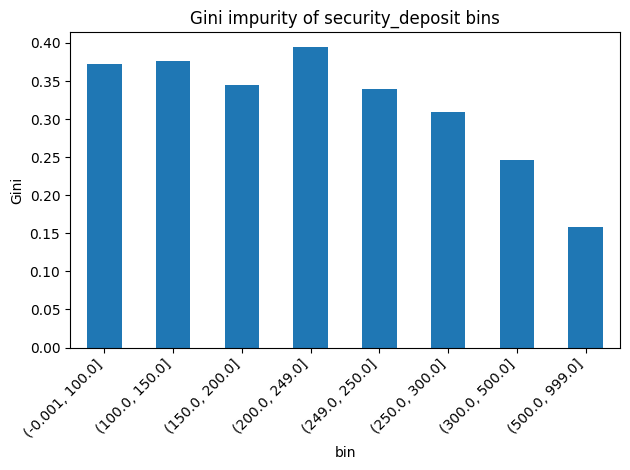

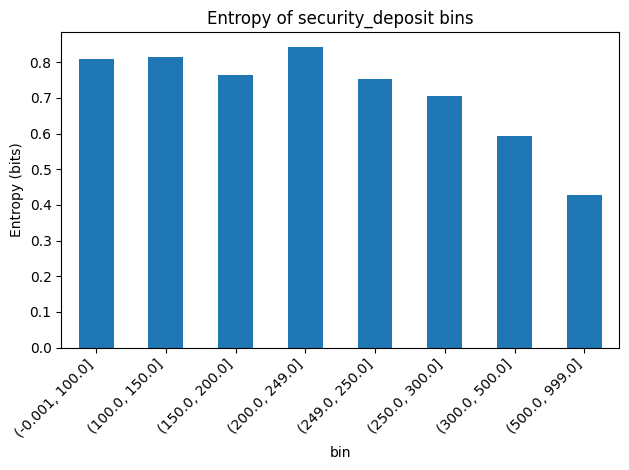

Feature: 'security_deposit'
  → Missing: 49157 / 92067 rows (53.39%)


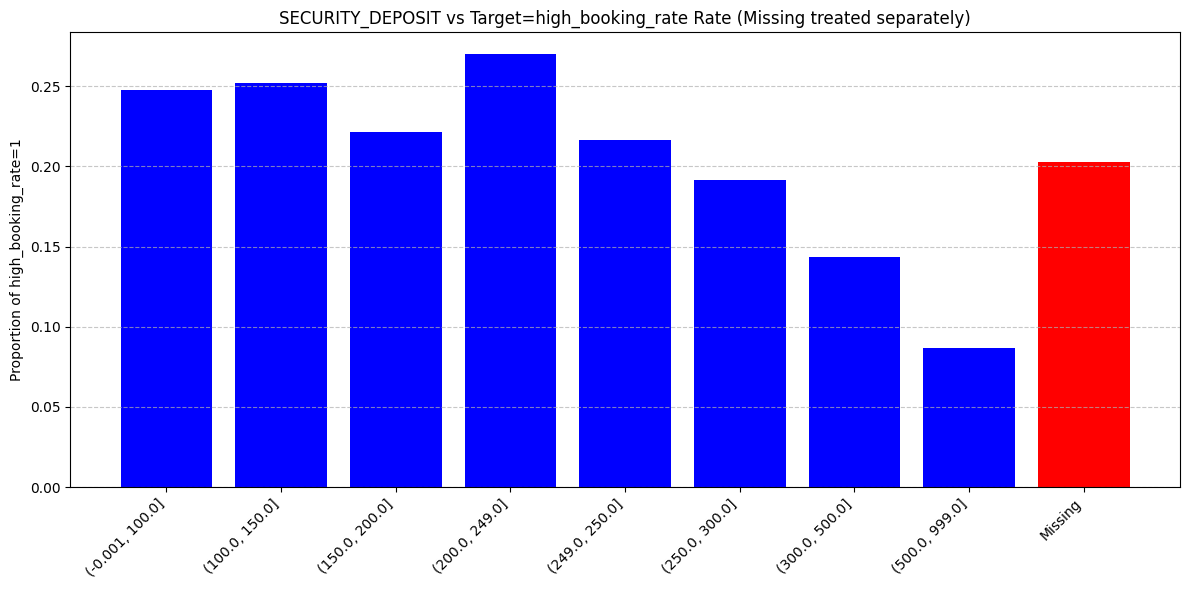

In [26]:
# 7. security_deposit - the amount of security deposit required to rent the listing

analyze_numeric(train_2, 'security_deposit')
analyze_missing_value_bin_trend(train_2, 'security_deposit')

 ##### KDE & Histogram:
Clear multi-modal distribution (peaks at common deposit amounts: 0, 200, 250, 500)

Distribution differs a bit by class: higher deposits slightly skew toward low booking rate (target=0)

Not heavily skewed (skew = 1.0, kurtosis = 0.6 → relatively normal-ish)

##### Gini Plot + Target Rate by Bin:
Gini ranges from ~0.15 to ~0.4 → that's not bad, shows informative segmentation

Highest booking rates in lower bins (especially 200–250 and below)

Booking rate clearly drops as deposit goes higher

Interestingly, missing values have high booking rates too

Top 3 correlations: cleaning_fee, price, bedrooms — but none are above 0.5, so not a red flag for collinearity

In [27]:
# TRANSFORMATION - security_deposit

# Bin the feature (from your Gini binning)
train_2['security_deposit_binned'] = pd.cut(
    train_2['security_deposit'],
    bins=[0, 100, 150, 200, 249, 250, 300, 500, 999]
).astype(str)


# Handle missing
train_2.loc[train_2['security_deposit'].isna(), 'security_deposit_binned'] = 'Missing'


# Convert to categorical then get category codes
train_2['security_deposit_binned'] = train_2['security_deposit_binned'].astype('category')
train_2['security_deposit_binned_encoded'] = train_2['security_deposit_binned'].cat.codes

train_2 = train_2.drop(columns=[
    'security_deposit',
    'security_deposit_binned',
])

# for test set

test_x['security_deposit_binned'] = pd.cut(
    test_x['security_deposit'],
    bins=[0, 100, 150, 200, 249, 250, 300, 500, 999]
).astype(str)


# Handle missing
test_x.loc[test_x['security_deposit'].isna(), 'security_deposit_binned'] = 'Missing'


# Convert to categorical then get category codes
test_x['security_deposit_binned'] = test_x['security_deposit_binned'].astype('category')
test_x['security_deposit_binned_encoded'] = test_x['security_deposit_binned'].cat.codes

test_x = test_x.drop(columns=[
    'security_deposit',
    'security_deposit_binned',
])


In [28]:
# 7. square_feet - how many square feet the listing is

# dropping square_feet - 1.8% fillrate
train_2 = train_2.drop(columns=['square_feet'])
test_x = test_x.drop(columns=['square_feet'])


--- weekly_price DESCRIBE ---
                count        mean         std  min    25%    50%    75%    max
weekly_price  18511.0  574.193074  203.385784  0.0  400.0  560.0  732.0  999.0
Skewness: 0.156, Kurtosis: -0.881
Missing: 73556 (79.9%); Unique: 645


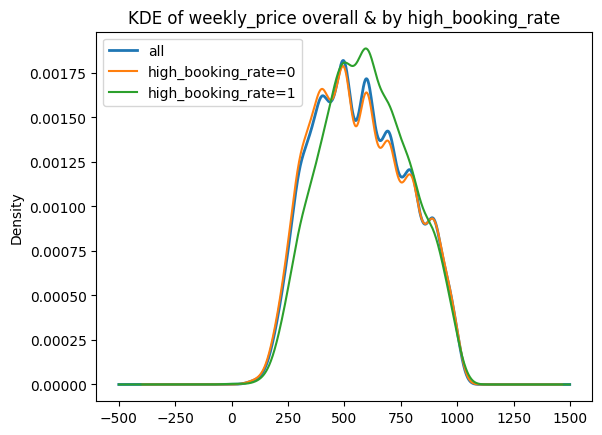

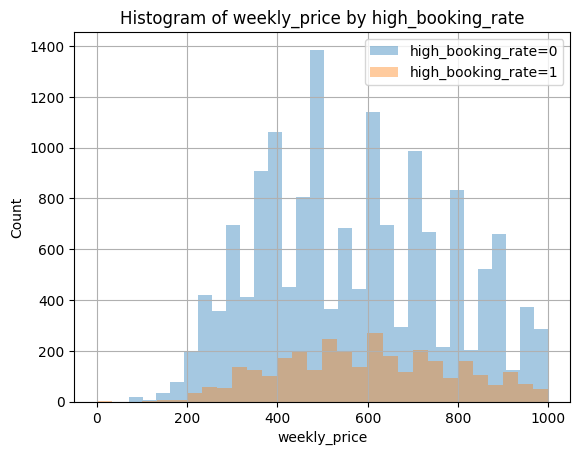

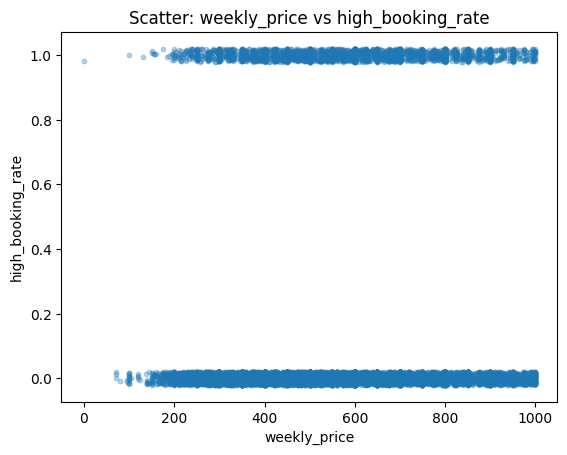


Top 3 correlated features with weekly_price:
                       corr
price              0.668300
price_per_bedroom  0.545365
price_x_guests     0.458771


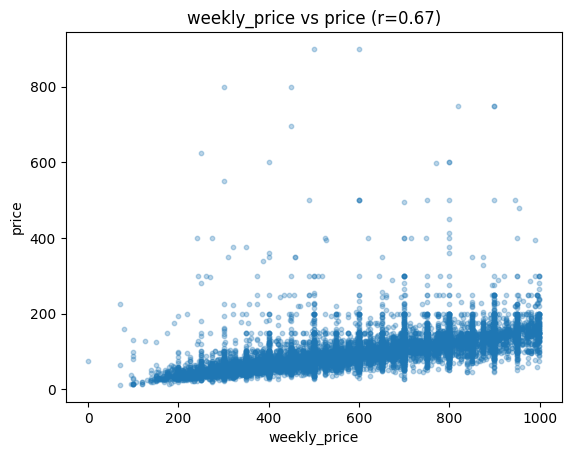

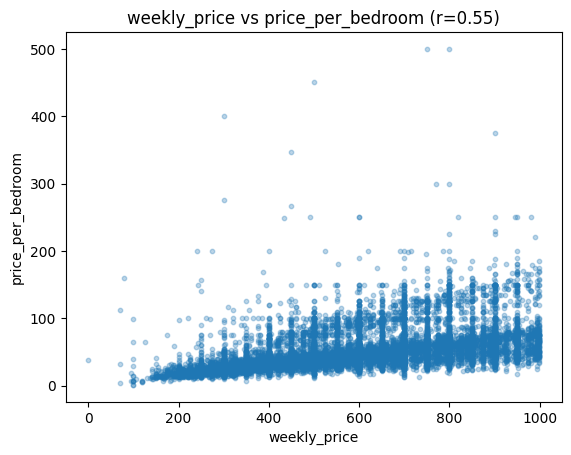

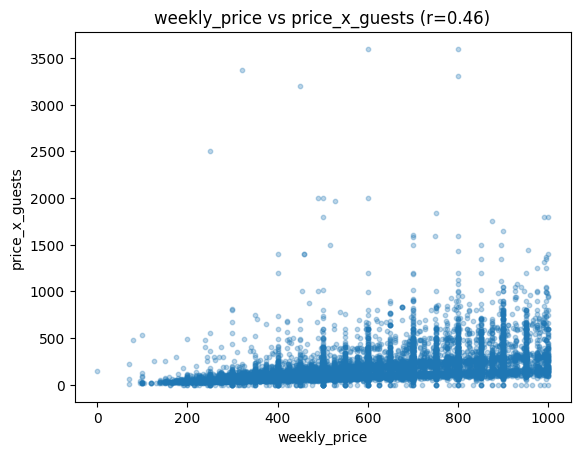

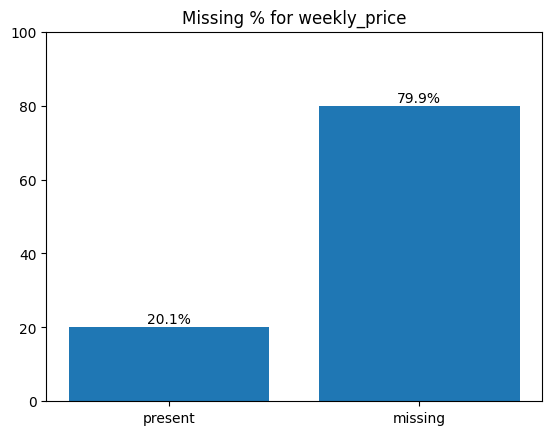


Outliers (<-98.00 or >1230.00): 0 rows, 0.00%


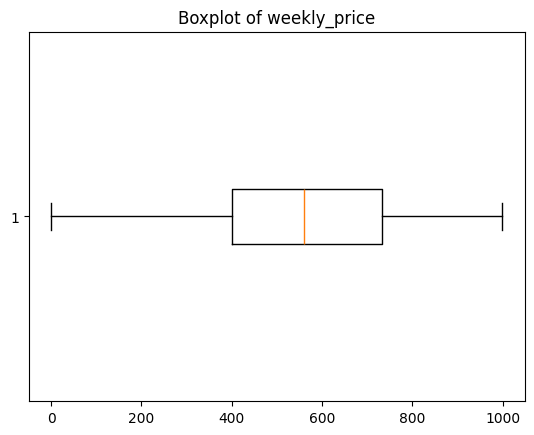

<Figure size 640x480 with 0 Axes>

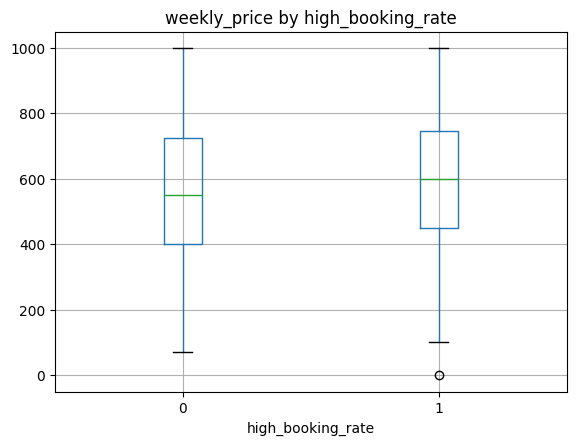


Point-biserial corr: r=0.044, p=3.02e-09
T-test: t=5.933, p=3.02e-09


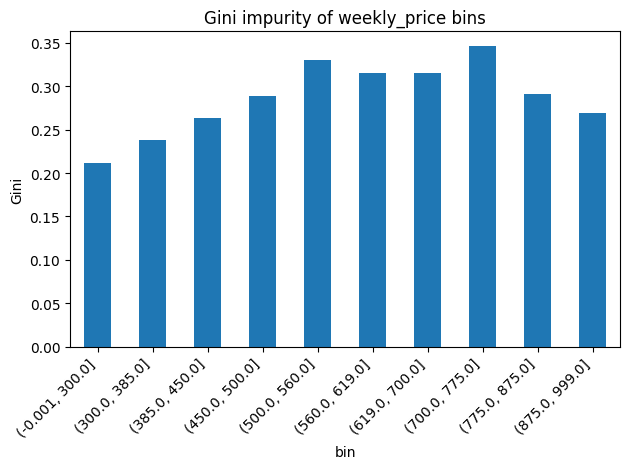

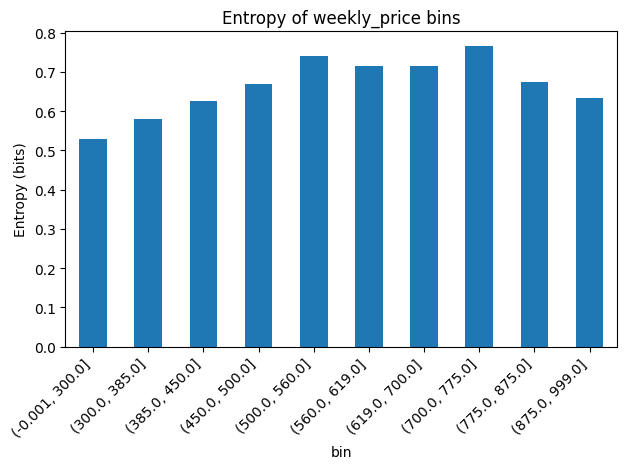

Feature: 'weekly_price'
  → Missing: 73556 / 92067 rows (79.89%)


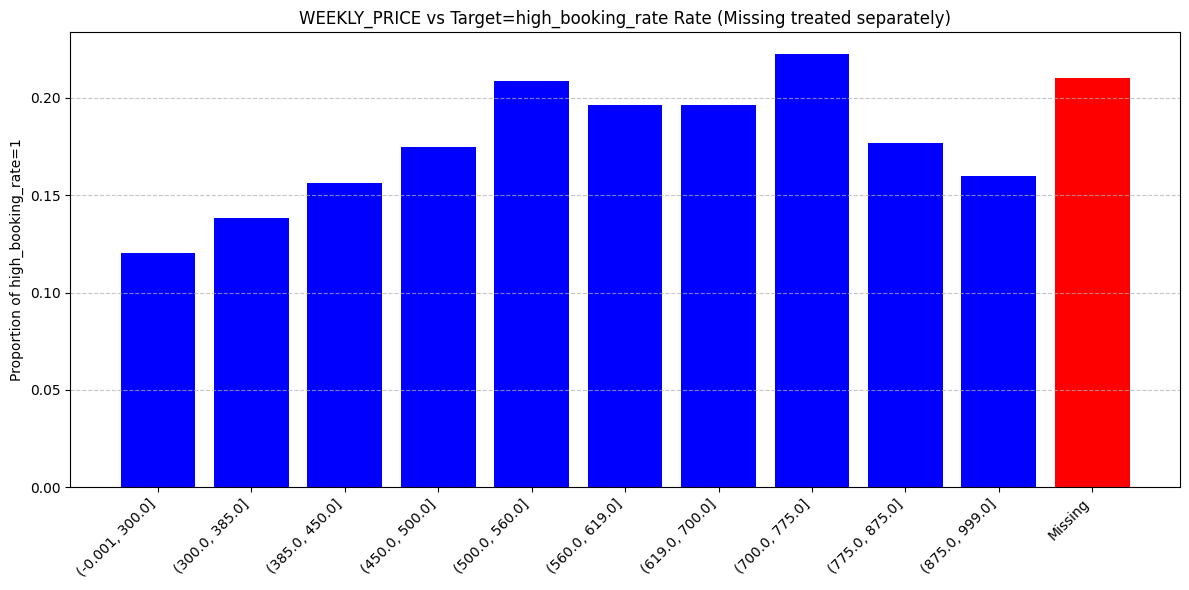

In [29]:
# 8. weekly_price - price to rent the listing for a week

analyze_numeric(train_2, 'weekly_price')
analyze_missing_value_bin_trend(train_2, 'weekly_price')


# dropping weekly_price
train_2 = train_2.drop(columns=['weekly_price'])
test_x = test_x.drop(columns=['weekly_price'])

📈 KDE + Histogram
Very normal-looking distribution, centered around 500–700

Slightly higher density for high_booking_rate=1 near 600–700 — but subtle

📊 Target Rate by Bin
Booking rate increases steadily with weekly_price up to 700–875

Missing values show one of the highest booking rates (just like monthly_price)

📊 Gini Impurity
Ranges from ~0.21 to ~0.36 — moderate class separation

Best bins are mid- to upper-range (450–775)

High correlation with price and very little predictive power (separation) as per gini impurity.
While the missing value with high booking rate is interesting, but its too large a set (80%) to actually impute it and use it. might give the model bias towards missing values and fail to generalise. I am gonna drop it

In [30]:
# 9. zipcode - zipcode of the listing

#dropping because no location policy

train_2 = train_2.drop(columns=['zipcode'])
test_x = test_x.drop(columns=['zipcode'])


--- price DESCRIBE ---
         count        mean         std  min   25%    50%    75%    max
price  91534.0  146.636922  121.085563  0.0  75.0  110.0  175.0  999.0
Skewness: 2.767, Kurtosis: 10.622
Missing: 533 (0.6%); Unique: 695


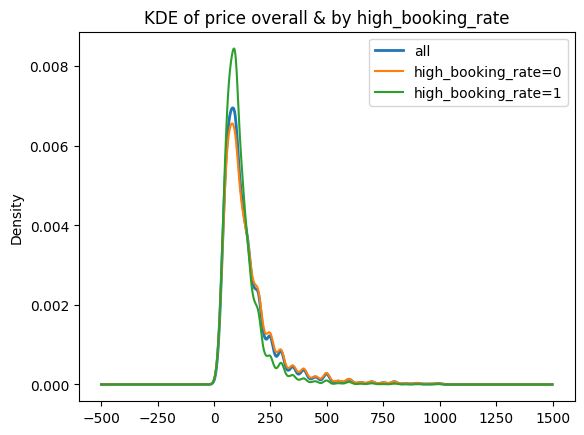

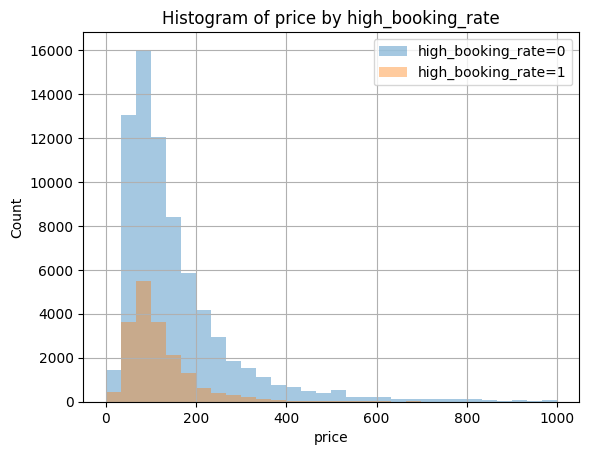

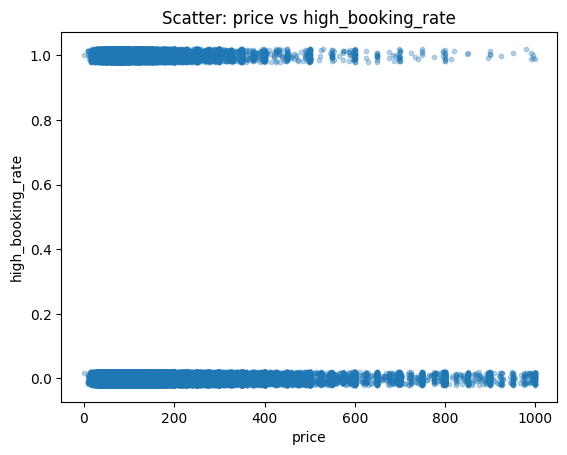


Top 3 correlated features with price:
                       corr
price_x_avail      0.730147
price_per_bedroom  0.711014
price_per_guest    0.700395


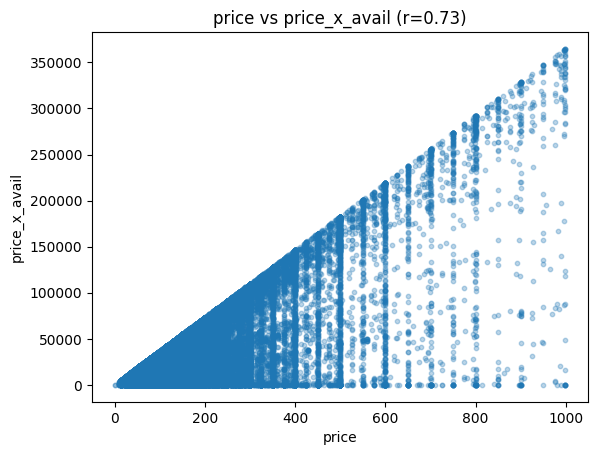

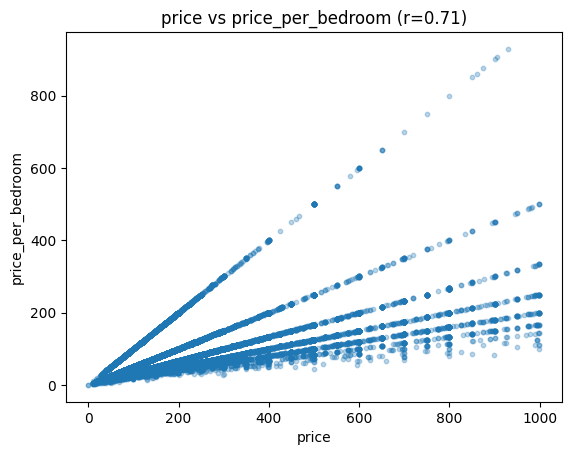

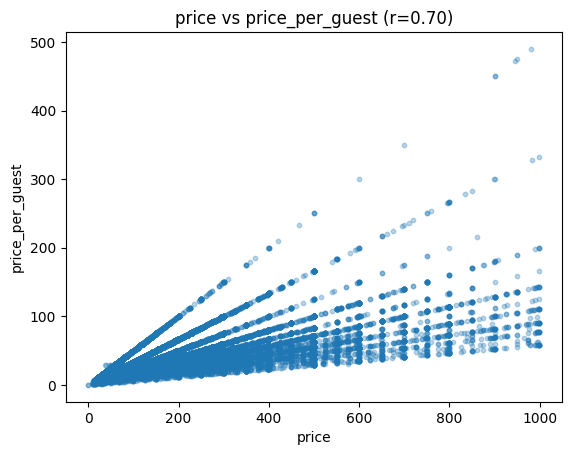

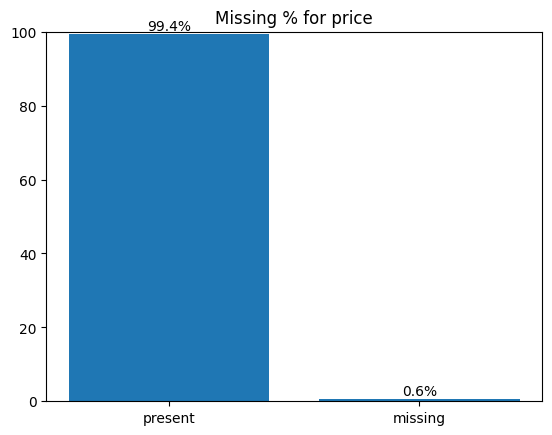


Outliers (<-75.00 or >325.00): 6219 rows, 6.75%


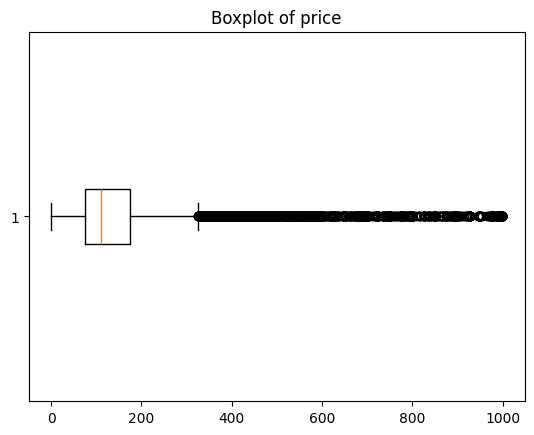

<Figure size 640x480 with 0 Axes>

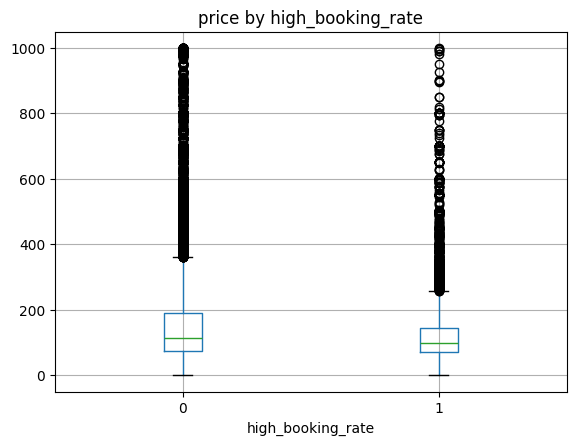


Point-biserial corr: r=-0.108, p=7.97e-235
T-test: t=-32.817, p=7.97e-235


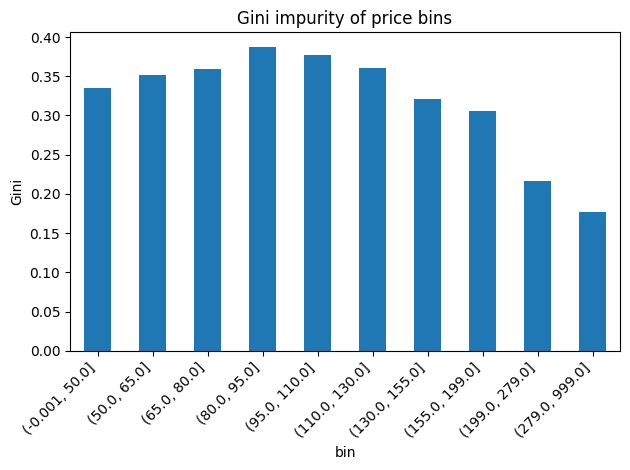

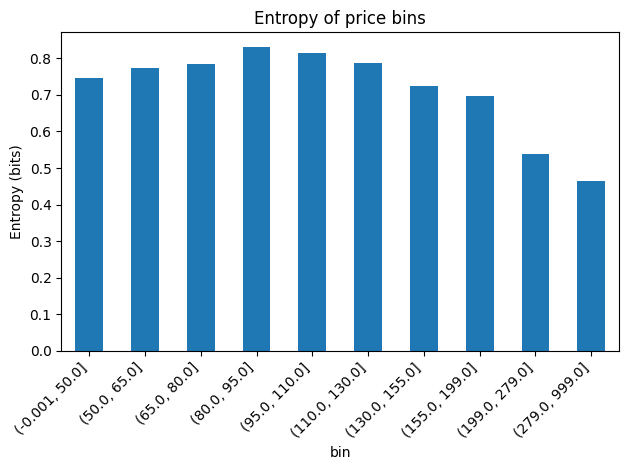

Feature: 'price'
  → Missing: 533 / 92067 rows (0.58%)


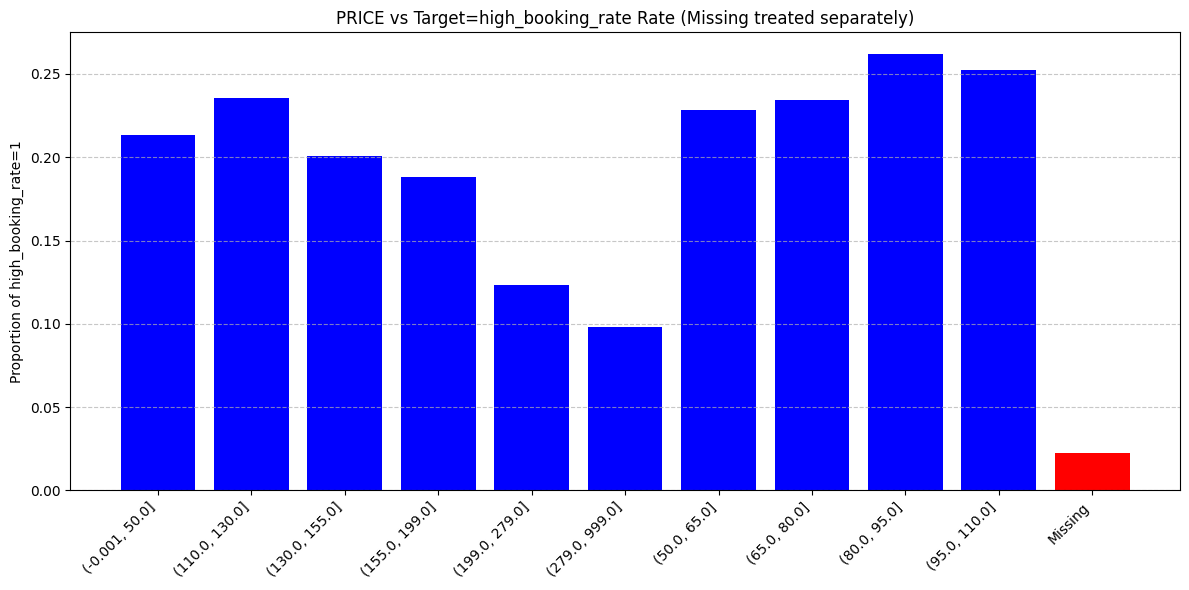

In [31]:
## 10. price - price to rent the listing for one night
analyze_numeric(train_2, 'price')
analyze_missing_value_bin_trend(train_2, 'price')


Booking rate drops as price increases — clear negative trend

Highest booking rate is in the $80–130 range

Missing values (though rare) have low booking rate

Kind of had 2 options for handling the skewness:

1. do log tranformation which would retain the small nuances
2. do binning based on gini impurity which would make computation a lot easier

going with log for this one

In [32]:
# 11. Apply log1p on non-missing prices only
train_2['price_log'] = np.where(
    train_2['price'].isna(),
    -1,  # Placeholder for missing
    np.log1p(train_2['price'])
)

#dropping original
train_2.drop(columns=['price'], inplace=True)


#for test_x
# 11. Apply log1p on non-missing prices only
test_x['price_log'] = np.where(
    test_x['price'].isna(),
    -1,  # Placeholder for missing
    np.log1p(test_x['price'])
)

#dropping original
test_x.drop(columns=['price'], inplace=True)


--- accommodates DESCRIBE ---
                count      mean       std  min  25%  50%  75%   max
accommodates  92017.0  3.454286  2.322975  1.0  2.0  2.0  4.0  18.0
Skewness: 2.030, Kurtosis: 5.772
Missing: 50 (0.1%); Unique: 17


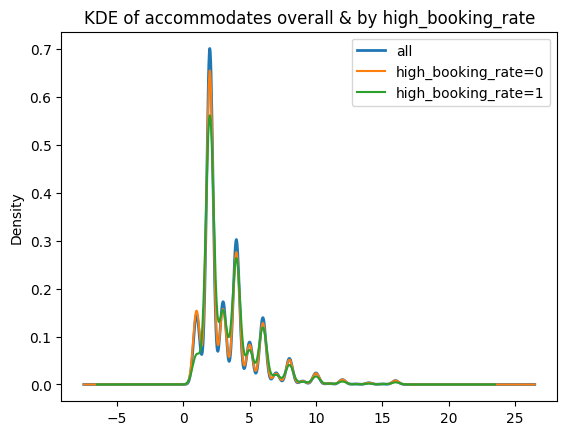

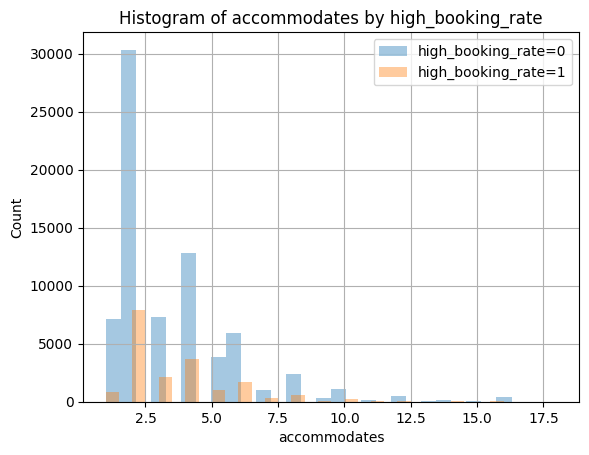

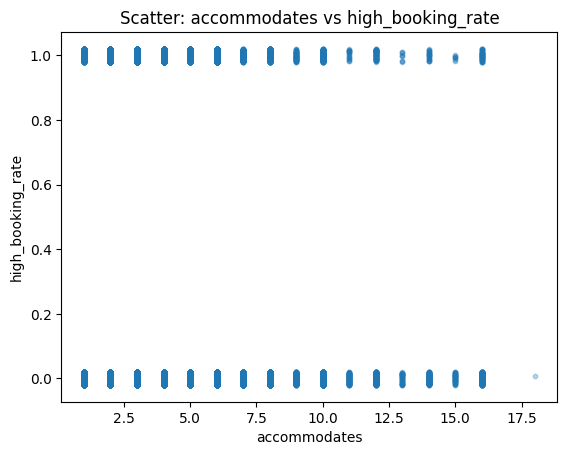


Top 3 correlated features with accommodates:
                  corr
beds          0.829353
bedrooms      0.758825
cleaning_fee  0.597418


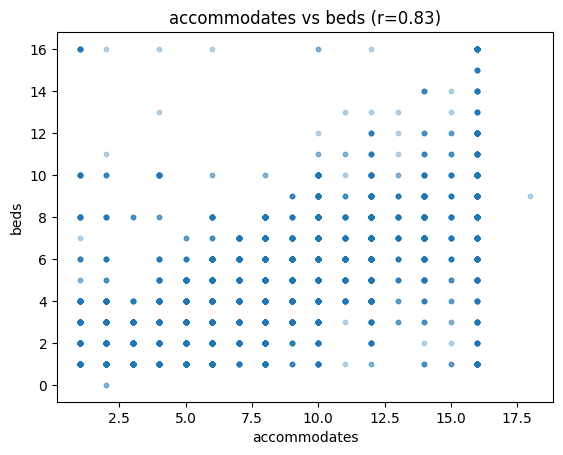

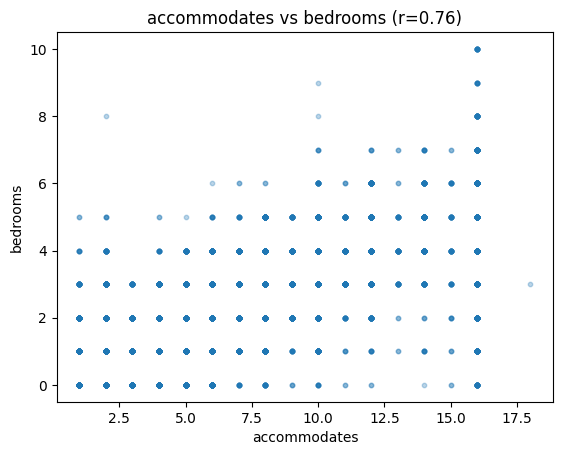

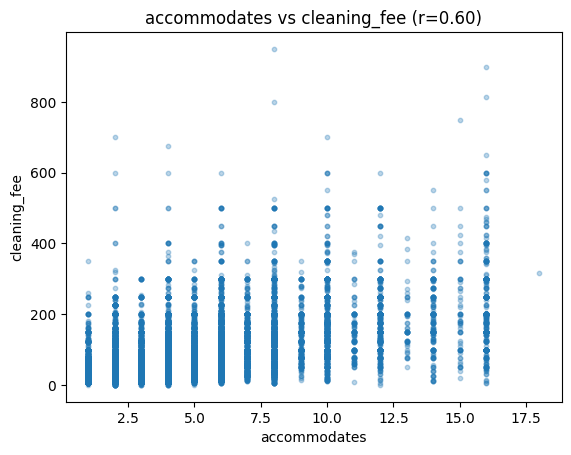

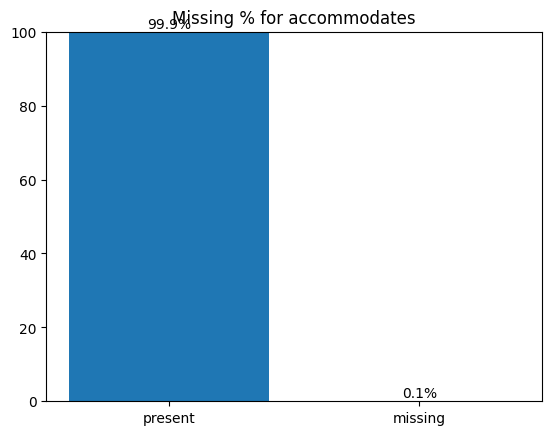


Outliers (<-1.00 or >7.00): 6125 rows, 6.65%


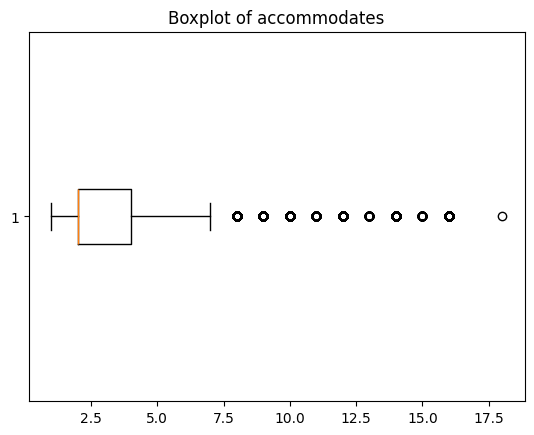

<Figure size 640x480 with 0 Axes>

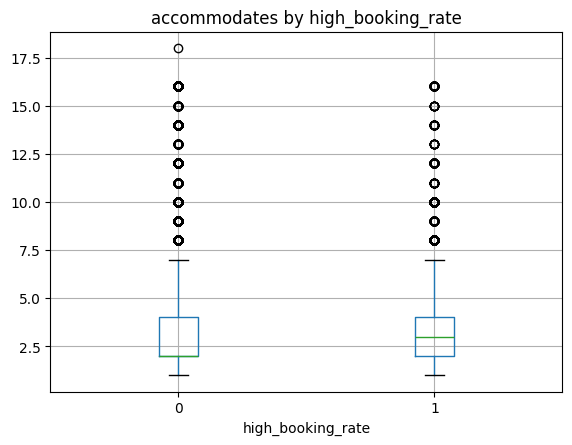


Point-biserial corr: r=0.011, p=0.00139
T-test: t=3.196, p=0.00139


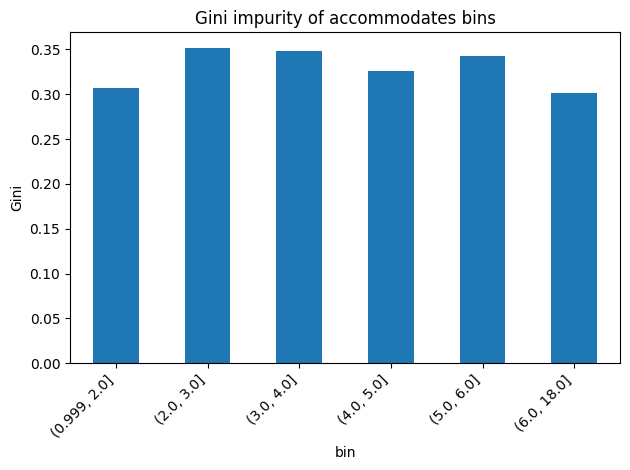

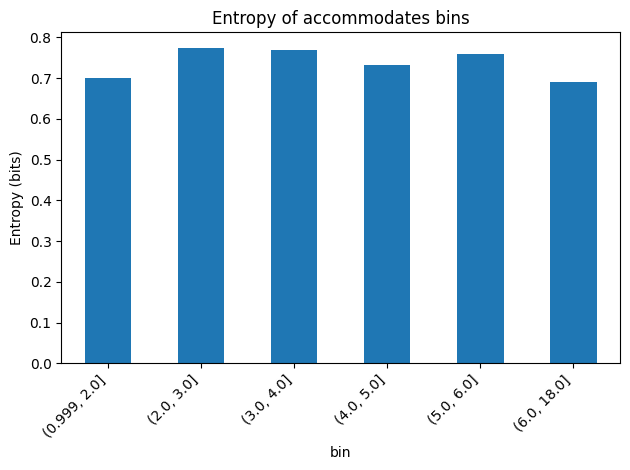

Feature: 'accommodates'
  → Missing: 50 / 92067 rows (0.05%)


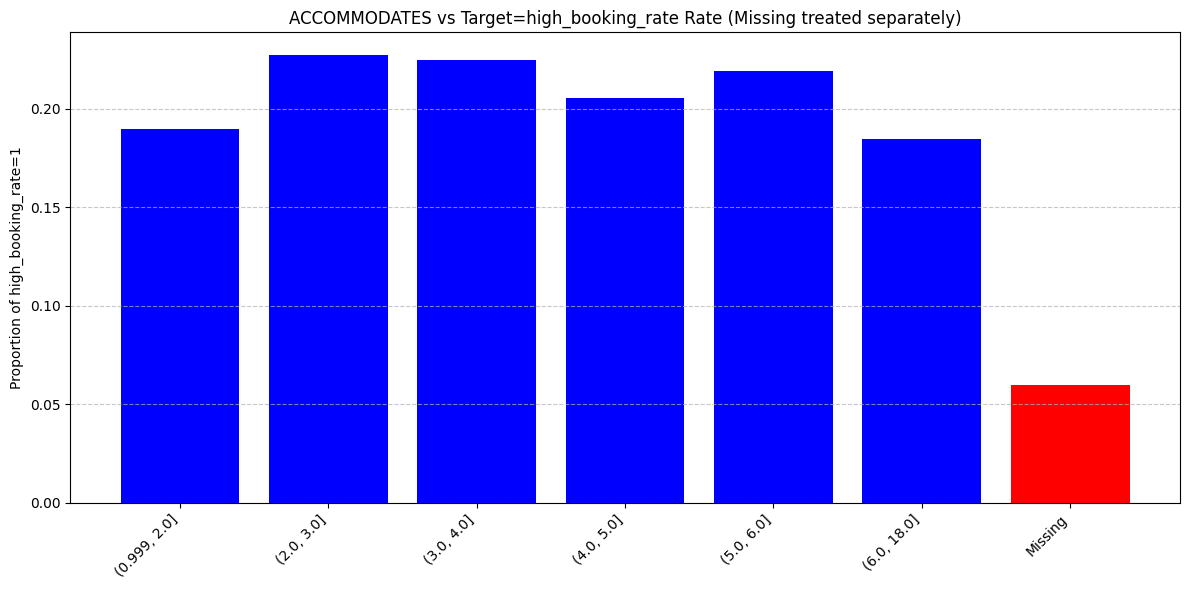

In [33]:
# 12. accommodates
analyze_numeric(train_2, 'accommodates')
analyze_missing_value_bin_trend(train_2, 'accommodates')

In [34]:
# not going to do much changes here
# this is obviously a necessary feature

#replacing missing values by -1
train_2['accommodates'] = train_2['accommodates'].fillna(-1).astype(int)
test_x['accommodates'] = test_x['accommodates'].fillna(-1).astype(int)


--- extra_people DESCRIBE ---
                count      mean        std  min  25%  50%   75%    max
extra_people  92067.0  13.98525  22.352321  0.0  0.0  5.0  20.0  500.0
Skewness: 4.321, Kurtosis: 37.037
Missing: 0 (0.0%); Unique: 124


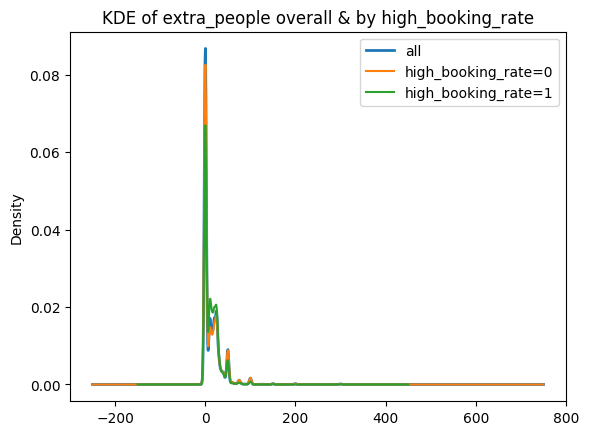

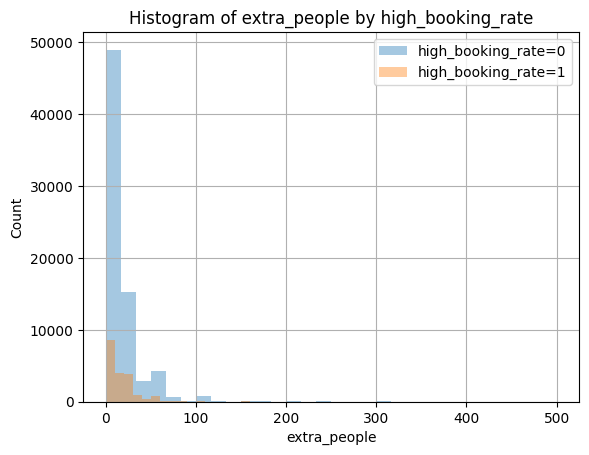

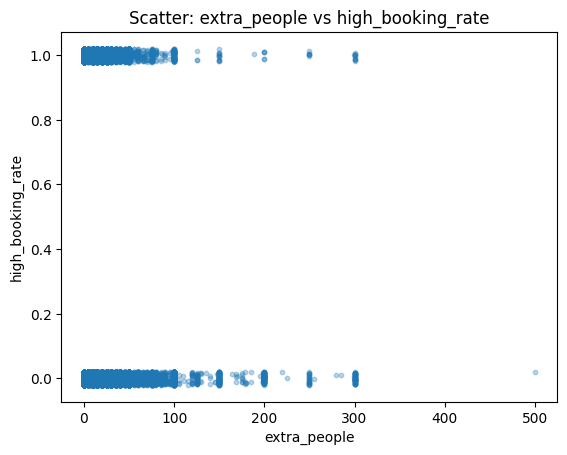


Top 3 correlated features with extra_people:
                         corr
guests_included      0.372373
bathrooms_per_guest  0.310063
price_x_guests       0.275429


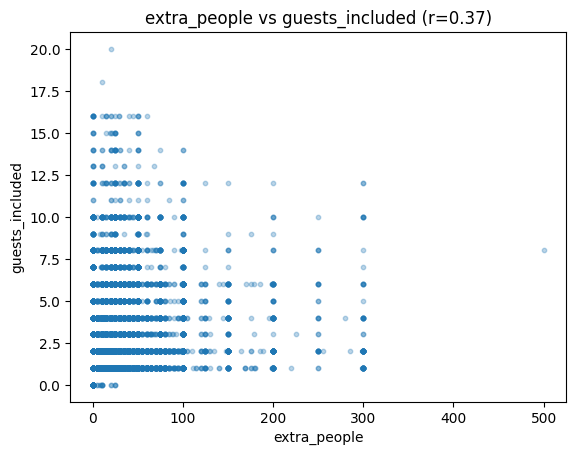

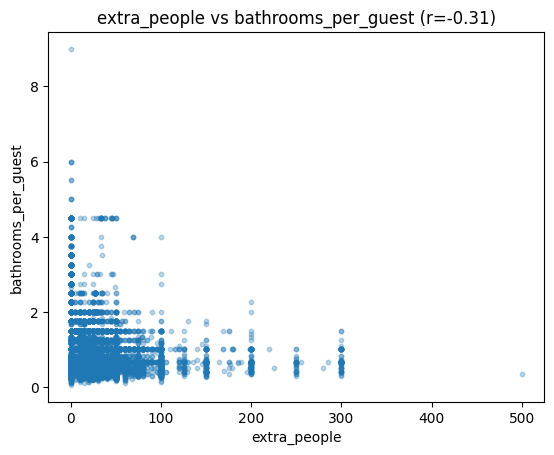

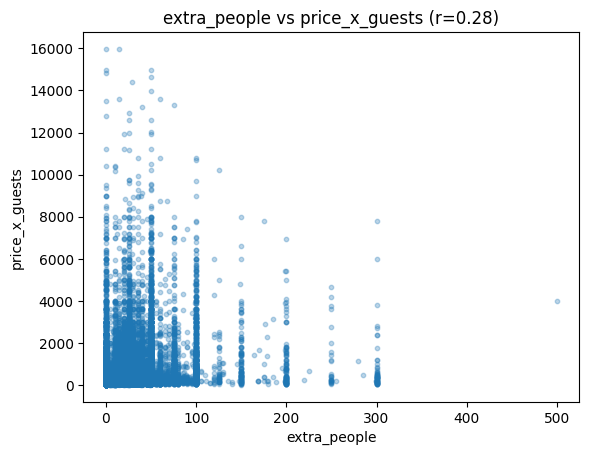

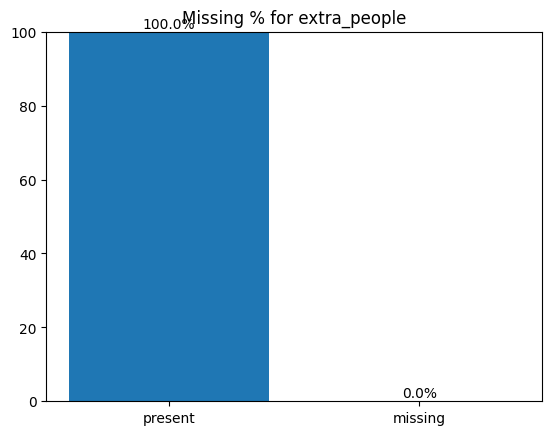


Outliers (<-30.00 or >50.00): 2663 rows, 2.89%


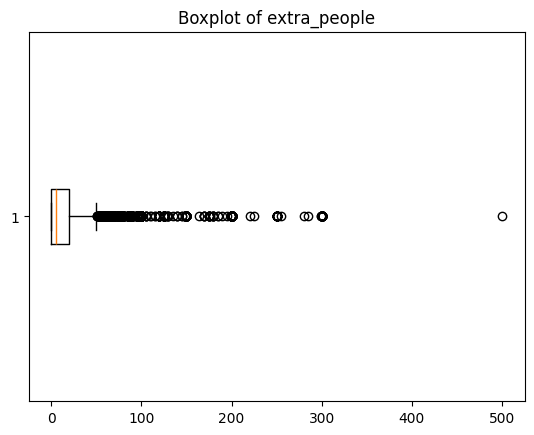

<Figure size 640x480 with 0 Axes>

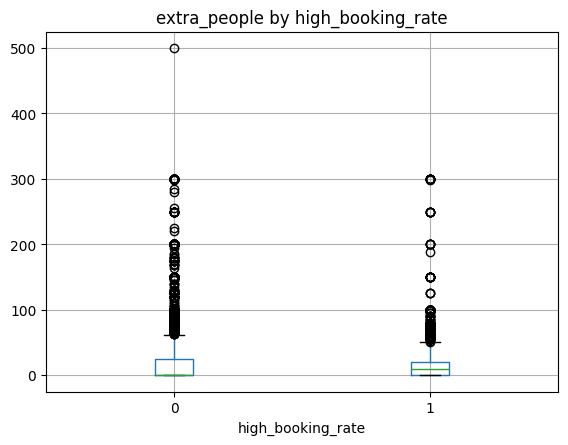


Point-biserial corr: r=-0.015, p=7.6e-06
T-test: t=-4.476, p=7.6e-06


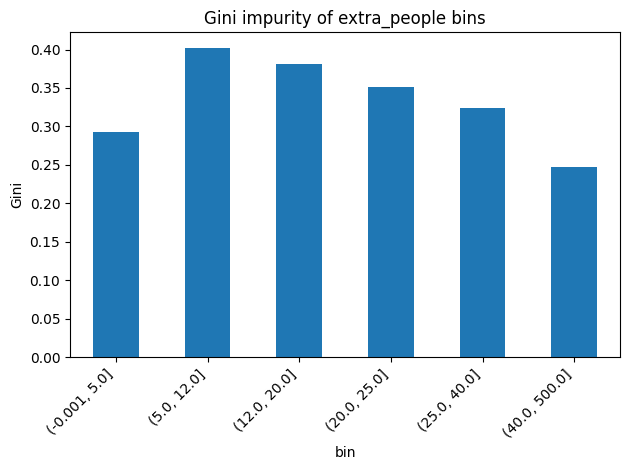

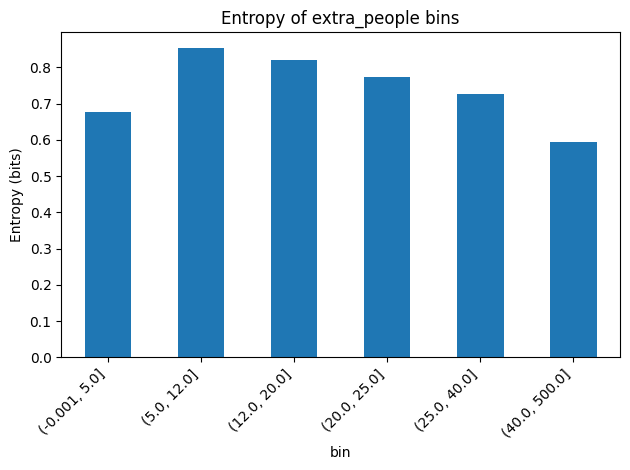

Feature: 'extra_people'
  → Missing: 0 / 92067 rows (0.00%)


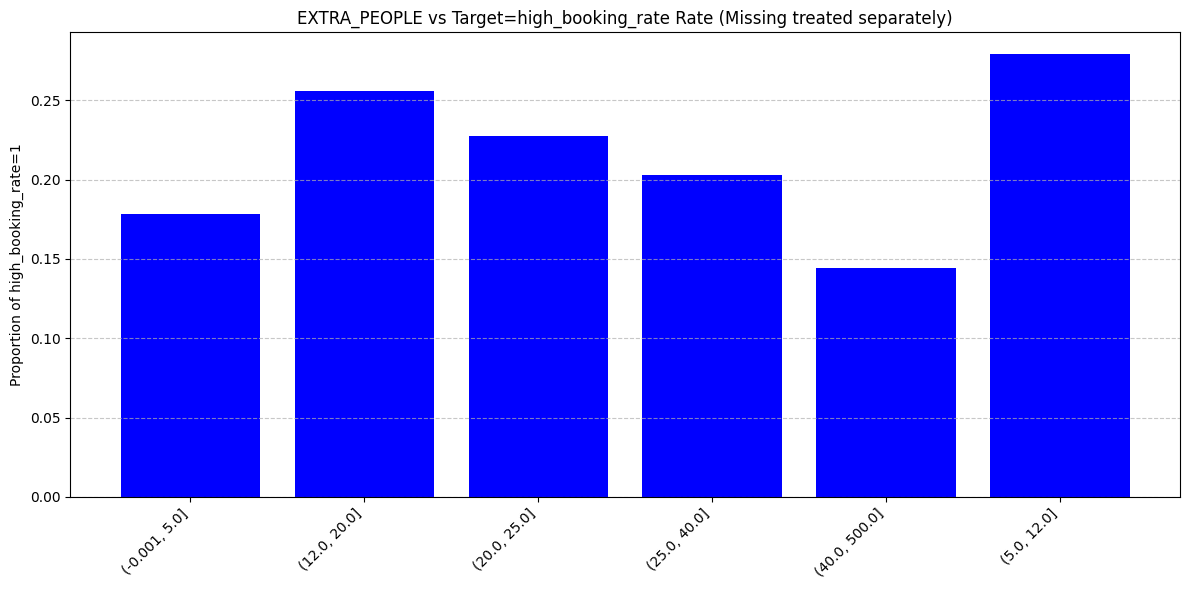

In [35]:
#13. extra_people

analyze_numeric(train_2, 'extra_people')
analyze_missing_value_bin_trend(train_2, 'extra_people')


In [36]:
# TRANSFORMATION - extra_people - log transform to deal with extreme skewness

train_2['extra_people_log'] = np.log1p(train_2['extra_people'])

#drop original
train_2.drop(columns=['extra_people'], inplace=True)


# TRANSFORMATION - extra_people - log transform to deal with extreme skewness

test_x['extra_people_log'] = np.log1p(test_x['extra_people'])

#drop original
test_x.drop(columns=['extra_people'], inplace=True)



--- guests_included DESCRIBE ---
                   count      mean       std  min  25%  50%  75%   max
guests_included  92067.0  1.765692  1.478341  0.0  1.0  1.0  2.0  20.0
Skewness: 3.021, Kurtosis: 12.870
Missing: 0 (0.0%); Unique: 19


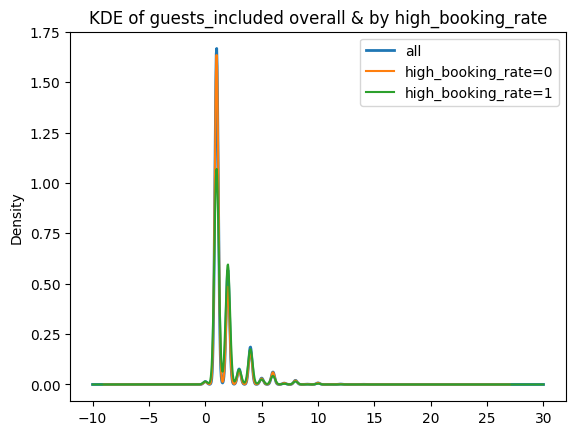

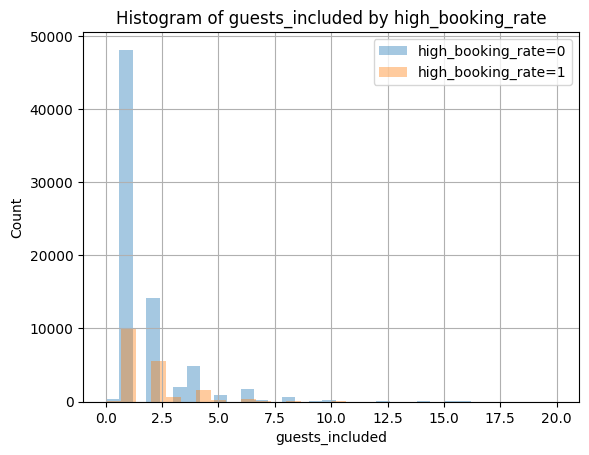

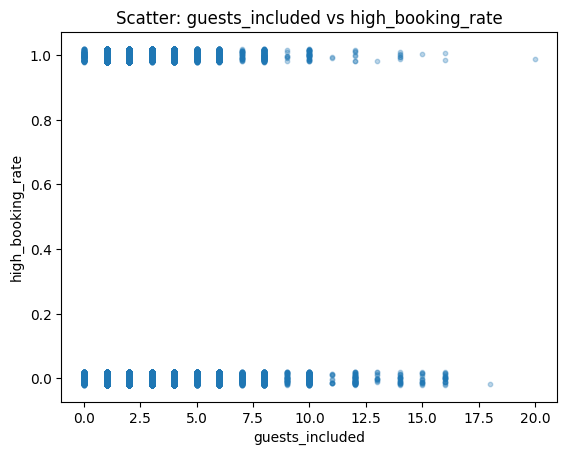


Top 3 correlated features with guests_included:
                         corr
price_x_guests       0.804313
bathrooms_per_guest  0.589807
accommodates         0.578897


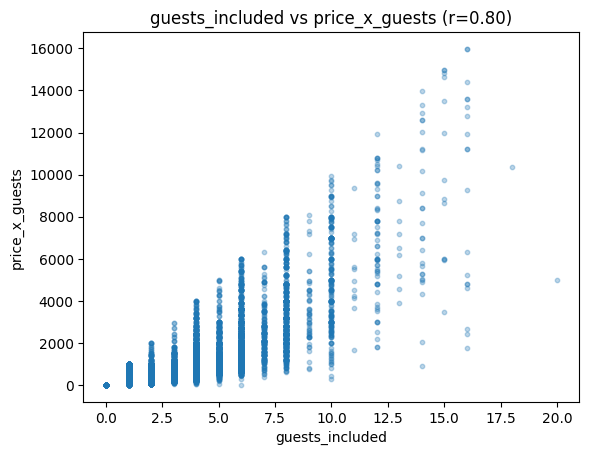

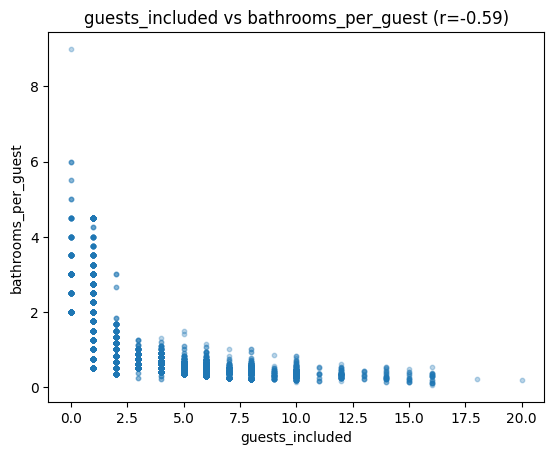

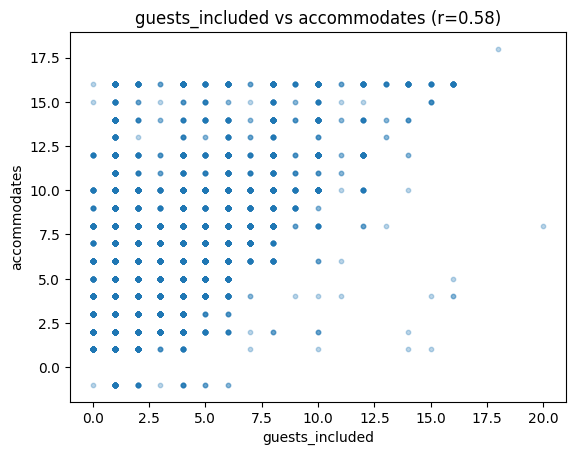

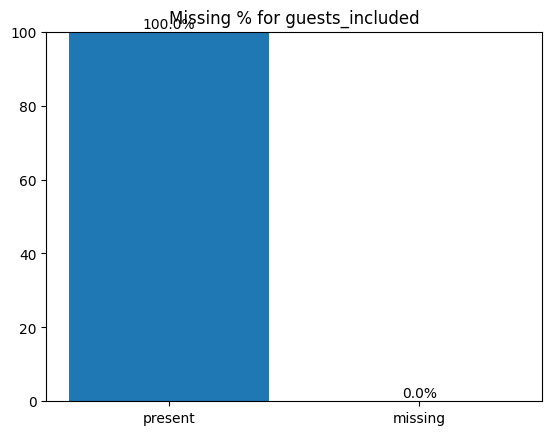


Outliers (<-0.50 or >3.50): 11172 rows, 12.13%


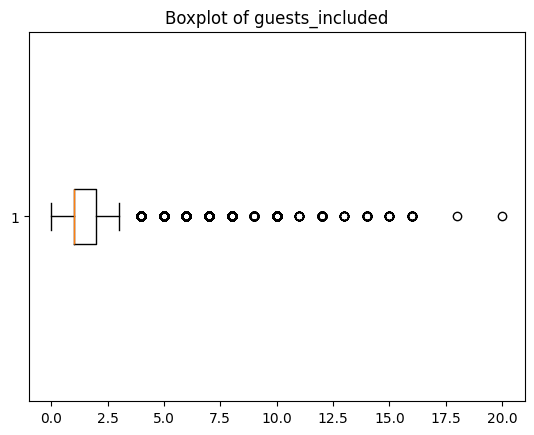

<Figure size 640x480 with 0 Axes>

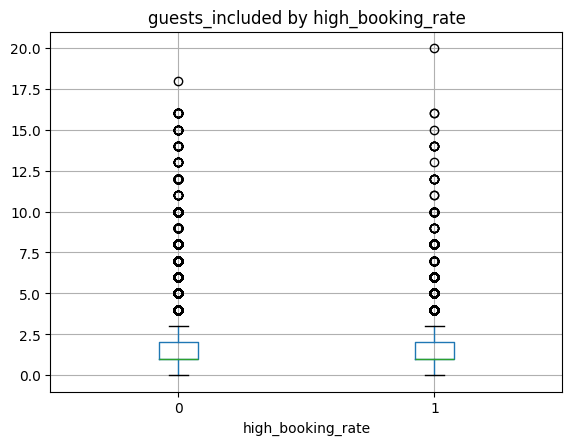


Point-biserial corr: r=0.036, p=1.64e-28
T-test: t=11.080, p=1.64e-28


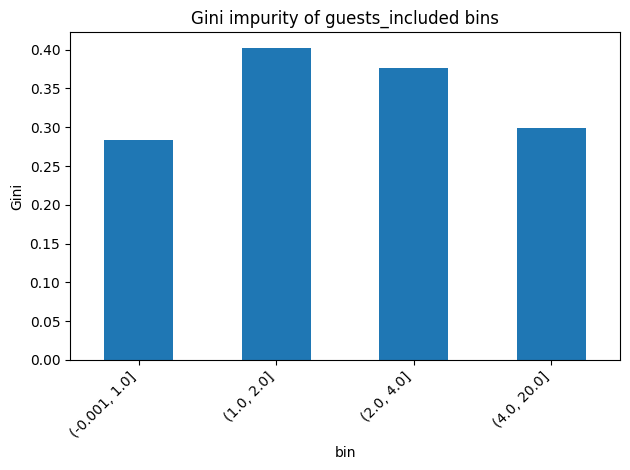

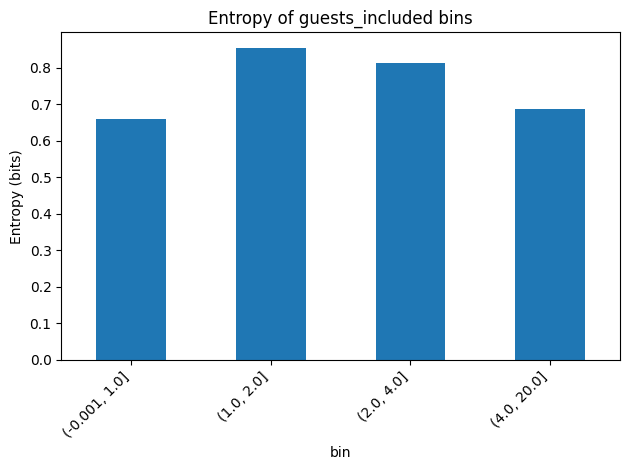

Feature: 'guests_included'
  → Missing: 0 / 92067 rows (0.00%)


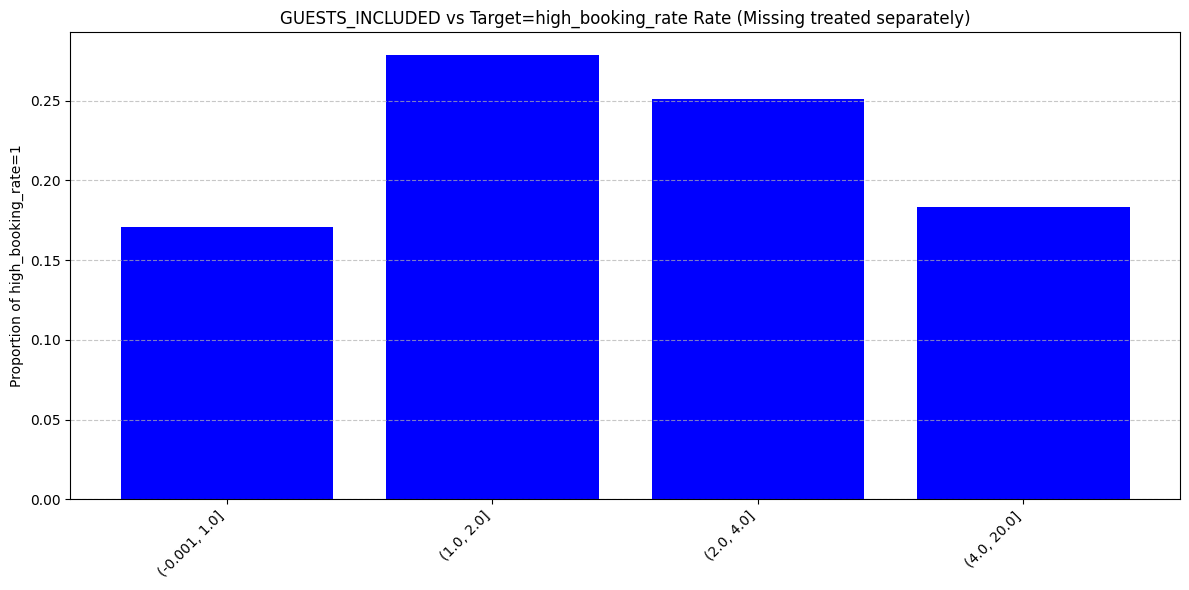

In [37]:
# 14. guests_included - how many guests are included in the price of the rental
analyze_numeric(train_2, 'guests_included')
analyze_missing_value_bin_trend(train_2, 'guests_included')

very highly skewed with long tail. we could do log1p but i am just going with binning here. no particular reason to back it to bhe honest

In [38]:
# TRANSFORMATION - guests_included

# Bin guests_included
train_2['guests_included_binned'] = pd.cut(
    train_2['guests_included'],
    bins=[-1, 1, 2, 4, 20],
    labels=["≤1", "1-2", "2-4", "4+"]
).astype(str)

# Encode as integer
train_2['guests_included_encoded'] = train_2['guests_included_binned'].astype('category').cat.codes

# Optional: drop original
train_2.drop(['guests_included', 'guests_included_binned'], axis=1, inplace=True)



# for test set
# Bin guests_included
test_x['guests_included_binned'] = pd.cut(
    test_x['guests_included'],
    bins=[-1, 1, 2, 4, 20],
    labels=["≤1", "1-2", "2-4", "4+"]
).astype(str)

# Encode as integer
test_x['guests_included_encoded'] = test_x['guests_included_binned'].astype('category').cat.codes

# Optional: drop original
test_x.drop(['guests_included', 'guests_included_binned'], axis=1, inplace=True)


--- host_listings_count DESCRIBE ---
                       count      mean       std  min  25%  50%  75%    max
host_listings_count  92067.0  3.381255  8.599634  1.0  1.0  1.0  2.0  212.0
Skewness: 9.425, Kurtosis: 138.758
Missing: 0 (0.0%); Unique: 60


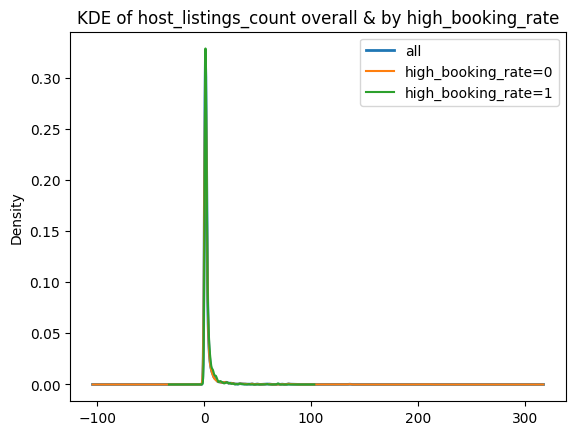

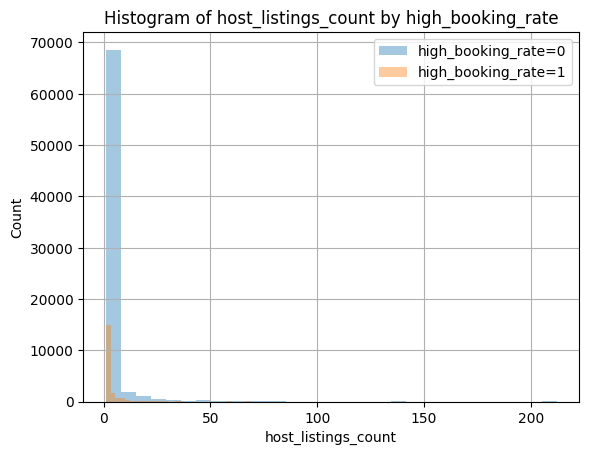

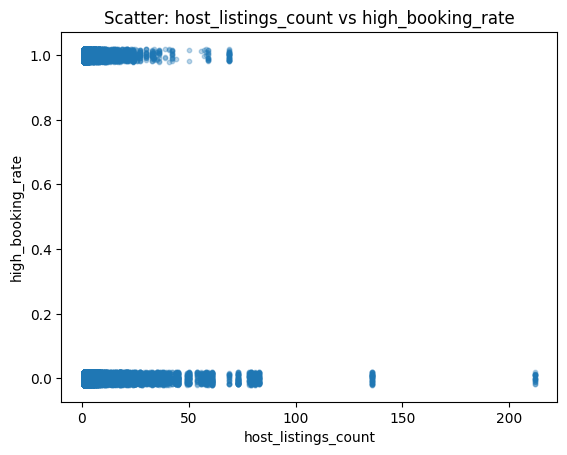


Top 3 correlated features with host_listings_count:
                               corr
host_total_listings_count  0.686981
cleaning_fee               0.146876
bathrooms_per_guest        0.138428


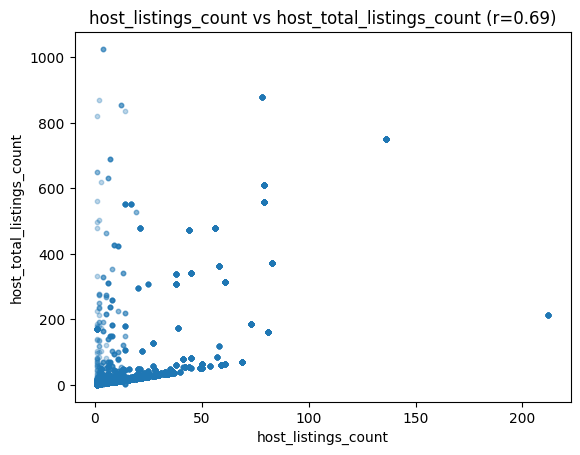

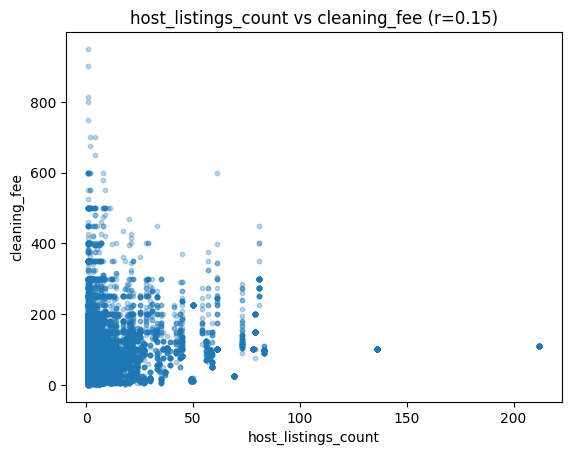

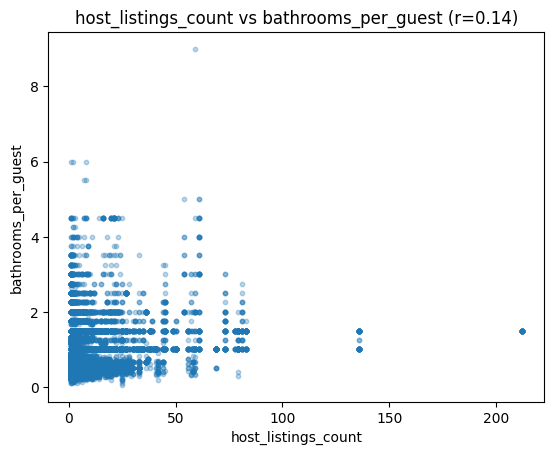

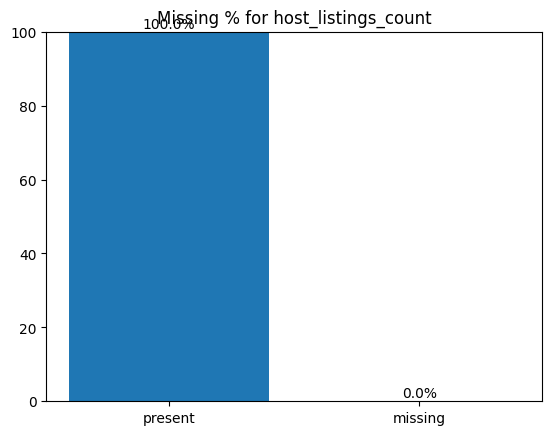


Outliers (<-0.50 or >3.50): 15423 rows, 16.75%


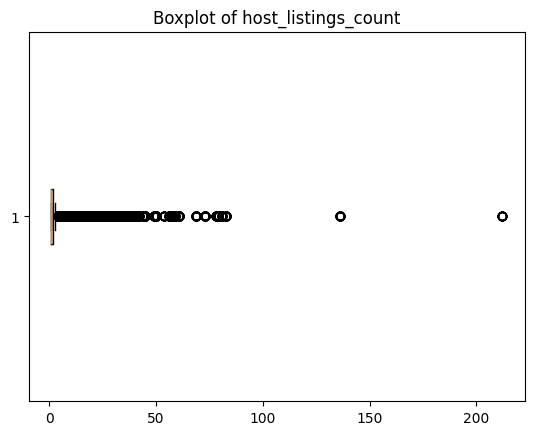

<Figure size 640x480 with 0 Axes>

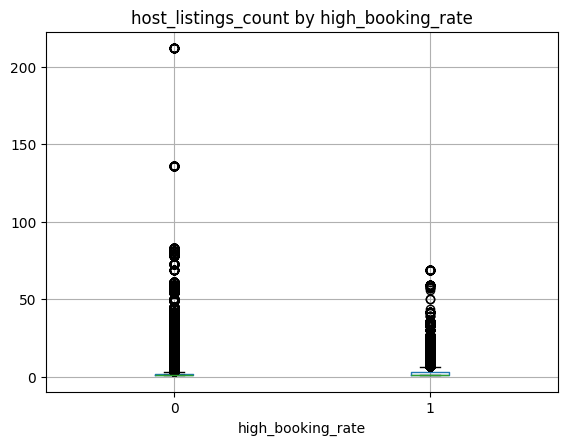


Point-biserial corr: r=-0.018, p=4.44e-08
T-test: t=-5.473, p=4.44e-08


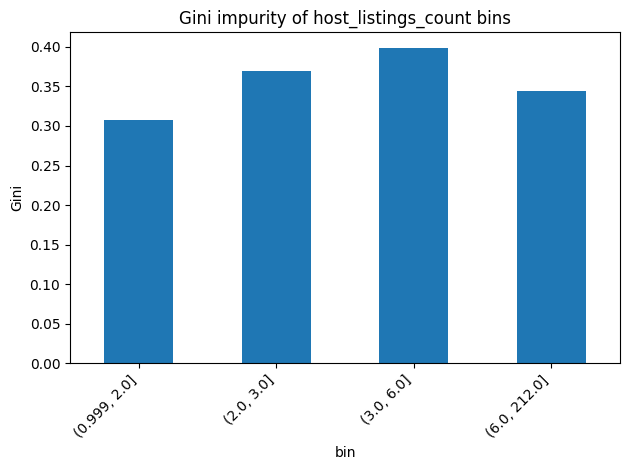

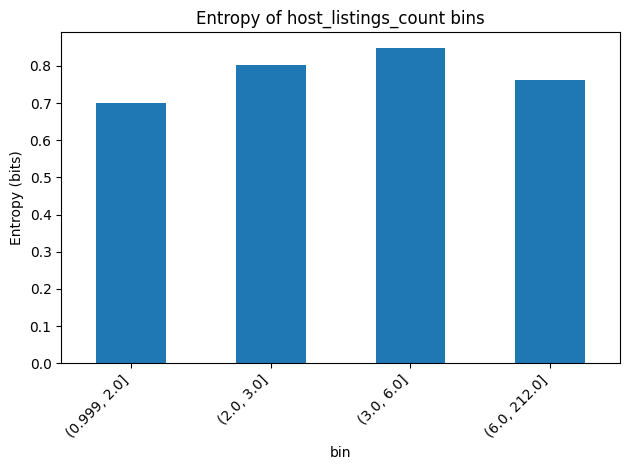

Feature: 'host_listings_count'
  → Missing: 0 / 92067 rows (0.00%)


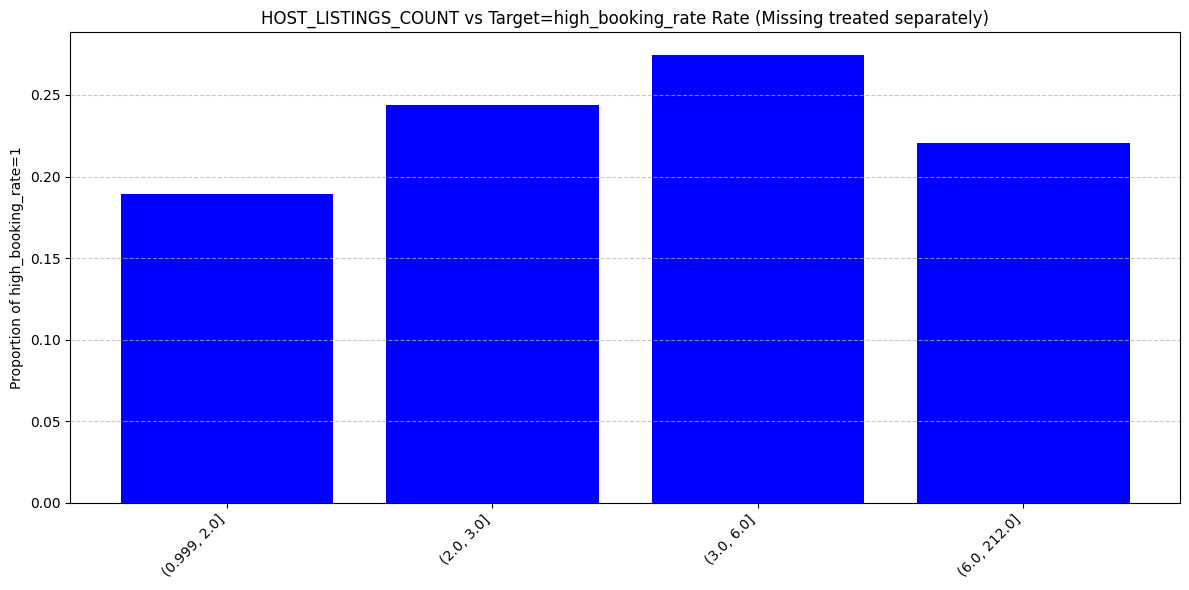

In [39]:
# 15. host_listings_count - how many total listings the host has
analyze_numeric(train_2, 'host_listings_count')
analyze_missing_value_bin_trend(train_2, 'host_listings_count')

In [40]:
#TRANSFORMATION - host_listings_count

# Handle zeros safely for log1p (log(1 + x)) and cast to float
train_2['host_listings_count_log'] = np.log1p(train_2['host_listings_count'].astype(float))

# Drop original if not needed
train_2.drop(columns=['host_listings_count'], inplace=True)


# Handle zeros safely for log1p (log(1 + x)) and cast to float
test_x['host_listings_count_log'] = np.log1p(test_x['host_listings_count'].astype(float))

# Drop original if not needed
test_x.drop(columns=['host_listings_count'], inplace=True)


--- host_total_listings_count DESCRIBE ---
                             count      mean        std  min  25%  50%  75%  \
host_total_listings_count  91898.0  7.091525  42.484994  0.0  1.0  1.0  3.0   

                              max  
host_total_listings_count  1026.0  
Skewness: 12.965, Kurtosis: 193.789
Missing: 169 (0.2%); Unique: 154


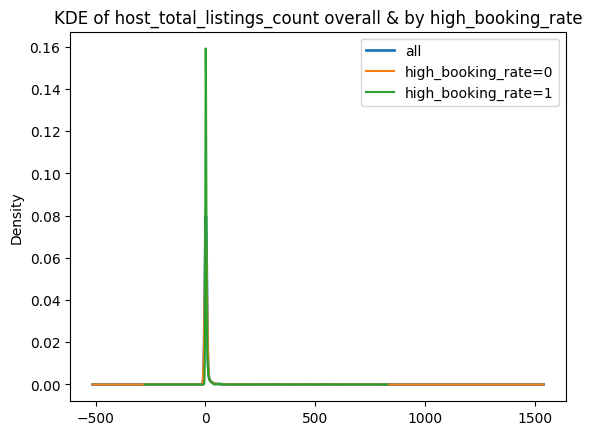

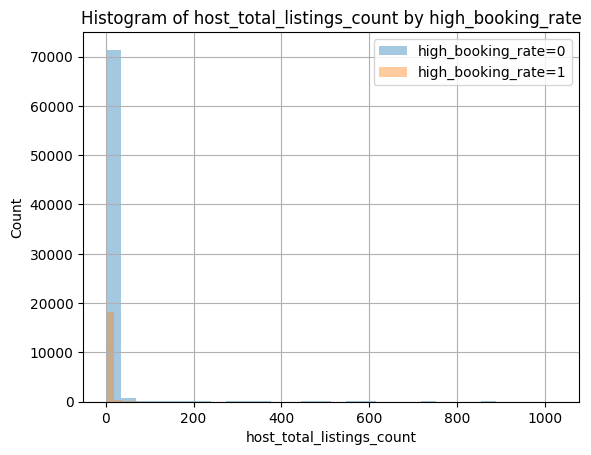

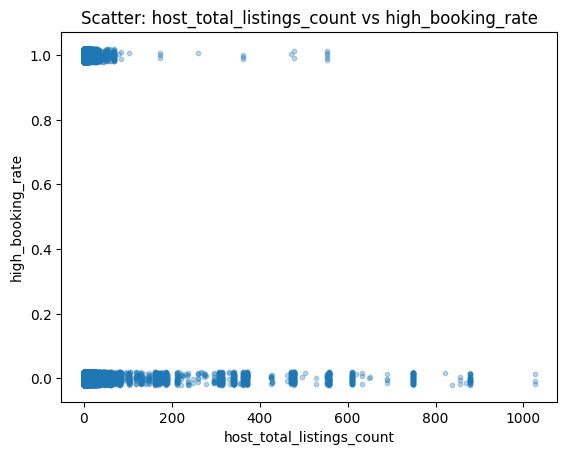


Top 3 correlated features with host_total_listings_count:
                             corr
host_listings_count_log  0.476239
cleaning_fee             0.124119
rooms_per_guest          0.105067


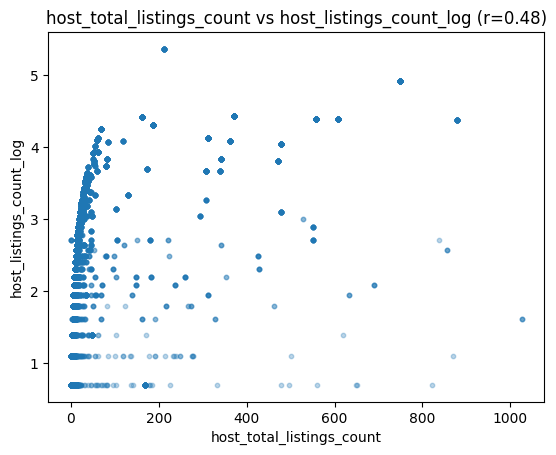

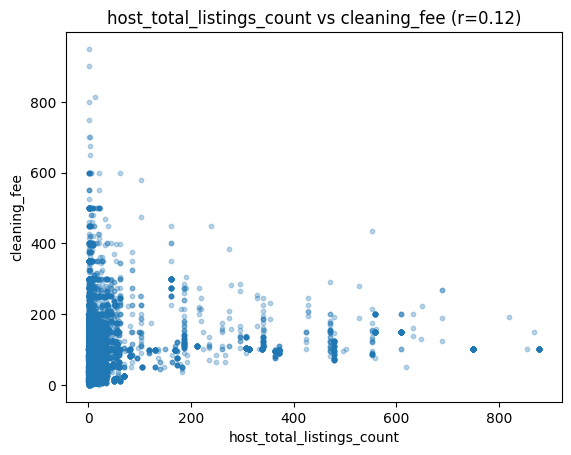

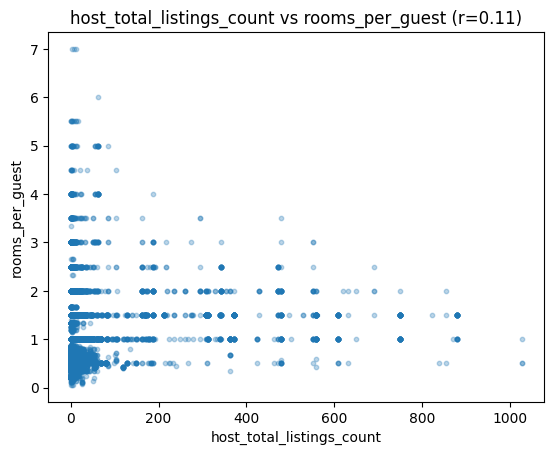

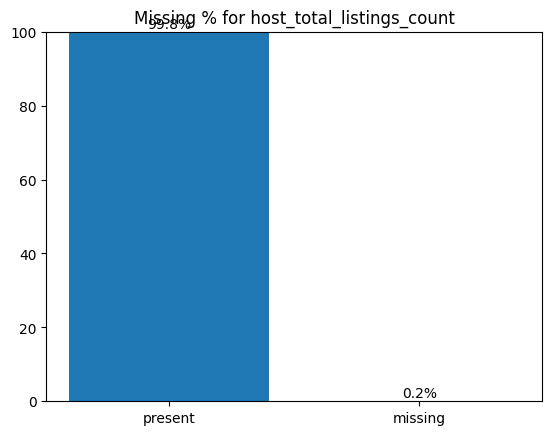


Outliers (<-2.00 or >6.00): 9746 rows, 10.59%


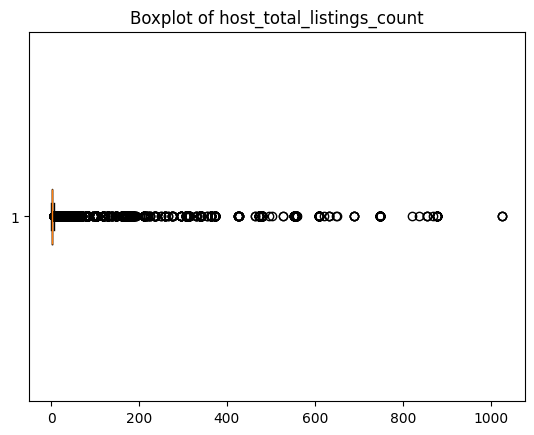

<Figure size 640x480 with 0 Axes>

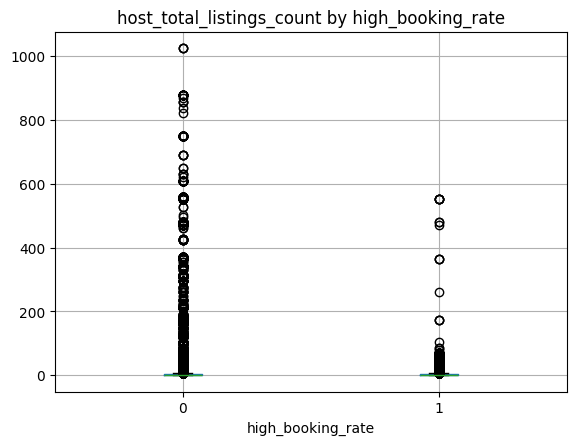


Point-biserial corr: r=-0.040, p=6.49e-34
T-test: t=-12.145, p=6.49e-34


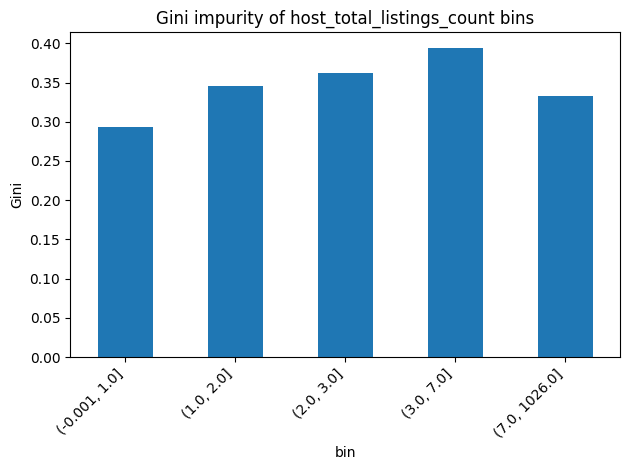

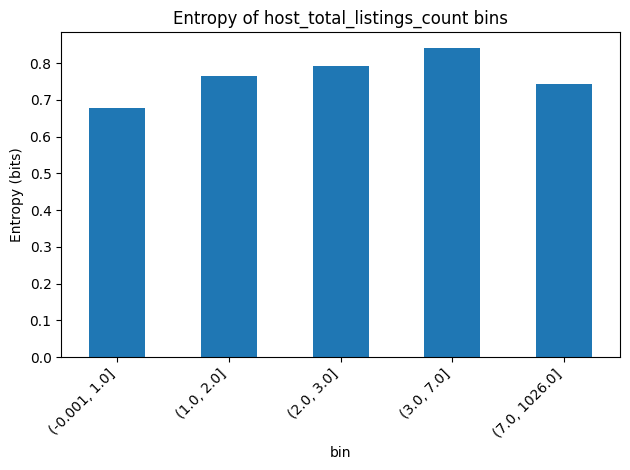

Feature: 'host_total_listings_count'
  → Missing: 169 / 92067 rows (0.18%)


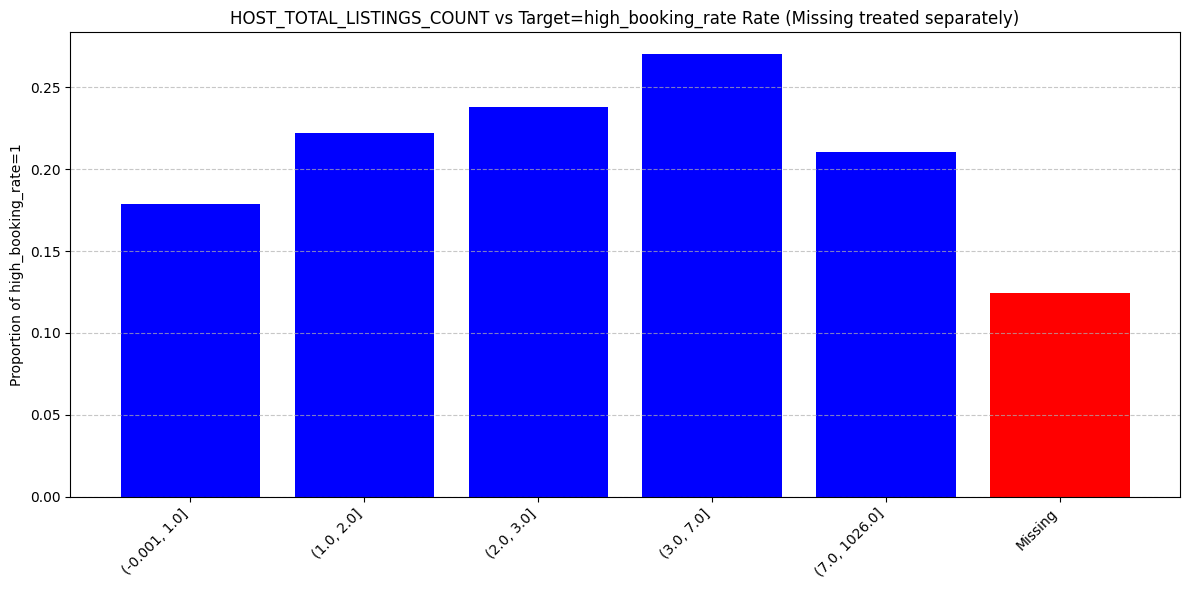

In [41]:
# 16. host_total_listings_count

analyze_numeric(train_2, 'host_total_listings_count')
analyze_missing_value_bin_trend(train_2, 'host_total_listings_count')


#dropping - very similar to host_listings_count
train_2.drop(columns=['host_total_listings_count'], inplace=True)

#dropping - very similar to host_listings_count
test_x.drop(columns=['host_total_listings_count'], inplace=True)


--- host_response_rate DESCRIBE ---
                      count      mean        std  min    25%    50%    75%  \
host_response_rate  78617.0  95.02142  14.071009  0.0  100.0  100.0  100.0   

                      max  
host_response_rate  100.0  
Skewness: -4.284, Kurtosis: 21.361
Missing: 13450 (14.6%); Unique: 91


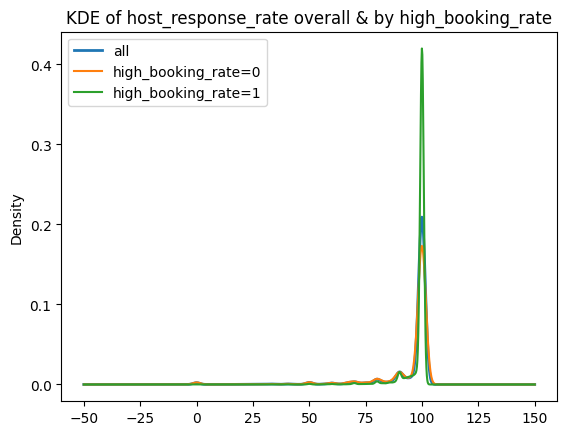

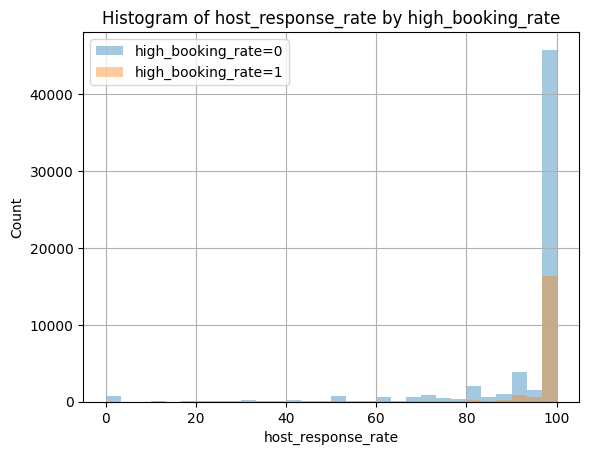

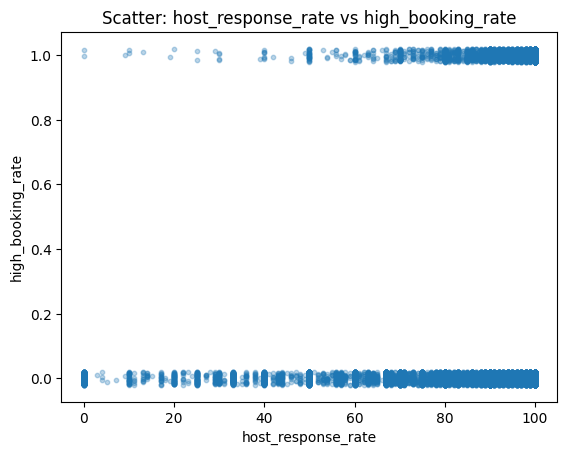


Top 3 correlated features with host_response_rate:
                             corr
host_listings_count_log  0.068247
availability_30          0.067261
availability_rate_30     0.067261


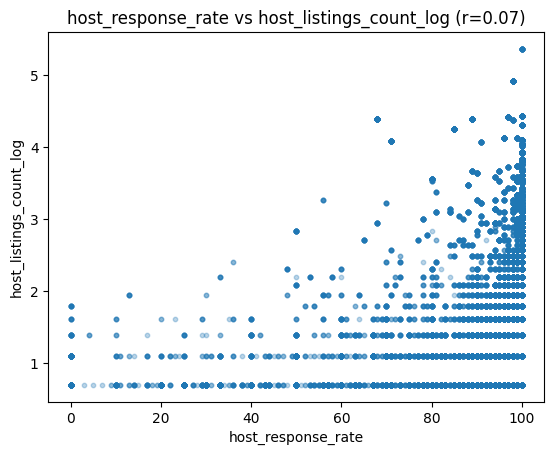

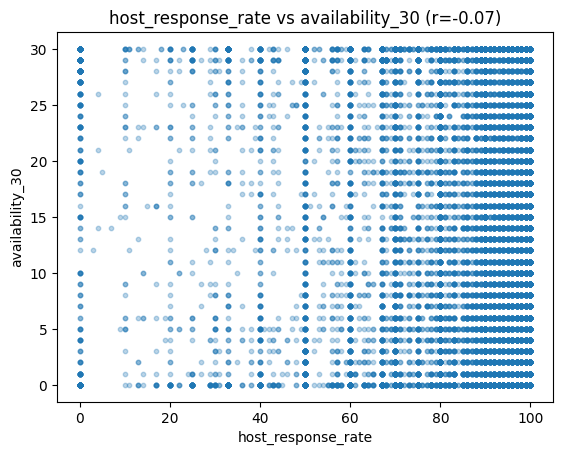

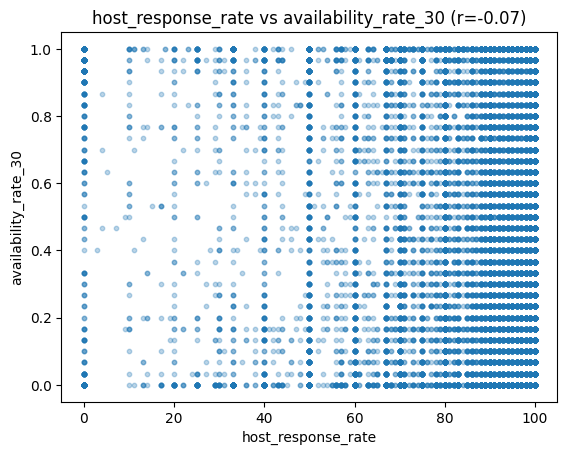

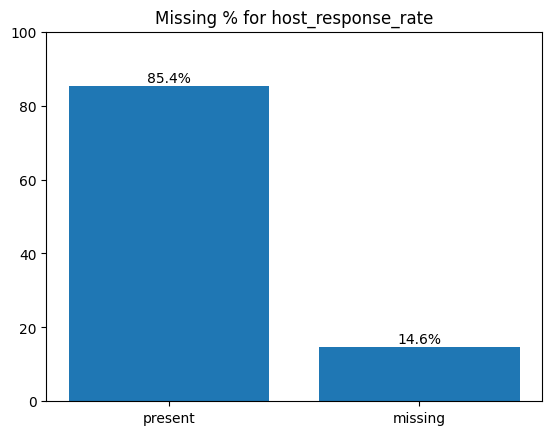


Outliers (<100.00 or >100.00): 19016 rows, 20.65%


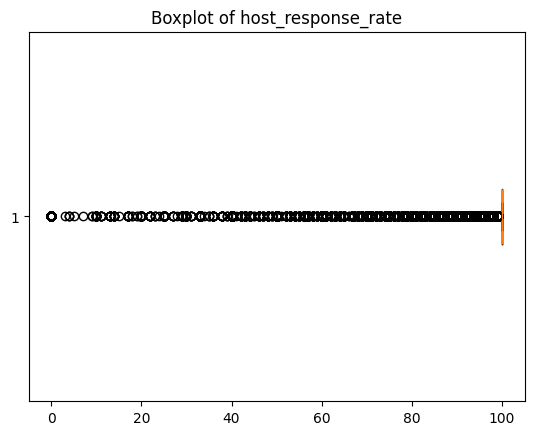

<Figure size 640x480 with 0 Axes>

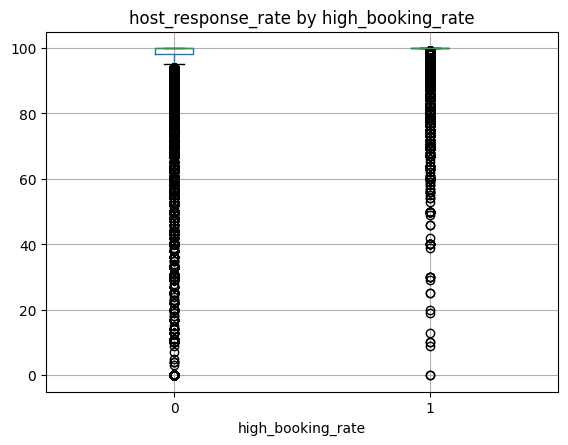


Point-biserial corr: r=0.131, p=4.49e-300
T-test: t=37.187, p=4.49e-300


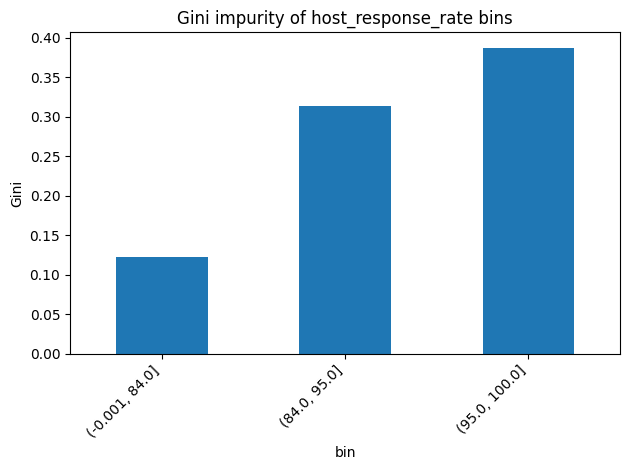

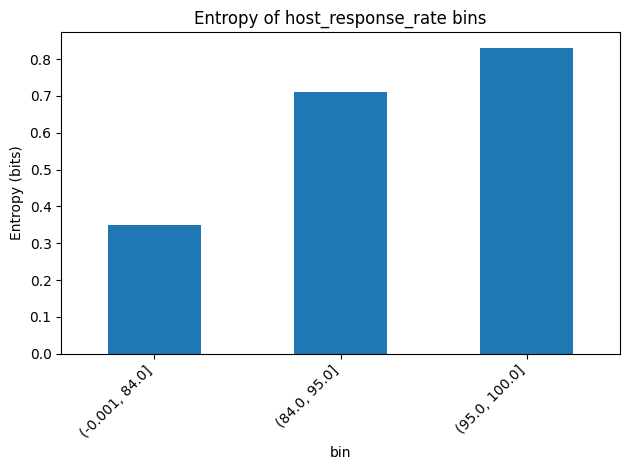

Feature: 'host_response_rate'
  → Missing: 13450 / 92067 rows (14.61%)


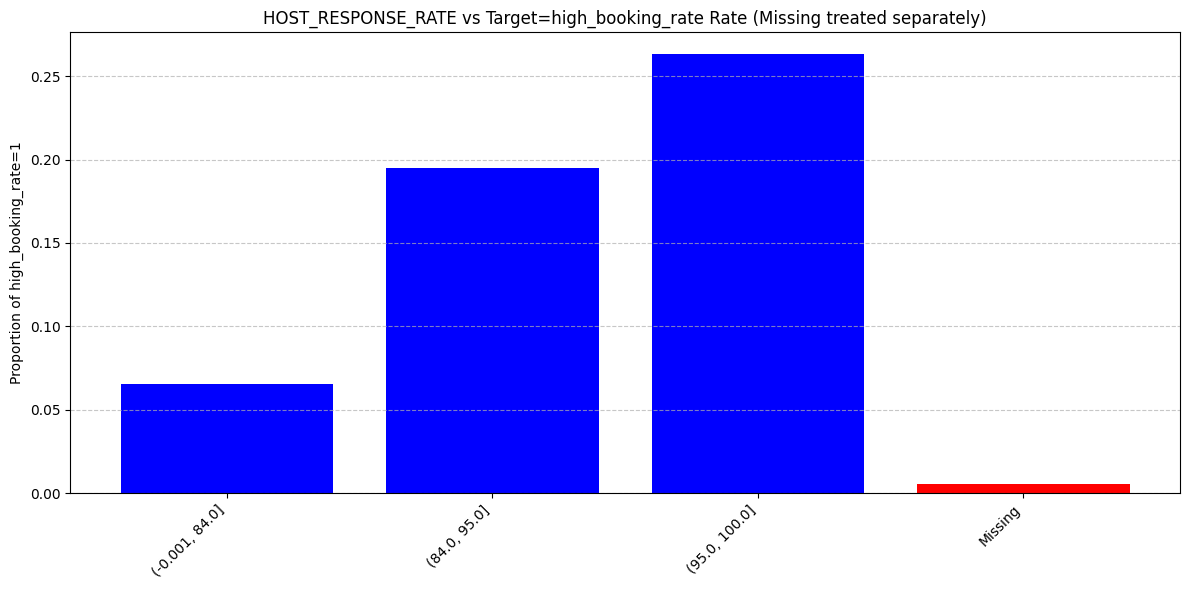

In [42]:
# 17. host_response_rate - percent of stay requests the host responds to

analyze_numeric(train_2, 'host_response_rate')
analyze_missing_value_bin_trend(train_2, 'host_response_rate')

KDE / Histogram: Clear pileup at 100%. High booking hosts seem to have a tighter concentration near 100%.

Gini Binning + Target Rate: Shows strong upward trend in target proportion from low → high response rates.

Missing bin has the lowest high_booking_rate (~0.01), which is very informative.



In [43]:
# just dealing with missing values - host_response_rate
train_2['host_response_rate'] = train_2['host_response_rate'].fillna(-1)
train_2.drop(columns=['host_response_rate'], inplace=True)


# test_x
test_x['host_response_rate'] = test_x['host_response_rate'].fillna(-1)
test_x.drop(columns=['host_response_rate'], inplace=True)

### Handling date columns

In [44]:
today = datetime.today()
train_2['host_since'] = pd.to_datetime(train_2['host_since'], errors='coerce')
train_2['first_review'] = pd.to_datetime(train_2['first_review'], errors='coerce')
test_x['host_since'] = pd.to_datetime(test_x['host_since'], errors='coerce')
test_x['first_review'] = pd.to_datetime(test_x['first_review'], errors='coerce')

In [45]:
train_2['host_account_age'] = (today - train_2['host_since']).dt.days
train_2['listing_age_days'] = (today - train_2['first_review']).dt.days.fillna(0)

test_x['host_account_age'] = (today - test_x['host_since']).dt.days
test_x['listing_age_days'] = (today - test_x['first_review']).dt.days.fillna(0)

In [46]:
#drop original date columns
train_2.drop(columns=['host_since','first_review'], inplace=True)

test_x.drop(columns=['host_since','first_review'], inplace=True)

## Dealing with some categorical columns

In [47]:
# dropping all location related columns except lat long
loc_features = ['city', 'country', 'country_code', 'host_location', 'host_neighbourhood', 'neighborhood', 'smart_location','state','market']

train_2.drop(columns=loc_features, inplace=True)
test_x.drop(columns=loc_features, inplace=True)

In [48]:
# 18. experiences_offered - whether there are "experiences" offered with the listing (t) or not (f)
train_2['experiences_offered'].value_counts()

# dropping because all none values
train_2.drop(columns=['experiences_offered'], inplace=True)
test_x.drop(columns=['experiences_offered'], inplace=True)


--- host_response_time ---
Unique: 5
Missing: 13450 (14.6%)

Top categories:
 host_response_time
within an hour        45962
within a few hours    19273
NaN                   13450
within a day          11874
a few days or more     1508
Name: count, dtype: int64


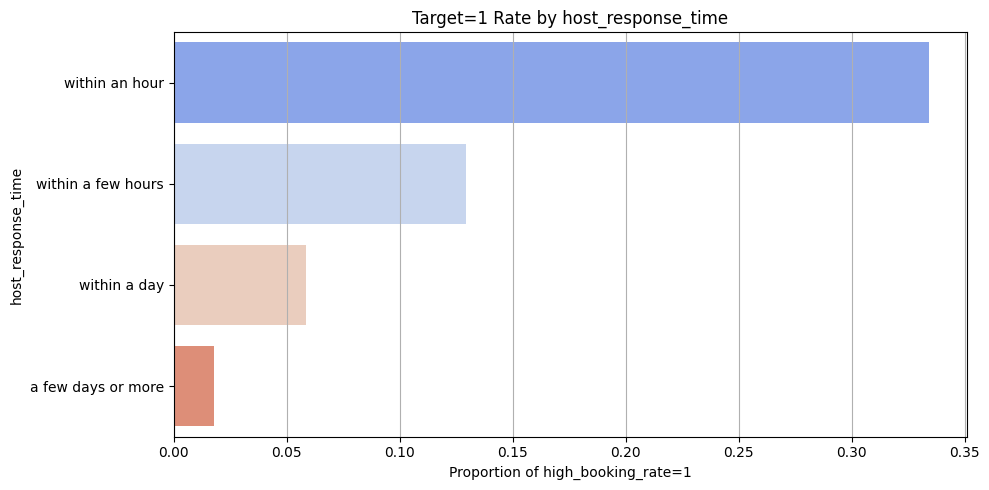

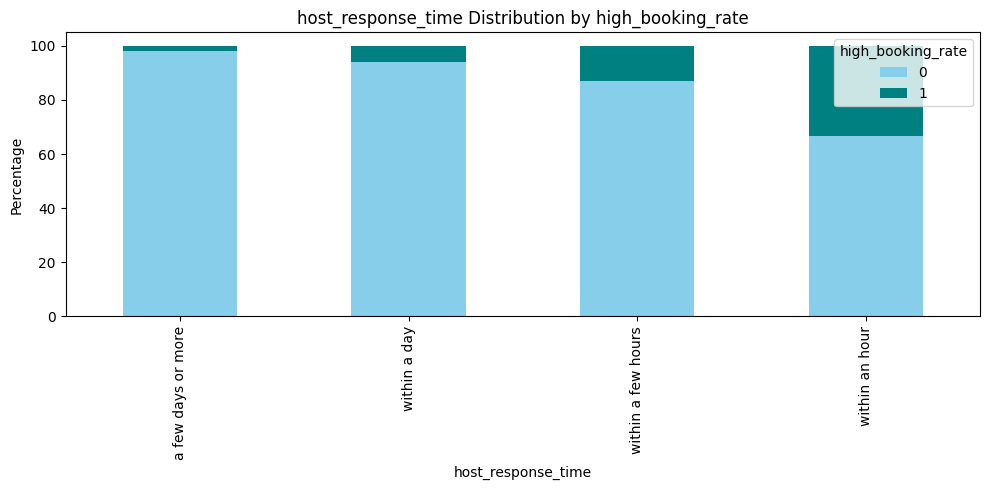

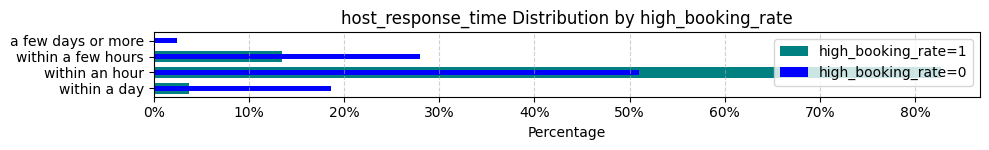

Chi-square test: χ²=6150.66, dof=3, p=0.0000
Feature: 'host_response_time'
  → Missing: 13450 / 92067 rows (14.61%)
  → Unique (non-missing): 4


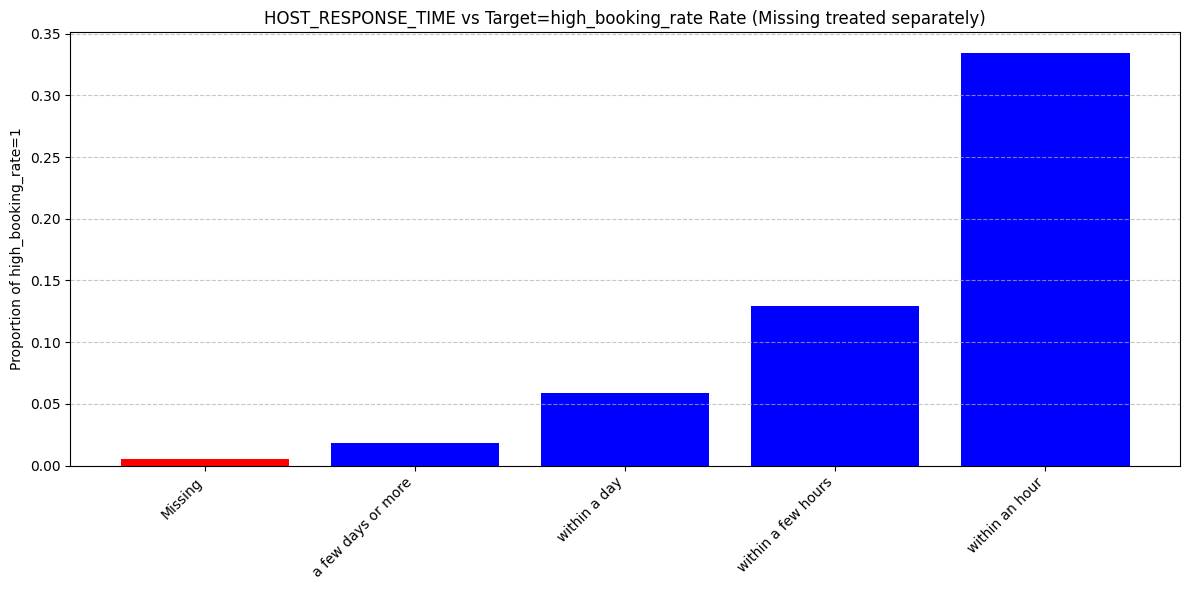

In [49]:
# 19. host_response_time - how long it takes the host to respond to requests

analyze_categorical(train_2, 'host_response_time')
analyze_categorical_missing_bin_trend(train_2, 'host_response_time')

Looks like a pretty strong indicator

In [50]:
# TRANSFORMATION - host_response_time
response_time_map = {
    'a few days or more': 0,
    'within a day': 1,
    'within a few hours': 2,
    'within an hour': 3,
    np.nan: -1  # missing as a separate bin
}

train_2['host_response_time_encoded'] = train_2['host_response_time'].map(response_time_map)

#drop original
train_2.drop(columns=['host_response_time'], inplace=True)



# for test_x
# TRANSFORMATION - host_response_time

test_x['host_response_time_encoded'] = test_x['host_response_time'].map(response_time_map)

#drop original
test_x.drop(columns=['host_response_time'], inplace=True)


--- room_type ---
Unique: 3
Missing: 0 (0.0%)

Top categories:
 room_type
Entire home/apt    55507
Private room       33970
Shared room         2590
Name: count, dtype: int64


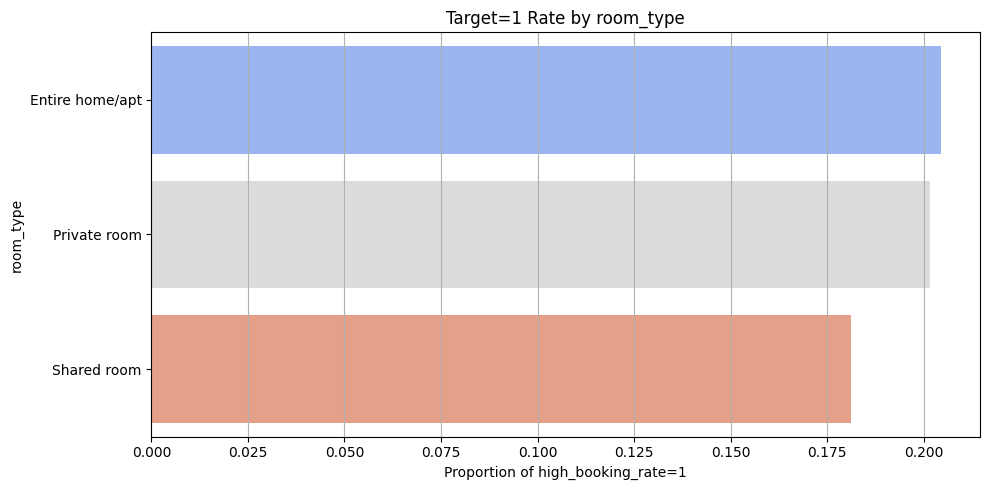

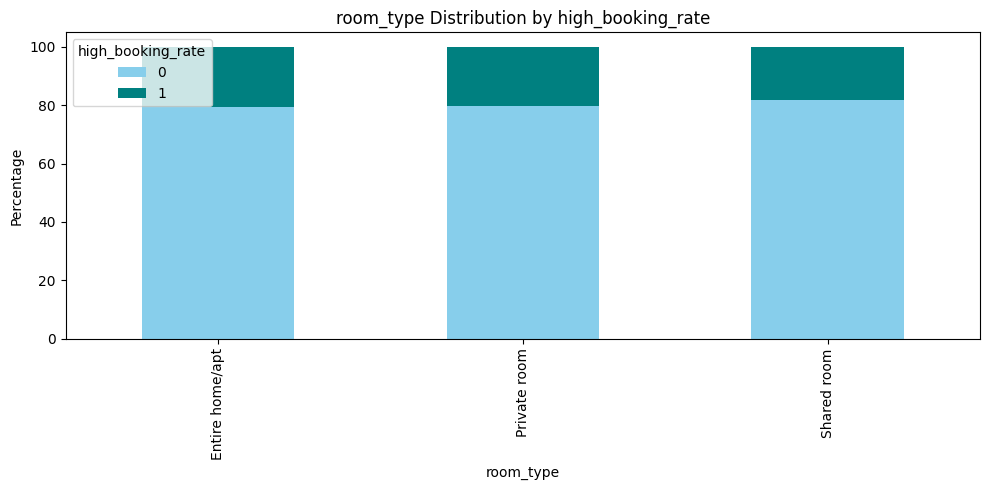

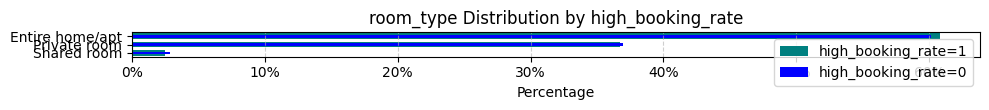

Chi-square test: χ²=8.69, dof=2, p=0.0129
Feature: 'room_type'
  → Missing: 0 / 92067 rows (0.00%)
  → Unique (non-missing): 3


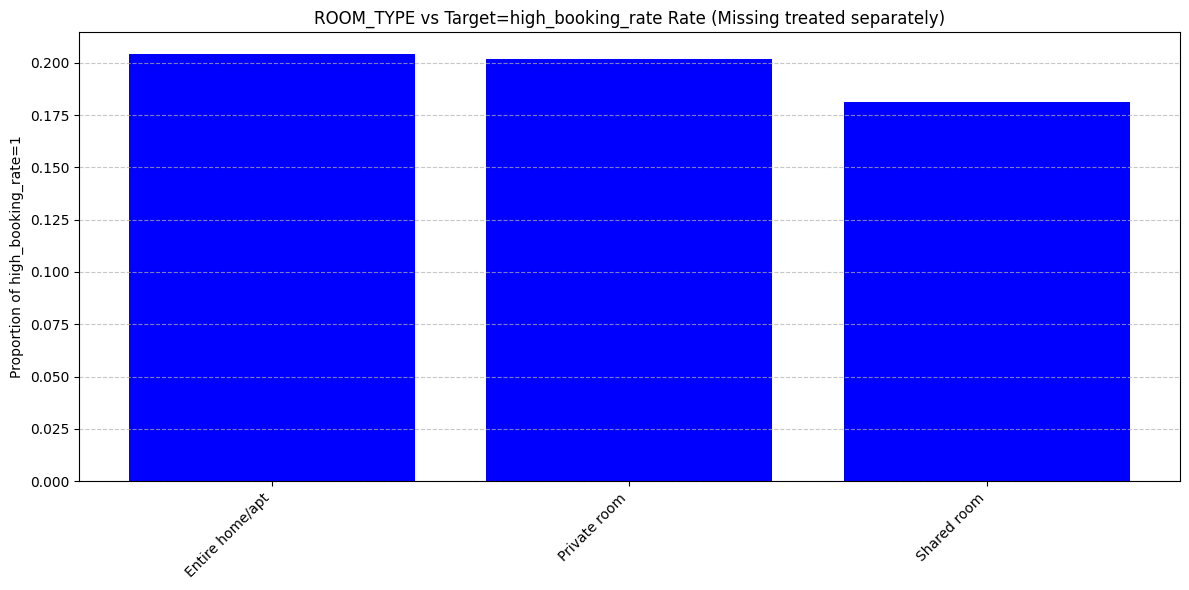

In [51]:
#20. room_type - description of the type of accomodation of the listing

analyze_categorical(train_2, 'room_type')
analyze_categorical_missing_bin_trend(train_2, 'room_type')

In [52]:
#TRANSFORMATION - room_type
# Manual encoding map
room_type_map = {
    'Entire home/apt': 0,
    'Private room': 1,
    'Shared room': 2
}

# Apply encoding
train_2['room_type_encoded'] = train_2['room_type'].map(room_type_map)

# Drop original
train_2.drop(columns=['room_type'], inplace=True)



#for test_x
# Apply encoding
test_x['room_type_encoded'] = test_x['room_type'].map(room_type_map)

# Drop original
test_x.drop(columns=['room_type'], inplace=True)


--- property_type ---
Unique: 36
Missing: 3 (0.0%)

Top categories:
 property_type
Apartment             51807
House                 29440
Condominium            3163
Townhouse              1927
Loft                   1638
Bed & Breakfast         761
Other                   736
Guesthouse              697
Bungalow                541
Dorm                    230
Villa                   201
Cabin                   188
Camper/RV               160
Boutique hotel          105
Hostel                   91
Boat                     81
Timeshare                76
Guest suite              44
Tent                     31
Serviced apartment       26
Name: count, dtype: int64


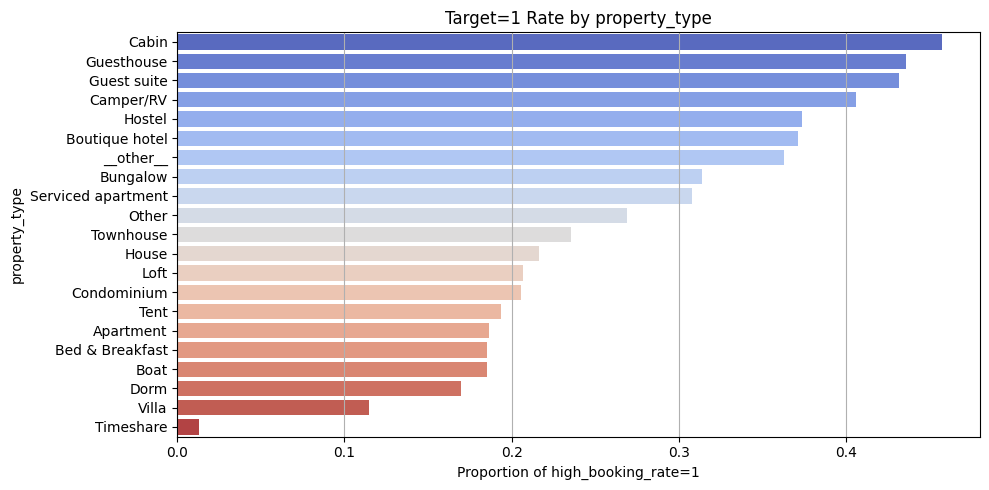

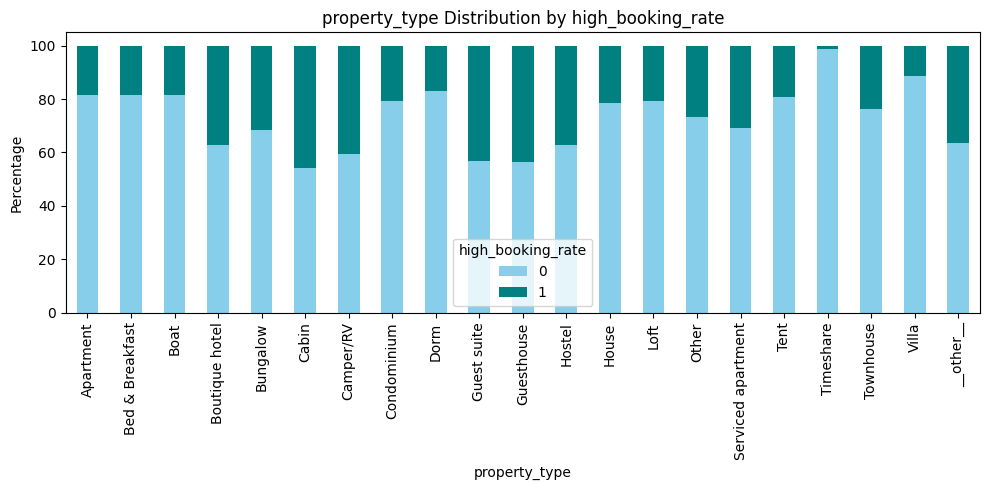

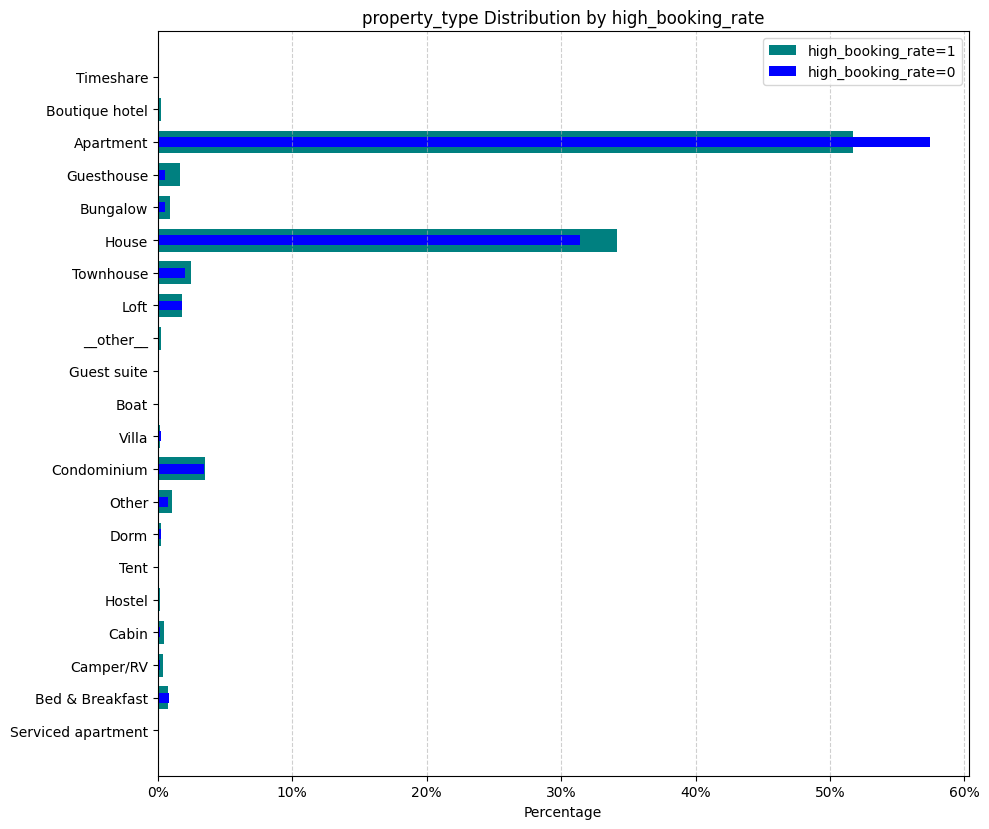

Chi-square test: χ²=648.80, dof=20, p=0.0000
Feature: 'property_type'
  → Missing: 3 / 92067 rows (0.00%)
  → Unique (non-missing): 35


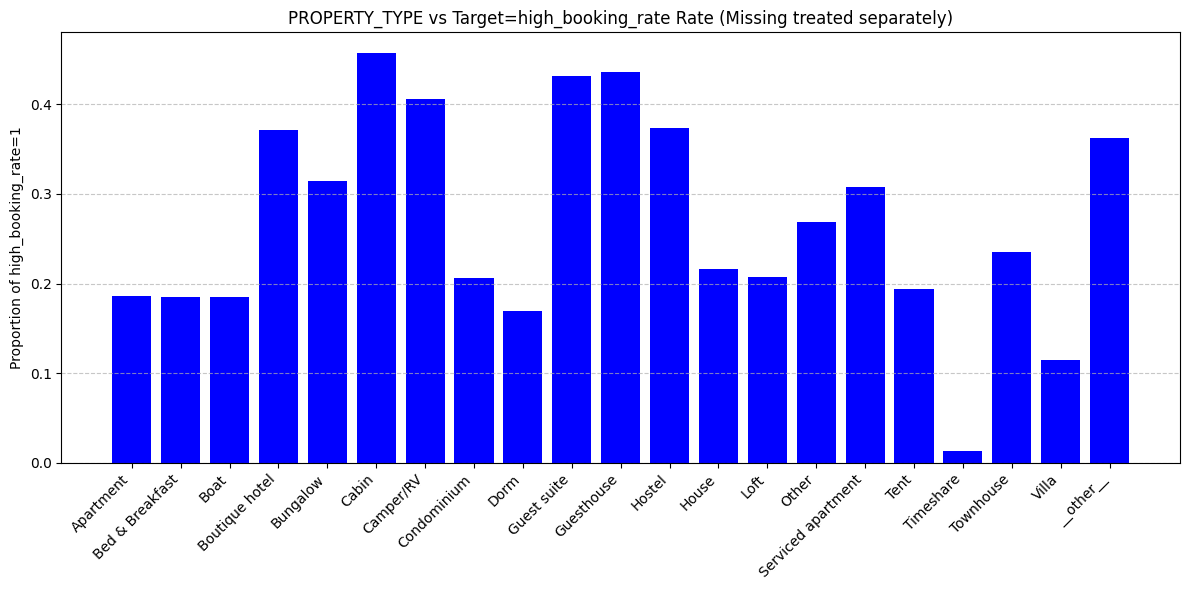

In [53]:
#20. property_type - description of the type of dwelling the listing is in

analyze_categorical(train_2, 'property_type')
analyze_categorical_missing_bin_trend(train_2, 'property_type')

High cardinality: You have 36 unique values (some rare, some common). One-hot encoding would be sparse and inefficient.

Meaningful target signal: The third chart clearly shows some property_type categories (e.g., Cabin, Camper/RV, Guesthouse) have noticeably higher booking rates than others (like Apartment, Dorm, Villa), meaning the variable has predictive value.

No obvious natural ordering: Categories like Bungalow, Hostel, Condominium are not ordinal, so label encoding without embedding wouldn’t make sense.

Well-handled rare categories: You already have _other__ and Other, which can help reduce overfitting on rare categories during embedding.

In [54]:
# TRANSFORMATION property_type
property_mapping = {
    'Apartment': 0,
    'House': 1,
    'Condominium': 2,
    'Townhouse': 3,
    'Loft': 4,
    'Bed & Breakfast': 5,
    'Other': 6,
    'Guesthouse': 7,
    'Bungalow': 8,
    'Dorm': 9,
    'Villa': 10,
    'Cabin': 11,
    'Camper/RV': 12,
    'Boutique hotel': 13,
    'Hostel': 14,
    'Boat': 15,
    'Timeshare': 16,
    'Guest suite': 17,
    'Tent': 18,
    'Serviced apartment': 19,
    '__other__': 20,
    'Missing': 21  # for NaNs
}

train_2['property_type_filled'] = train_2['property_type'].fillna('Missing')
train_2['property_type_encoded'] = train_2['property_type_filled'].map(property_mapping)

# Drop original
train_2.drop(columns=['property_type','property_type_filled'], inplace=True)



#for test_x
test_x['property_type_filled'] = test_x['property_type'].fillna('Missing')
test_x['property_type_encoded'] = test_x['property_type_filled'].map(property_mapping)

# Drop original
test_x.drop(columns=['property_type','property_type_filled'], inplace=True)


I feel we are more or less done with basic eda and some transformations. Now lets make some of Harini's variables

In [55]:
train_2.head()

host_verifications   latitude   longitude  \
0                email,phone,reviews,jumio,kba  40.801020  -73.954007   
1  email,phone,facebook,reviews,kba,work_email  37.745306 -122.411218   
2                      email,phone,reviews,kba  40.701036  -73.918769   
3                          email,phone,reviews  40.771044  -73.956285   
4      email,phone,reviews,jumio,government_id  40.760605  -73.917666   

   accommodates  bathrooms  bedrooms  beds  bed_type  \
0             2        1.0       2.0   1.0  Real Bed   
1             4        1.0       2.0   2.0  Real Bed   
2             2        1.0       1.0   1.0  Real Bed   
3             6        1.0       1.0   1.0  Real Bed   
4             1        1.0       1.0   1.0  Real Bed   

                                           amenities  cleaning_fee  \
0  TV,Wireless Internet,Air conditioning,Kitchen,...          10.0   
1  TV,Cable TV,Internet,Wireless Internet,Kitchen...         125.0   
2  TV,Internet,Wireless Internet,Air conditioning...          20.0   
3  Cable TV,Wireless Internet,Air conditioning,Po...          85.0   
4  TV,Internet,Wireless Internet,Air conditioning...           NaN   

   minimum_nights  maximum_nights  availability_30  availability_60  \
0               3            1125               12               42   
1               5              29                0                0   
2               3            1125               30               60   
3               1             365               10               33   
4               1            1125                0                1   

   availability_90  availability_365 cancellation_policy  high_booking_rate  \
0               72                72              strict                  0   
1                0                 0              strict                  0   
2               90               365              strict                  0   
3               63               338              strict                  0   
4                1                17            flexible                  0   

   price_per_guest  availability_rate_30  availability_rate_365  \
0        23.333333              0.400000               0.197260   
1        50.000000              0.000000               0.000000   
2        33.333333              1.000000               1.000000   
3        26.428571              0.333333               0.926027   
4        17.500000              0.000000               0.046575   

   has_security_deposit  booking_pressure  price_x_avail  price_x_guests  \
0                     1                 0         5040.0            70.0   
1                     1                 1            0.0           500.0   
2                     1                 0        36500.0           100.0   
3                     0                 0        62530.0           370.0   
4                     0                 0          595.0            35.0   

   rooms_per_guest  bathrooms_per_guest  price_per_bedroom  lat_long_product  \
0         1.500000             1.000000          23.333333      -3017.398874   
1         1.000000             0.666667          83.333333      -4620.448941   
2         1.000000             1.000000          50.000000      -3008.570496   
3         0.666667             0.666667          92.500000      -3015.274965   
4         1.000000             1.000000          17.500000      -3012.928802   

   min_night_bin  host_acceptance_rate_binned  \
0            1.0                            0   
1            1.0                            0   
2            1.0                            0   
3            0.0                            0   
4            0.0                            0   

   security_deposit_binned_encoded  price_log  extra_people_log  \
0                                0   4.262680          0.000000   
1                                6   5.525453          3.044522   
2                                0   4.615121          0.000000   
3                        

In [56]:
train_2.shape

(92067, 41)

In [57]:
train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92067 entries, 0 to 92066
Data columns (total 41 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   host_verifications               91898 non-null  object 
 1   latitude                         92067 non-null  float64
 2   longitude                        92067 non-null  float64
 3   accommodates                     92067 non-null  int64  
 4   bathrooms                        91786 non-null  float64
 5   bedrooms                         91954 non-null  float64
 6   beds                             91976 non-null  float64
 7   bed_type                         92067 non-null  object 
 8   amenities                        91679 non-null  object 
 9   cleaning_fee                     71887 non-null  float64
 10  minimum_nights                   92067 non-null  int64  
 11  maximum_nights                   92067 non-null  int64  
 12  availability_30   

In [58]:
num_features = [feature for feature in train_2.columns if train_2[feature].dtype in ['float64', 'int64','int8']]
cat_features = [feature for feature in train_2.columns if feature not in num_features]

In [59]:
cat_features

['host_verifications', 'bed_type', 'amenities', 'cancellation_policy']


--- cancellation_policy ---
Unique: 6
Missing: 0 (0.0%)

Top categories:
 cancellation_policy
strict             43312
moderate           27090
flexible           21385
super_strict_30      180
super_strict_60       95
no_refunds             5
Name: count, dtype: int64


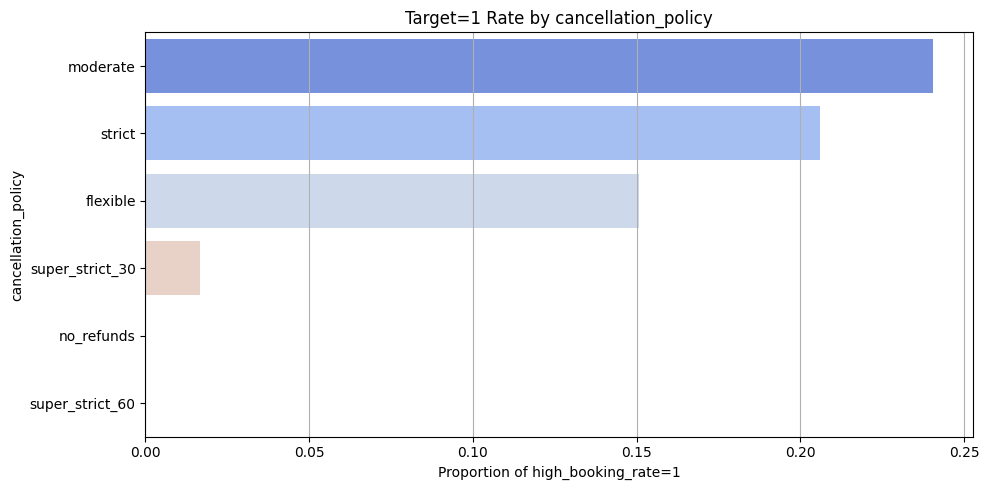

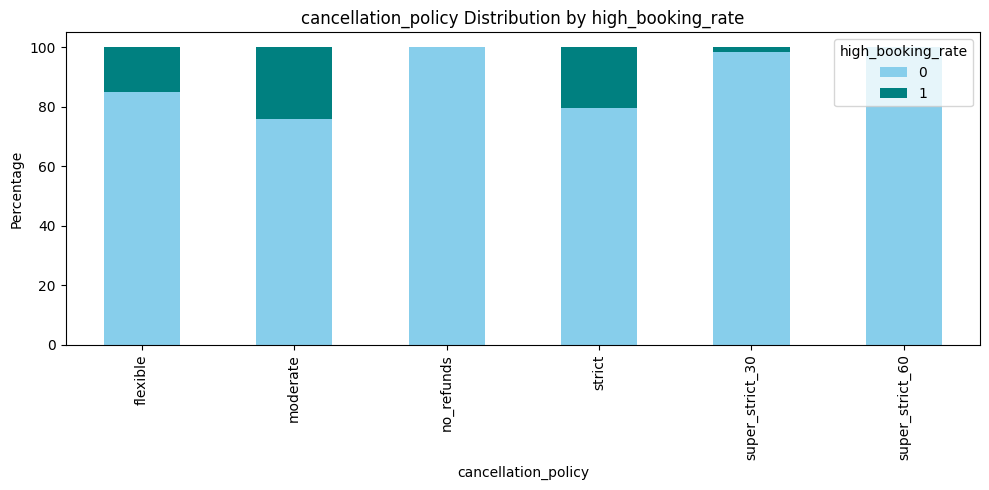

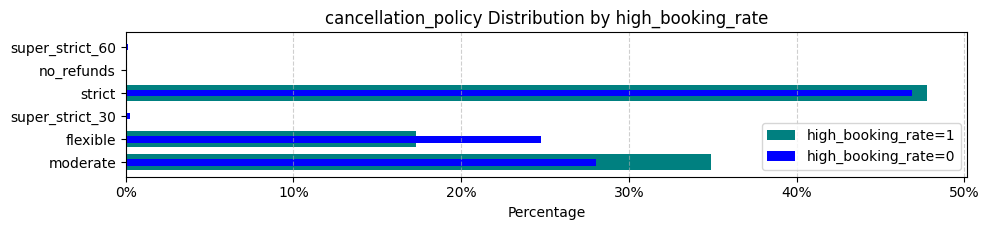

Chi-square test: χ²=663.64, dof=5, p=0.0000
Feature: 'cancellation_policy'
  → Missing: 0 / 92067 rows (0.00%)
  → Unique (non-missing): 6


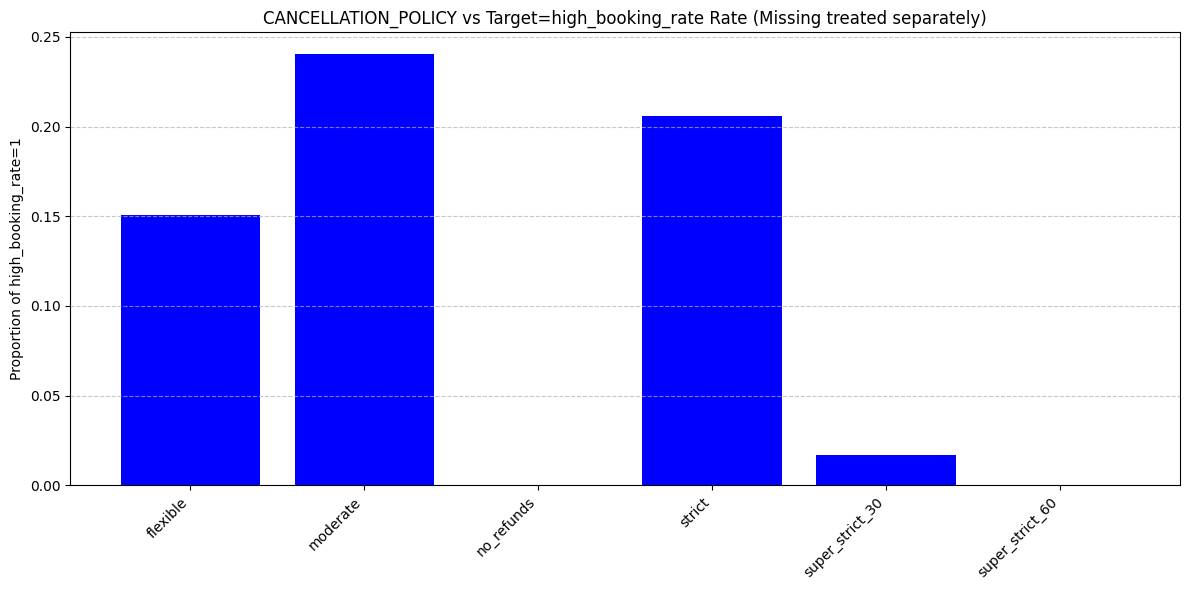

In [60]:
# 21. cancellation_policy - description of how strict the cancellation policy is
analyze_categorical(train_2, 'cancellation_policy')
analyze_categorical_missing_bin_trend(train_2, 'cancellation_policy')

In [61]:
# Define rare policies
rare_policies = ['no_refunds', 'super_strict_30', 'super_strict_60']

# Replace rare with 'other'
train_2['cancellation_policy_clean'] = train_2['cancellation_policy'].apply(
    lambda x: 'other' if x in rare_policies else x
)

# Apply manual ordinal encoding
cancellation_policy_mapping = {
    'other': 0,
    'flexible': 1,
    'moderate': 2,
    'strict': 3
}

train_2['cancellation_policy_encoded'] = train_2['cancellation_policy_clean'].map(cancellation_policy_mapping)

# Optional: drop intermediate/old columns
train_2.drop(columns=['cancellation_policy', 'cancellation_policy_clean'], inplace=True)





#for test_x
# Define rare policies
rare_policies = ['no_refunds', 'super_strict_30', 'super_strict_60']

# Replace rare with 'other'
test_x['cancellation_policy_clean'] = test_x['cancellation_policy'].apply(
    lambda x: 'other' if x in rare_policies else x
)

# Apply manual ordinal encoding
cancellation_policy_mapping = {
    'other': 0,
    'flexible': 1,
    'moderate': 2,
    'strict': 3
}

test_x['cancellation_policy_encoded'] = test_x['cancellation_policy_clean'].map(cancellation_policy_mapping)

# Optional: drop intermediate/old columns
test_x.drop(columns=['cancellation_policy', 'cancellation_policy_clean'], inplace=True)


--- bed_type ---
Unique: 5
Missing: 0 (0.0%)

Top categories:
 bed_type
Real Bed         89426
Futon             1064
Pull-out Sofa      748
Airbed             544
Couch              285
Name: count, dtype: int64


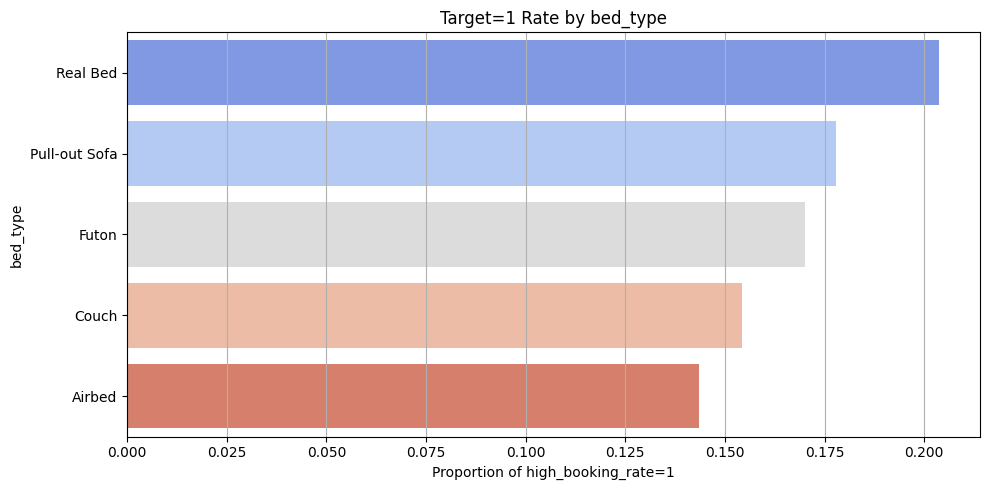

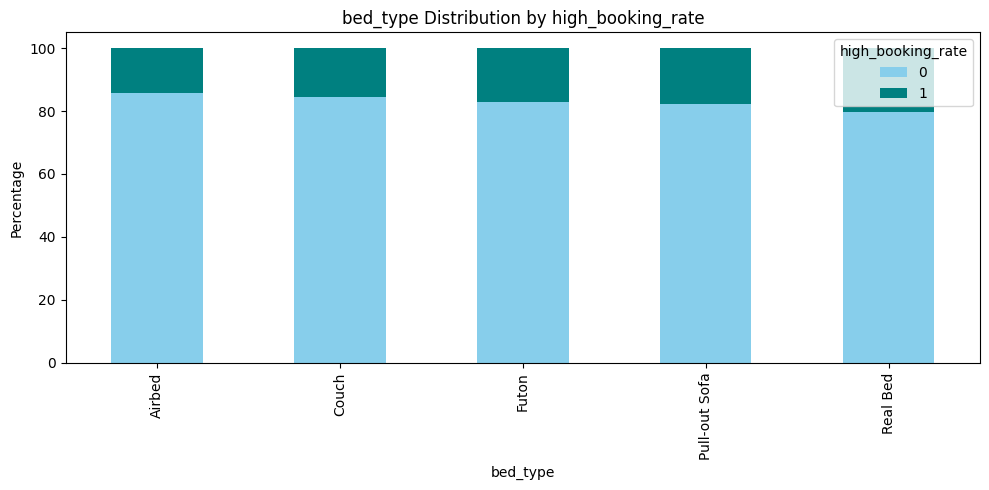

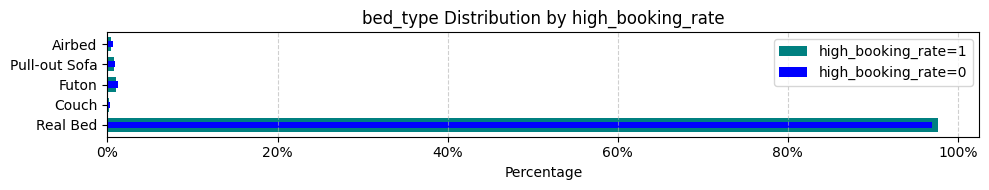

Chi-square test: χ²=26.50, dof=4, p=0.0000
Feature: 'bed_type'
  → Missing: 0 / 92067 rows (0.00%)
  → Unique (non-missing): 5


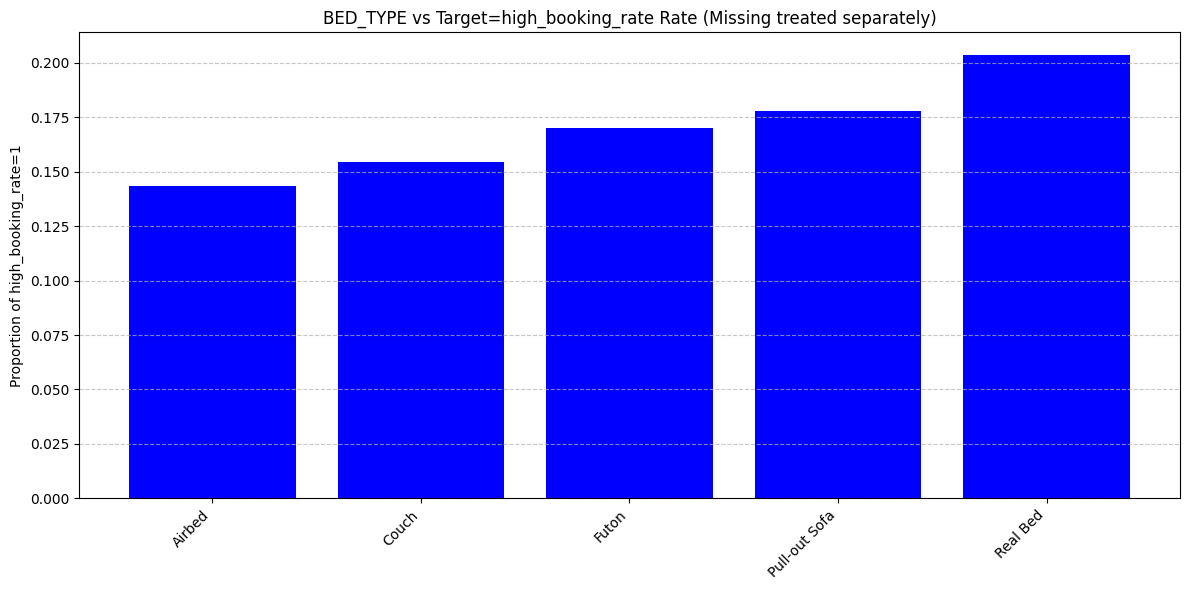

In [62]:
# 22. bed_type
analyze_categorical(train_2, 'bed_type')
analyze_categorical_missing_bin_trend(train_2, 'bed_type')

In [63]:
# TRANSFORMATION - bed_type
bed_type_mapping = {
    'Real Bed': 0,
    'Futon': 1,
    'Pull-out Sofa': 2,
    'Airbed': 3,
    'Couch': 4
}

train_2['bed_type_encoded'] = train_2['bed_type'].map(bed_type_mapping)

#drop original
train_2.drop(columns=['bed_type'], inplace = True)


#for test_x
test_x['bed_type_encoded'] = test_x['bed_type'].map(bed_type_mapping)

#drop original
test_x.drop(columns=['bed_type'], inplace = True)

In [64]:
# for now dropping host_verifications and amenities
train_2.drop(columns=['host_verifications','amenities'],inplace=True)

test_x.drop(columns=['host_verifications','amenities'],inplace=True)


--- cleaning_fee DESCRIBE ---
                count       mean        std  min   25%   50%   75%    max
cleaning_fee  71887.0  66.942716  54.801368  0.0  29.0  50.0  90.0  950.0
Skewness: 2.428, Kurtosis: 12.380
Missing: 20180 (21.9%); Unique: 278


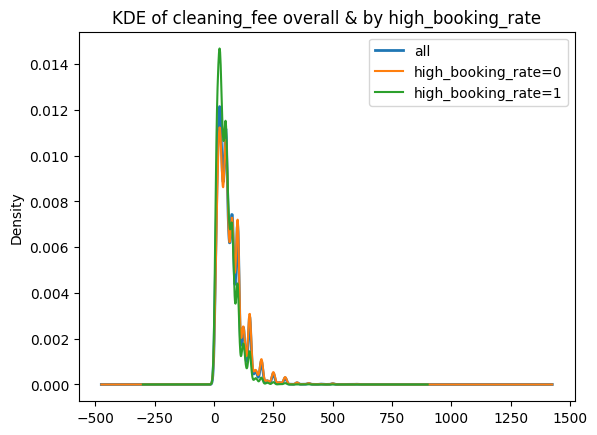

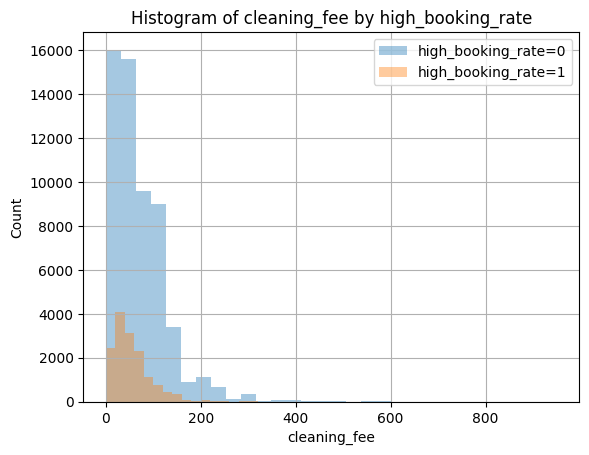

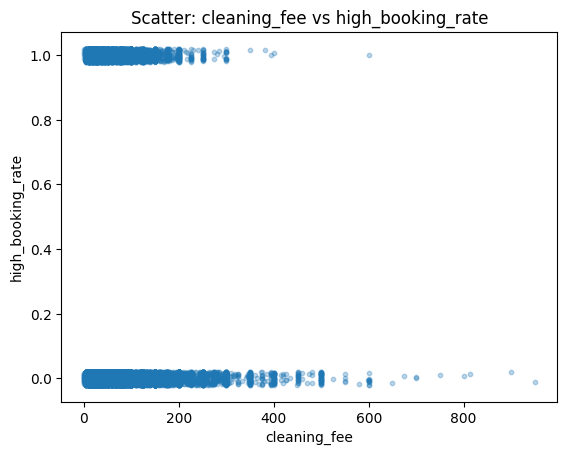


Top 3 correlated features with cleaning_fee:
                  corr
accommodates  0.596762
bedrooms      0.589112
beds          0.558532


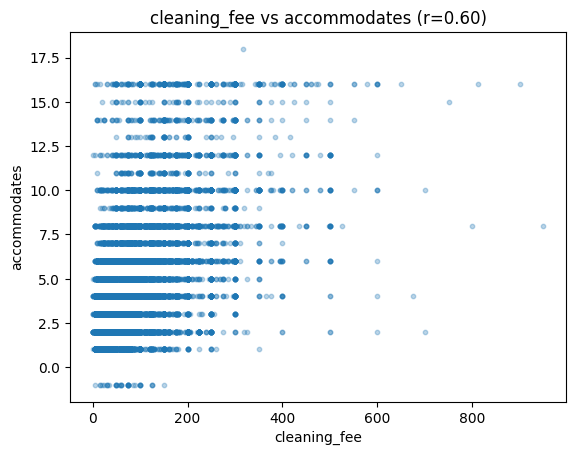

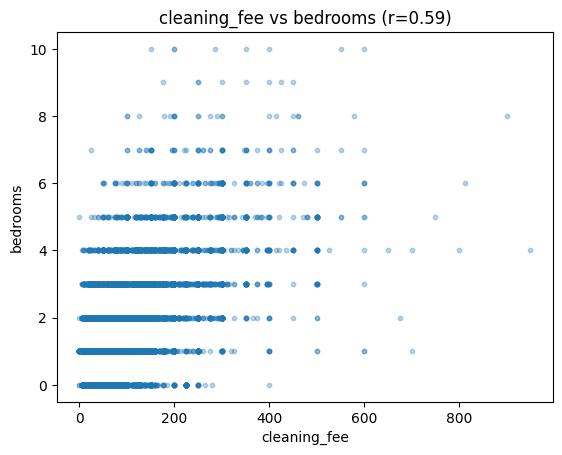

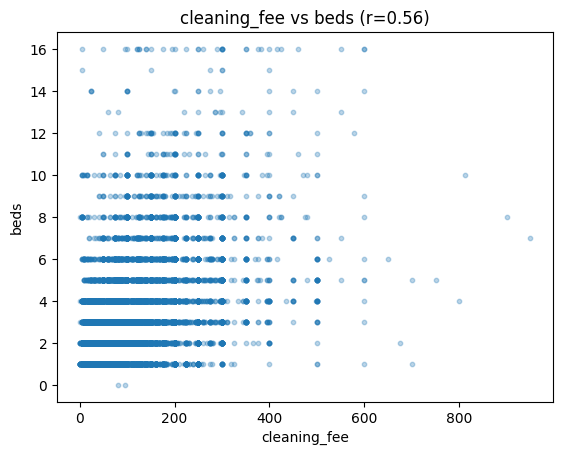

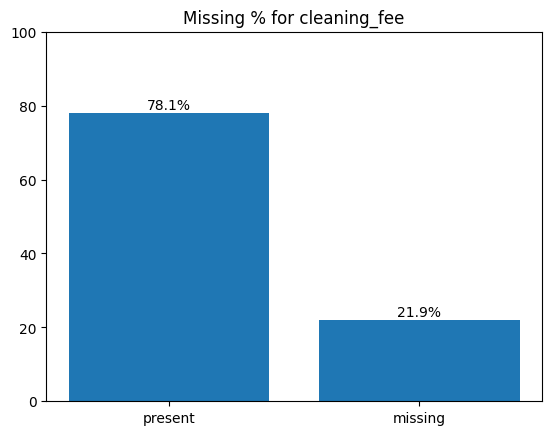


Outliers (<-62.50 or >181.50): 2673 rows, 2.90%


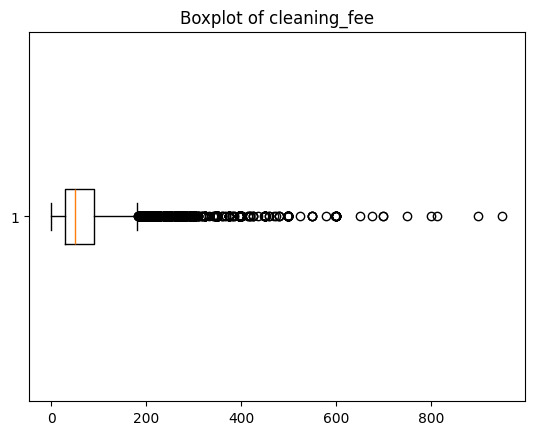

<Figure size 640x480 with 0 Axes>

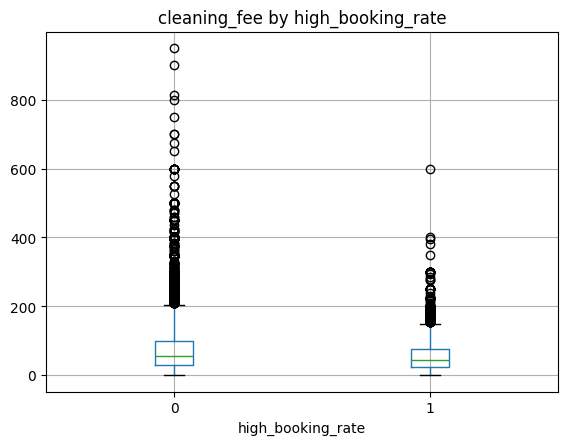


Point-biserial corr: r=-0.140, p=1.09e-312
T-test: t=-37.990, p=0


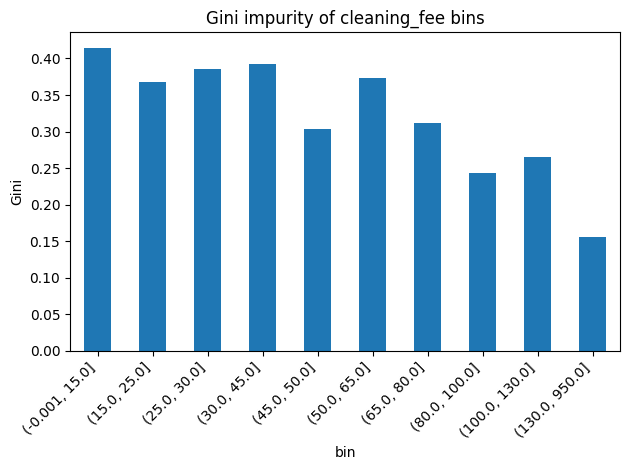

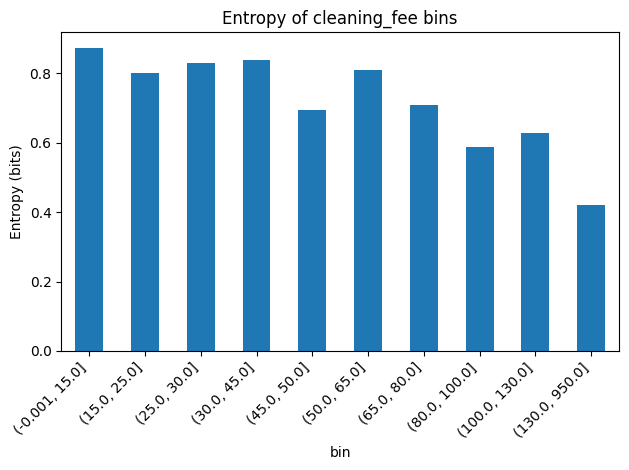

Feature: 'cleaning_fee'
  → Missing: 20180 / 92067 rows (21.92%)


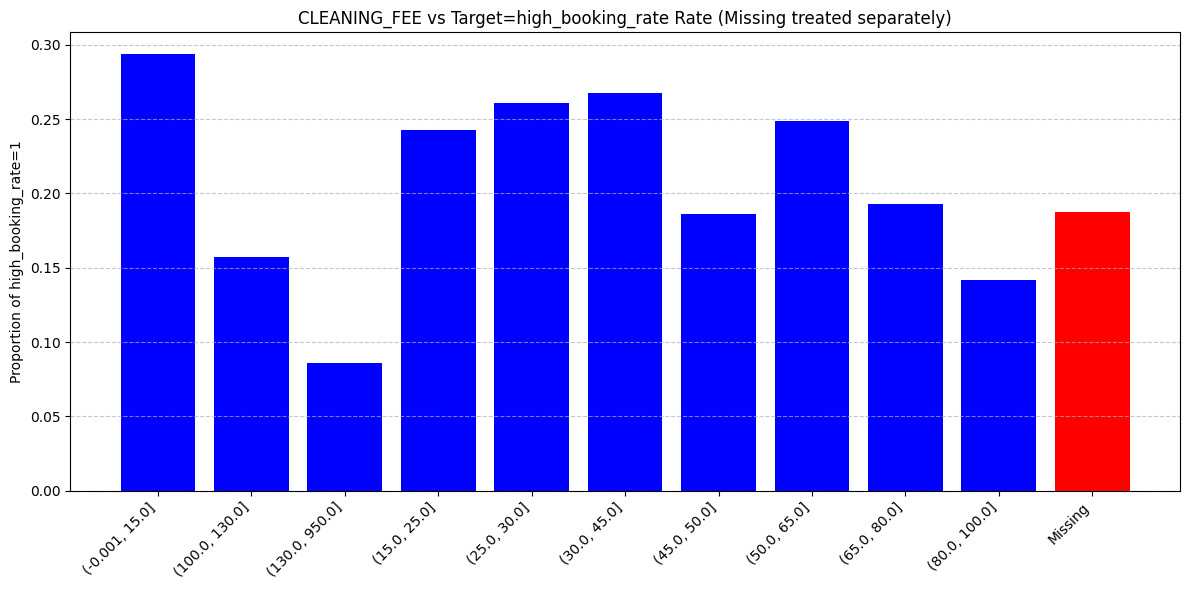

In [65]:
# 23. cleaning_fee - how much, if any, is the cleaning fee the host charges
analyze_numeric(train_2, 'cleaning_fee')
analyze_missing_value_bin_trend(train_2, 'cleaning_fee')


In [66]:
#TRANSFORMATION - cleaning_fee
train_2['has_cleaning_fee'] = train_2['cleaning_fee'].notna().astype(int)

train_2['cleaning_fee_filled'] = train_2['cleaning_fee'].fillna(0)

train_2['cleaning_fee_log1p'] = np.log1p(train_2['cleaning_fee_filled'])
# Optional: drop original
train_2.drop(columns=['cleaning_fee','cleaning_fee_filled'], inplace=True)





#for test_x
#TRANSFORMATION - cleaning_fee
test_x['has_cleaning_fee'] = test_x['cleaning_fee'].notna().astype(int)

test_x['cleaning_fee_filled'] = test_x['cleaning_fee'].fillna(0)

test_x['cleaning_fee_log1p'] = np.log1p(test_x['cleaning_fee_filled'])
# Optional: drop original
test_x.drop(columns=['cleaning_fee','cleaning_fee_filled'], inplace=True)


--- availability_30 DESCRIBE ---
                   count       mean        std  min  25%  50%   75%   max
availability_30  92067.0  10.494173  10.487516  0.0  0.0  7.0  19.0  30.0
Skewness: 0.611, Kurtosis: -1.050
Missing: 0 (0.0%); Unique: 31


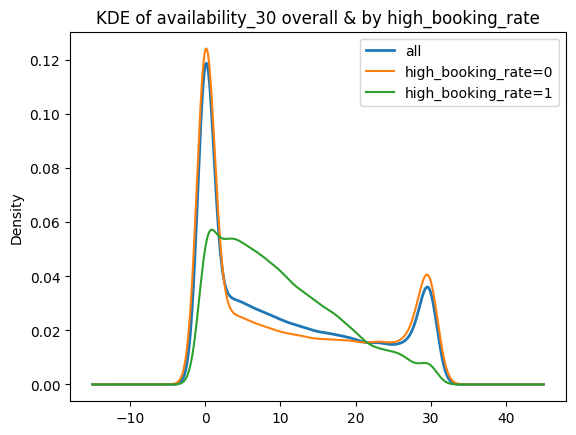

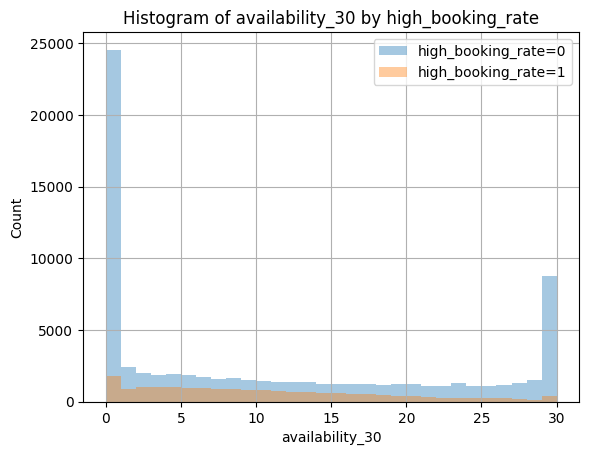

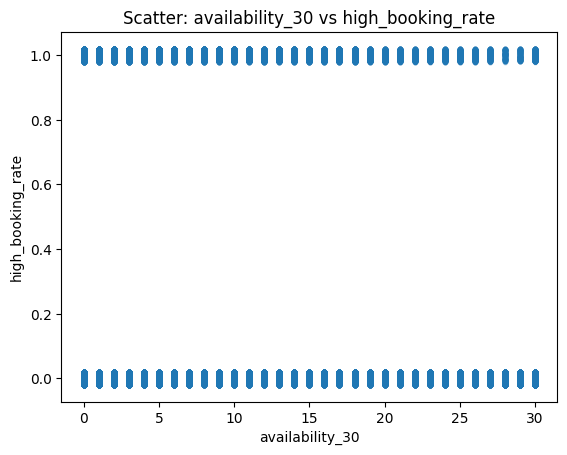


Top 3 correlated features with availability_30:
                          corr
availability_rate_30  1.000000
availability_60       0.922987
availability_90       0.851872


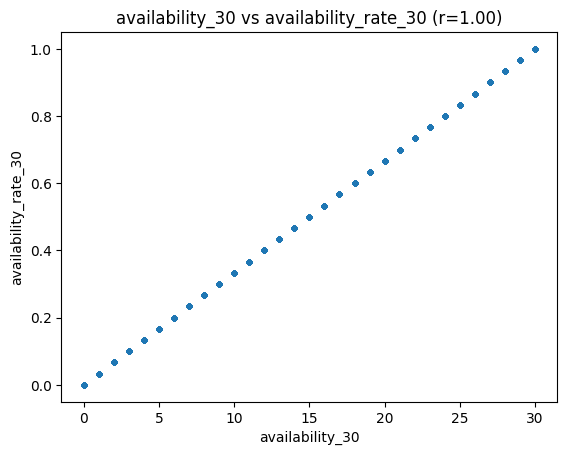

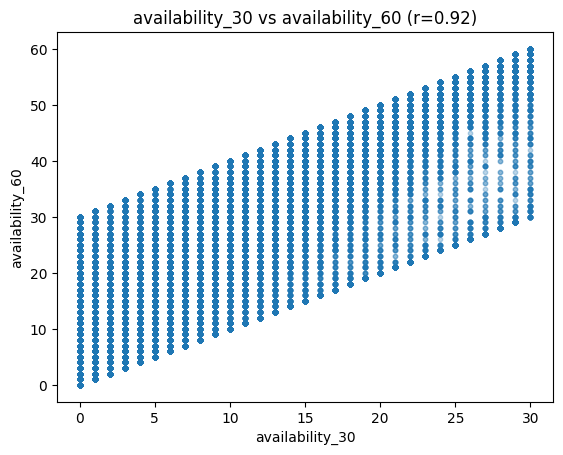

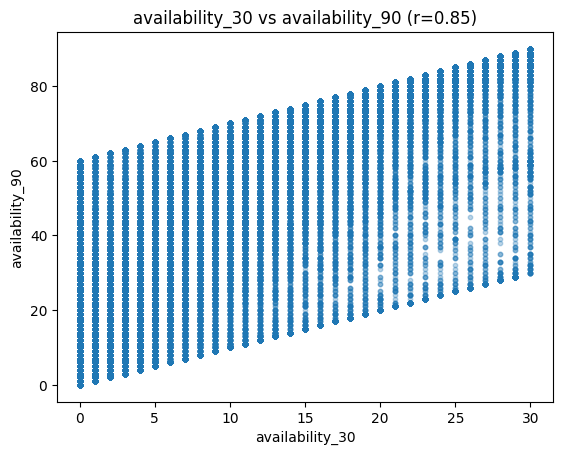

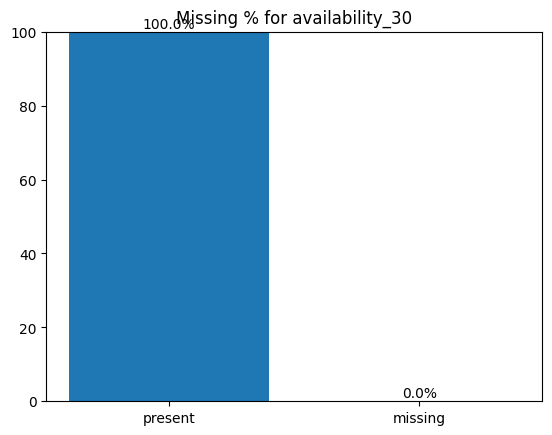


Outliers (<-28.50 or >47.50): 0 rows, 0.00%


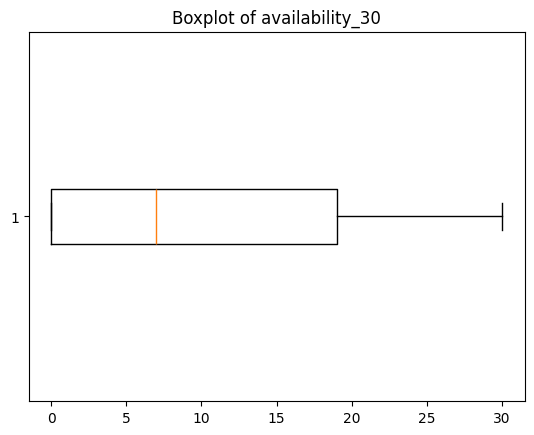

<Figure size 640x480 with 0 Axes>

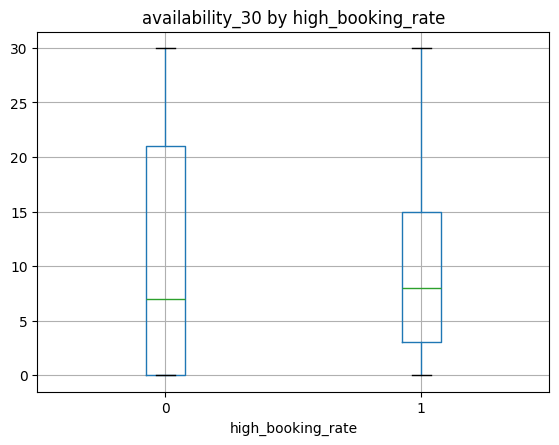


Point-biserial corr: r=-0.028, p=2.27e-17
T-test: t=-8.481, p=2.27e-17


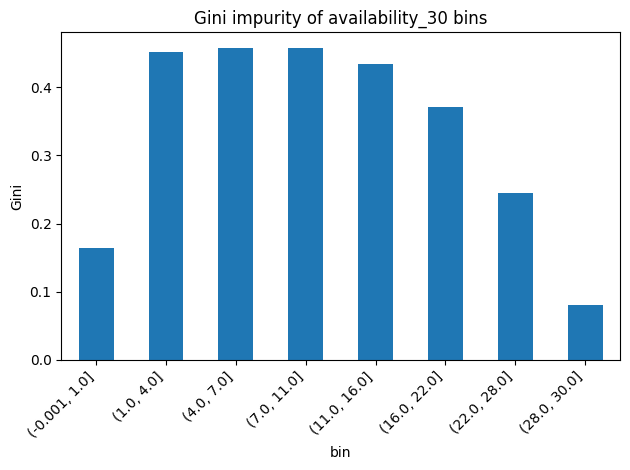

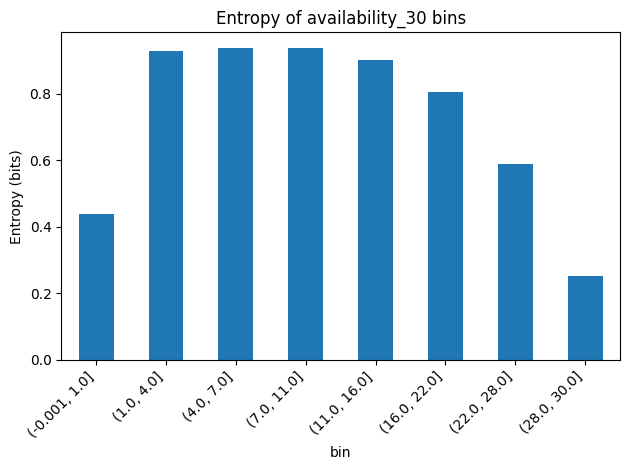

Feature: 'availability_30'
  → Missing: 0 / 92067 rows (0.00%)


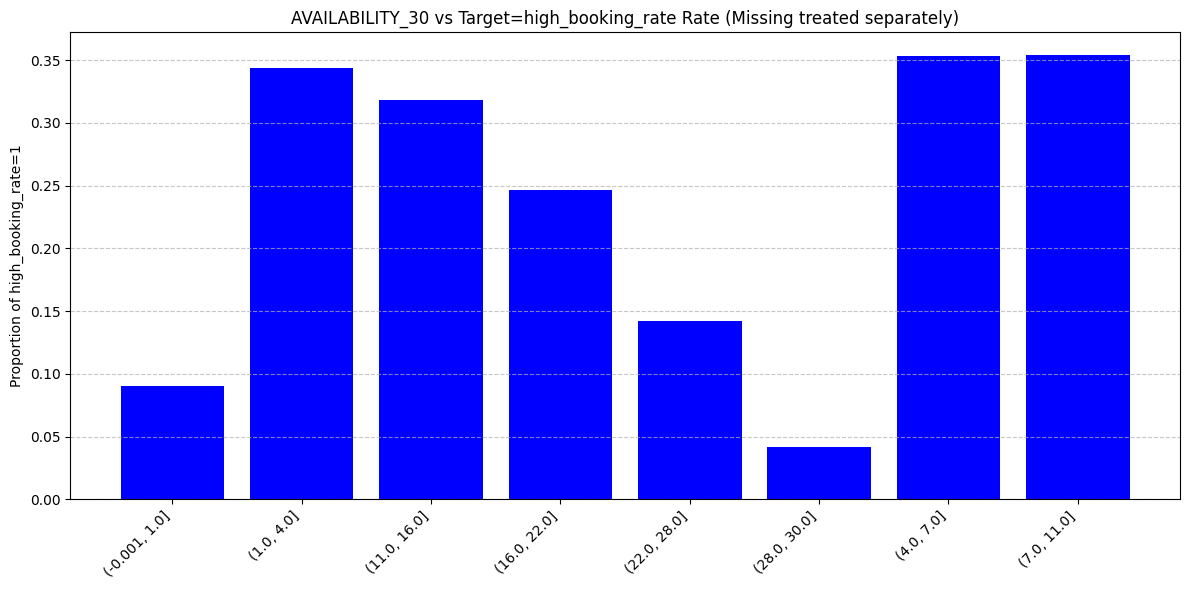

In [67]:
#24. availability_30 - how many days out of the next 30 the listing is available for
analyze_numeric(train_2, 'availability_30')
analyze_missing_value_bin_trend(train_2, 'availability_30')


In [68]:
#TRANSFORMATION - availability_30
# Log transform to compress scale, add +1 to avoid log(0)
train_2['availability_30_log'] = np.log1p(train_2['availability_30'])

# drop original
train_2.drop(columns=['availability_30'], inplace=True)




#for test_x
test_x['availability_30_log'] = np.log1p(test_x['availability_30'])

# drop original
test_x.drop(columns=['availability_30'], inplace=True)

In [69]:
#25. availability_365 - how many days out of the next 365 the listing is available for
#TRANSFORMATION - availability_365

# Log transform to compress scale, add +1 to avoid log(0)
train_2['availability_365_log'] = np.log1p(train_2['availability_365'])

# drop original
train_2.drop(columns=['availability_365'], inplace=True)

#for test_x
test_x['availability_365_log'] = np.log1p(test_x['availability_365'])

# drop original
test_x.drop(columns=['availability_365'], inplace=True)



--- bathrooms DESCRIBE ---
             count      mean       std  min  25%  50%  75%  max
bathrooms  91786.0  1.274067  0.625823  0.0  1.0  1.0  1.0  8.0
Skewness: 3.346, Kurtosis: 18.523
Missing: 281 (0.3%); Unique: 17


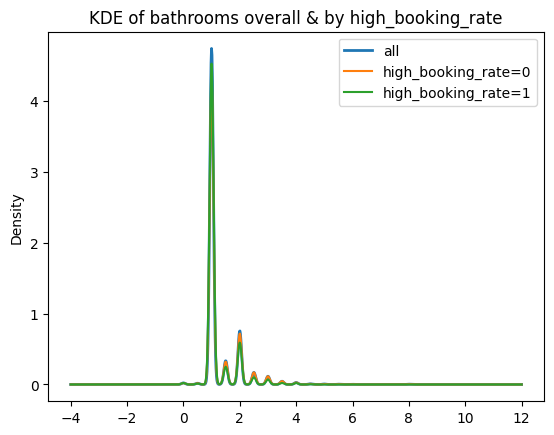

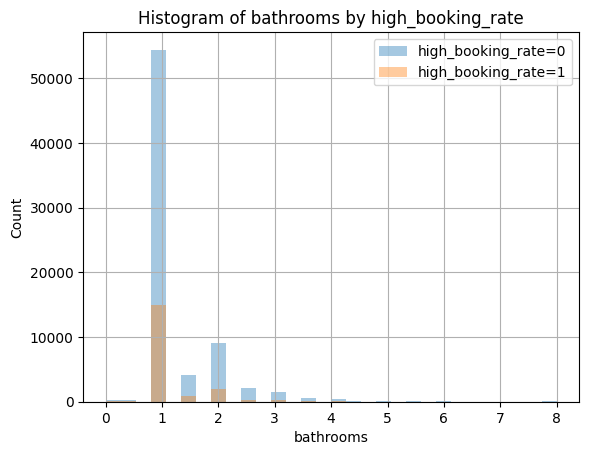

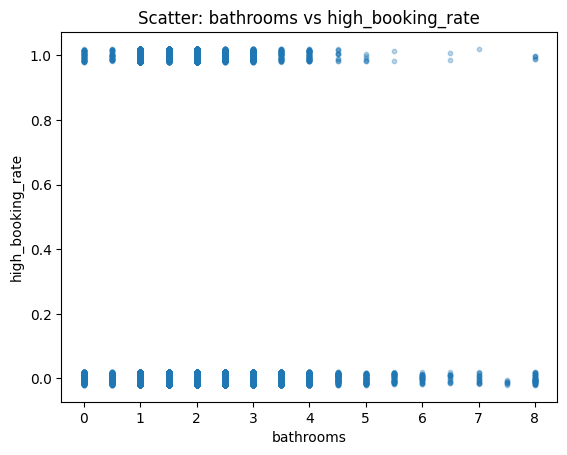


Top 3 correlated features with bathrooms:
                  corr
bedrooms      0.624630
beds          0.558986
accommodates  0.550761


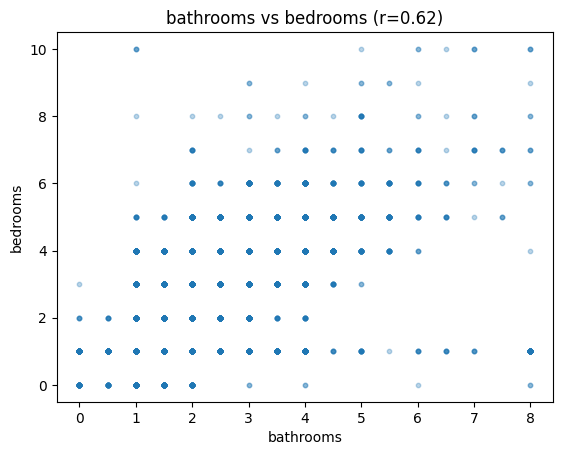

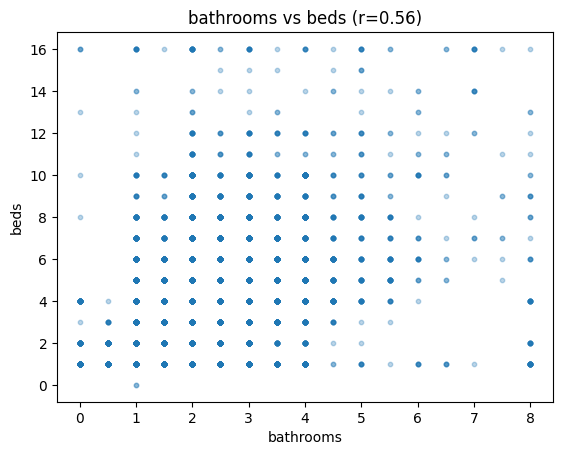

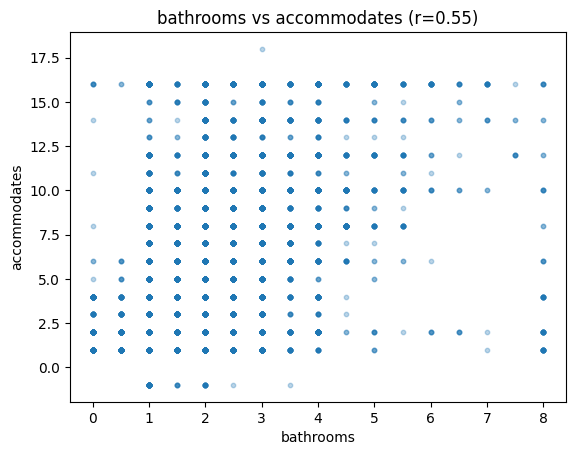

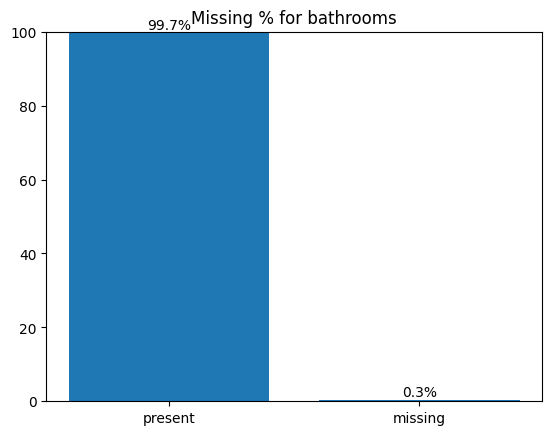


Outliers (<1.00 or >1.00): 22312 rows, 24.23%


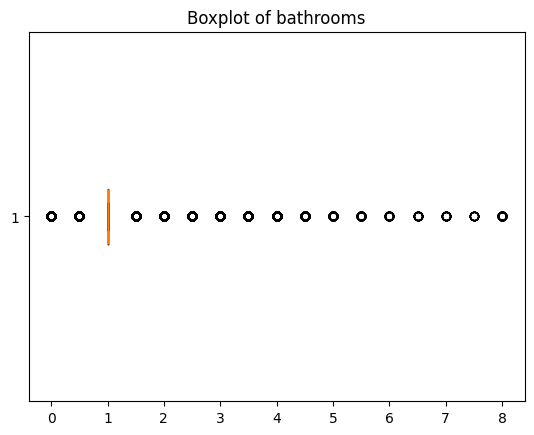

<Figure size 640x480 with 0 Axes>

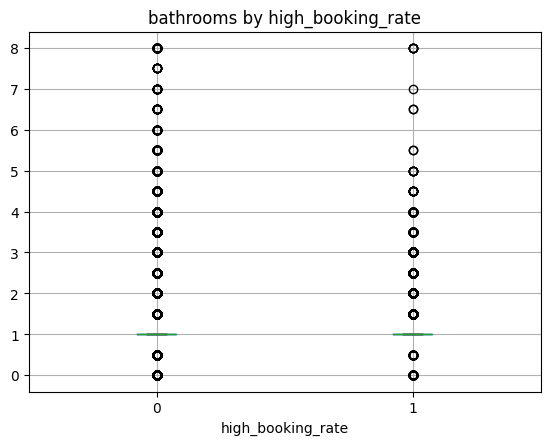


Point-biserial corr: r=-0.060, p=8.28e-73
T-test: t=-18.063, p=8.28e-73


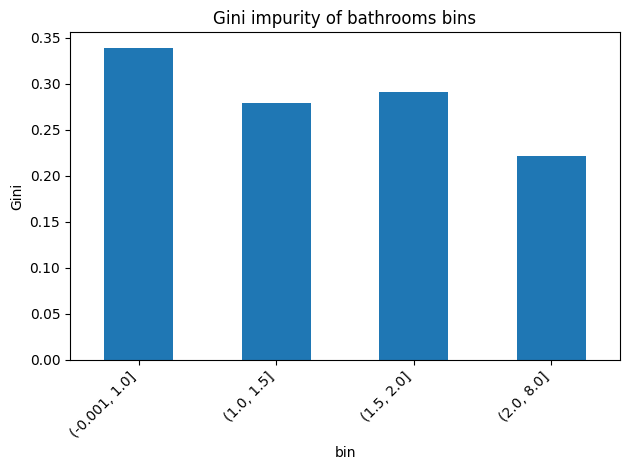

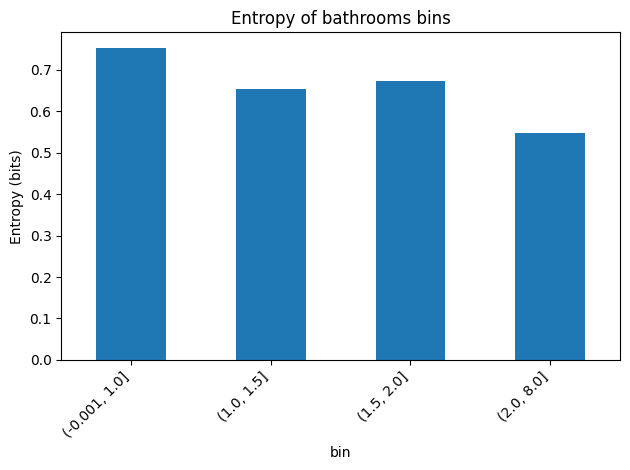

Feature: 'bathrooms'
  → Missing: 281 / 92067 rows (0.31%)


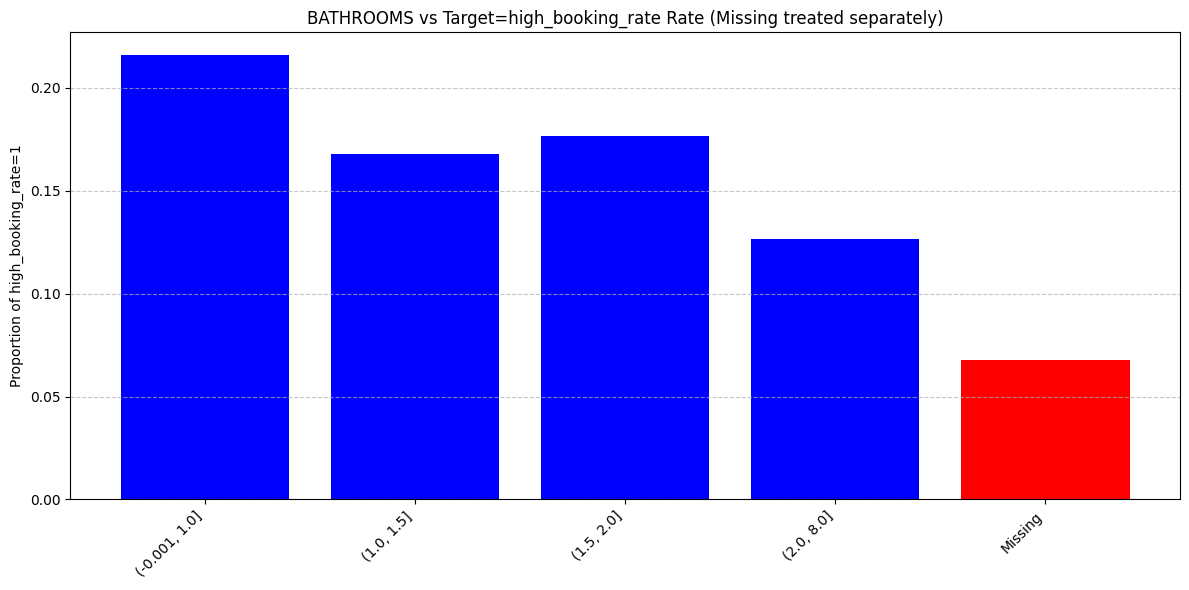

In [70]:
# 26. bathrooms - number of bathrooms in the listing
analyze_numeric(train_2, 'bathrooms')
analyze_missing_value_bin_trend(train_2, 'bathrooms')

In [71]:
#missing value imputation - bathrooms
train_2['bathrooms'] = train_2['bathrooms'].fillna(-1)
train_2['bedrooms'] = train_2['bedrooms'].fillna(-1)
train_2['beds'] = train_2['beds'].fillna(-1)


#for test_x
test_x['bathrooms'] = test_x['bathrooms'].fillna(-1)
test_x['bedrooms'] = test_x['bedrooms'].fillna(-1)
test_x['beds'] = test_x['beds'].fillna(-1)

In [72]:
train_2.head()

latitude   longitude  accommodates  bathrooms  bedrooms  beds  \
0  40.801020  -73.954007             2        1.0       2.0   1.0   
1  37.745306 -122.411218             4        1.0       2.0   2.0   
2  40.701036  -73.918769             2        1.0       1.0   1.0   
3  40.771044  -73.956285             6        1.0       1.0   1.0   
4  40.760605  -73.917666             1        1.0       1.0   1.0   

   minimum_nights  maximum_nights  availability_60  availability_90  \
0               3            1125               42               72   
1               5              29                0                0   
2               3            1125               60               90   
3               1             365               33               63   
4               1            1125                1                1   

   high_booking_rate  price_per_guest  availability_rate_30  \
0                  0        23.333333              0.400000   
1                  0        50.000000              0.000000   
2                  0        33.333333              1.000000   
3                  0        26.428571              0.333333   
4                  0        17.500000              0.000000   

   availability_rate_365  has_security_deposit  booking_pressure  \
0               0.197260                     1                 0   
1               0.000000                     1                 1   
2               1.000000                     1                 0   
3               0.926027                     0                 0   
4               0.046575                     0                 0   

   price_x_avail  price_x_guests  rooms_per_guest  bathrooms_per_guest  \
0         5040.0            70.0         1.500000             1.000000   
1            0.0           500.0         1.000000             0.666667   
2        36500.0           100.0         1.000000             1.000000   
3        62530.0           370.0         0.666667             0.666667   
4          595.0            35.0         1.000000             1.000000   

   price_per_bedroom  lat_long_product  min_night_bin  \
0          23.333333      -3017.398874            1.0   
1          83.333333      -4620.448941            1.0   
2          50.000000      -3008.570496            1.0   
3          92.500000      -3015.274965            0.0   
4          17.500000      -3012.928802            0.0   

   host_acceptance_rate_binned  security_deposit_binned_encoded  price_log  \
0                            0                                0   4.262680   
1                            0                                6   5.525453   
2                            0                                0   4.615121   
3                            0                                8   5.225747   
4                            0                                8   3.583519   

   extra_people_log  guests_included_encoded  host_listings_count_log  \
0          0.000000                        3                 1.098612   
1          3.044522                        0                 1.098612   
2          0.000000                        3                 1.098612   
3          3.044522                        0                 1.098612   
4          0.000000                        3                 0.693147   

   host_account_age  listing_age_days  host_response_time_encoded  \
0            3587.0              3079                           3   
1            5817.0              4956                           2   
2            3751.0              3485                          -1   
3            5661.0              5496                           3   
4            3784.0              3374                          -1   

   room_type_encoded  property_type_encoded  cancellation_policy_encoded  \
0                  1                    0.0                            3   
1                  0                    2.0                            3   
2                  1               

In [73]:
some_more_drops = [
    'availability_60',
    'availability_90',
    'latitude',
    'longitude',
    'maximum_nights'
]

train_2 = train_2.drop(columns = some_more_drops, axis = 1)
test_x = test_x.drop(columns = some_more_drops, axis = 1)

In [74]:
train_3 = train_2.copy()

In [75]:
train_3.shape

(92067, 35)

In [76]:
train_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92067 entries, 0 to 92066
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   accommodates                     92067 non-null  int64  
 1   bathrooms                        92067 non-null  float64
 2   bedrooms                         92067 non-null  float64
 3   beds                             92067 non-null  float64
 4   minimum_nights                   92067 non-null  int64  
 5   high_booking_rate                92067 non-null  int64  
 6   price_per_guest                  92067 non-null  float64
 7   availability_rate_30             92067 non-null  float64
 8   availability_rate_365            92067 non-null  float64
 9   has_security_deposit             92067 non-null  int64  
 10  booking_pressure                 92067 non-null  int64  
 11  price_x_avail                    91534 non-null  float64
 12  price_x_guests    

In [77]:
train_3.isna().sum()

accommodates                         0
bathrooms                            0
bedrooms                             0
beds                                 0
minimum_nights                       0
high_booking_rate                    0
price_per_guest                      0
availability_rate_30                 0
availability_rate_365                0
has_security_deposit                 0
booking_pressure                     0
price_x_avail                      533
price_x_guests                     533
rooms_per_guest                    113
bathrooms_per_guest                281
price_per_bedroom                  646
lat_long_product                     0
min_night_bin                        8
host_acceptance_rate_binned          0
security_deposit_binned_encoded      0
price_log                            0
extra_people_log                     0
guests_included_encoded              0
host_listings_count_log              0
host_account_age                   169
listing_age_days                     0
host_response_time_encoded           0
room_type_encoded                    0
property_type_encoded              121
cancellation_policy_encoded          0
bed_type_encoded                     0
has_cleaning_fee                     0
cleaning_fee_log1p                   0
availability_30_log                  0
availability_365_log                 0
dtype: int64

In [78]:
# Fill missing values with median
cols_to_fill_median = [
    'price_x_avail',
    'price_x_guests',
    'rooms_per_guest',
    'bathrooms_per_guest',
    'price_per_bedroom',
    'min_night_bin',
    'host_account_age',
    'property_type_encoded'
]

for col in cols_to_fill_median:
    median_val = train_3[col].median()
    train_3[col] = train_3[col].fillna(median_val)


for col in cols_to_fill_median:
    median_val = test_x[col].median()
    test_x[col] = test_x[col].fillna(median_val)

In [79]:
#output this data into a csv as train_data_proccessed_1
train_3.to_csv('train_data_new_1.csv', index=False)

In [80]:
train_3.shape

(92067, 35)

In [81]:
test_x.shape

(10000, 34)

In [82]:
test_x.head()

accommodates  bathrooms  bedrooms  beds  minimum_nights  price_per_guest  \
0             6        1.5       2.0   3.0               2        85.714286   
1             3        1.0       1.0   1.0               2        26.250000   
2             2        1.5       1.0   1.0               2        18.333333   
3             1        1.0       1.0   1.0               1        20.000000   
4             2        1.0       1.0   1.0               1        27.333333   

   availability_rate_30  availability_rate_365  has_security_deposit  \
0                   1.0               1.000000                     0   
1                   0.0               0.030137                     0   
2                   0.0               0.000000                     0   
3                   1.0               1.000000                     0   
4                   0.0               0.000000                     0   

   booking_pressure  price_x_avail  price_x_guests  rooms_per_guest  \
0                 0       219000.0           600.0         1.500000   
1                 0         1155.0           210.0         0.666667   
2                 1            0.0           110.0         0.666667   
3                 0        14600.0            40.0         1.000000   
4                 1            0.0           164.0         0.666667   

   bathrooms_per_guest  price_per_bedroom  lat_long_product  min_night_bin  \
0             1.250000              200.0      -4626.976905              0   
1             0.666667               52.5      -3135.069951              0   
2             0.833333               27.5      -2955.691653              0   
3             1.000000               20.0      -3007.057943              0   
4             0.666667               41.0      -3007.107463              0   

   host_acceptance_rate_binned  security_deposit_binned_encoded  price_log  \
0                            0                                8   6.398595   
1                            2                                8   4.663439   
2                            0                                8   4.025352   
3                            0                                8   3.713572   
4                            0                                8   4.418841   

   extra_people_log  guests_included_encoded  host_listings_count_log  \
0          0.000000                        3                 1.098612   
1          2.772589                        0                 0.693147   
2          2.772589                        0                 1.098612   
3          0.000000                        3                 0.693147   
4          3.044522                        0                 0.693147   

   host_account_age  listing_age_days  host_response_time_encoded  \
0            4453.0              3557                           2   
1            3183.0              3164                           3   
2            4219.0              3123                          -1   
3            3121.0              3039                           1   
4            4017.0              3139                          -1   

   room_type_encoded  property_type_encoded  cancellation_policy_encoded  \
0                  0                    1.0                            3   
1                  0                    2.0                            1   
2                  1                    1.0                            3   
3                  2                    0.0                            1   
4                  1                    0.0                            1   

   bed_type_encoded  has_cleaning_fee  cleaning_fee_log1p  \
0                 0                 1            4.615121   
1                 0                 0            0.000000   
2                 0                 1            2.772589   
3                 2                 1            2.772589   
4                 0                 1            3.258097   

   availability_30_log  availability_365_log  
0    

In [83]:
#output this data into a csv as train_data_proccessed_1
test_x.to_csv('test_data_x.csv', index=False)

In [84]:
from textblob import TextBlob

# Load the original RAW dataset with text columns
raw_train_X = pd.read_csv("airbnb_train_x.csv")

# Define a small helper function
def compute_sentiment(text):
    if pd.isna(text) or not isinstance(text, str) or text.strip() == "":
        return 0
    return TextBlob(text).sentiment.polarity

# Apply it to text fields
raw_train_X['description_sentiment'] = raw_train_X['description'].apply(compute_sentiment)
raw_train_X['summary_sentiment'] = raw_train_X['summary'].apply(compute_sentiment)

# Merge the new sentiment features into your processed train3
train_3['description_sentiment'] = raw_train_X['description_sentiment']
train_3['summary_sentiment'] = raw_train_X['summary_sentiment']


In [92]:
raw_test_X = pd.read_csv("airbnb_test_x.csv")

# Apply sentiment calculation
raw_test_X['description_sentiment'] = raw_test_X['description'].apply(compute_sentiment)
raw_test_X['summary_sentiment'] = raw_test_X['summary'].apply(compute_sentiment)

# Merge to processed test_x
test_x['description_sentiment'] = raw_test_X['description_sentiment']
test_x['summary_sentiment'] = raw_test_X['summary_sentiment']

In [86]:
train_3.to_csv('train_data_new_2.csv', index=False)

In [87]:
test_x.to_csv("test_data_x_1.csv",index=False)

In [95]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   accommodates                     10000 non-null  int64  
 1   bathrooms                        10000 non-null  float64
 2   bedrooms                         10000 non-null  float64
 3   beds                             10000 non-null  float64
 4   minimum_nights                   10000 non-null  int64  
 5   price_per_guest                  10000 non-null  float64
 6   availability_rate_30             10000 non-null  float64
 7   availability_rate_365            10000 non-null  float64
 8   has_security_deposit             10000 non-null  int64  
 9   booking_pressure                 10000 non-null  int64  
 10  price_x_avail                    10000 non-null  float64
 11  price_x_guests                   10000 non-null  float64
 12  rooms_per_guest    

In [97]:
# V15 - Final XGBoost Model (using train_3 and test_x directly)

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# 1. Load the fully preprocessed datasets
train = train_3  # Your fully processed training set
test_x = test_x  # Your fully processed test set

# 2. Separate features and target
X = train.drop(columns=['high_booking_rate'])
y = train['high_booking_rate']

# 3. Set up 10-fold Stratified CV
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 4. Initialize arrays for storing predictions
test_preds = np.zeros(test_x.shape[0])
auc_scores = []

# 5. Cross-validation training loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Training Fold {fold + 1}...")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 6. Define the model
    model = XGBClassifier(
        n_estimators=1500,
        max_depth=6,
        learning_rate=0.012,
        subsample=0.9,
        colsample_bytree=0.9,
        min_child_weight=4,
        gamma=0.05,
        reg_alpha=1.0,
        reg_lambda=2.0,
        eval_metric='auc',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    )

    # 7. Train model
    model.fit(X_train, y_train)

    # 8. Evaluate on validation fold
    val_probs = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, val_probs)
    auc_scores.append(auc)

    print(f" Fold {fold + 1} AUC: {auc:.4f}")

    # 9. Predict on test set
    test_preds += model.predict_proba(test_x)[:, 1] / skf.n_splits

# 10. Overall CV AUC
print(f"\n🔥 Final Cross-Validated AUC: {np.mean(auc_scores):.4f}")

# 11. Save test predictions
submission = pd.DataFrame({'x': test_preds})
submission.to_csv("high_booking_rate_group0_final_v15.csv", index=False)
print("\n✅ Submission file saved as: high_booking_rate_group0_final_v15.csv")


Training Fold 1...
 Fold 1 AUC: 0.8971
Training Fold 2...
 Fold 2 AUC: 0.8943
Training Fold 3...
 Fold 3 AUC: 0.8905
Training Fold 4...
 Fold 4 AUC: 0.8922
Training Fold 5...
 Fold 5 AUC: 0.9029
Training Fold 6...
 Fold 6 AUC: 0.8873
Training Fold 7...
 Fold 7 AUC: 0.8824
Training Fold 8...
 Fold 8 AUC: 0.8934
Training Fold 9...
 Fold 9 AUC: 0.8974
Training Fold 10...
 Fold 10 AUC: 0.8911

🔥 Final Cross-Validated AUC: 0.8929

✅ Submission file saved as: high_booking_rate_group0_final_v15.csv
